## TEMP

In [1]:
import numpy as np
import pandas as pd
import pickle
import re
import pprint
import multiprocessing
import datetime
import time
from pandarallel import pandarallel
from causalimpact import CausalImpact

import powerlaw
from math import ceil
from scipy.stats import linregress

import matplotlib.pyplot as plt
from bokeh.io import output_file, save
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.palettes import d3
from bokeh.models import WheelZoomTool

from IPython.display import FileLink

# Increase width to be able to better read the reviews when displaying dataframe
pd.options.display.max_colwidth = 100

In [39]:
pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Constant and basic function definition

In [3]:
# Constant definitions
REVIEW_FILE = "Grocery_and_Gourmet_Food.json"
REVIEW_PICKLE = "reviews"
META_FILE = "meta_Grocery_and_Gourmet_Food.json"
META_PICKLE = "meta"
DATA_LOCATION = "data/"
PICKLE_LOCATION = "processed-data/"
PLOTS_LOCATION = "milestone-3-plots/"

In [4]:
def load_pickle(pickle_name):
    with open(PICKLE_LOCATION+pickle_name, 'rb') as file:
        print(f'loading pickle for {pickle_name}...')
        return pickle.load(file)

In [5]:
def save_pickle(result, pickle_name):
    with open(PICKLE_LOCATION+pickle_name, 'wb') as file:
        print(f'saving pickle for {pickle_name}...')
        pickle.dump(result, file)

In [6]:
def read_file(file):
    if file == REVIEW_FILE:
        pickle_name = REVIEW_PICKLE
    elif file == META_FILE:
        pickle_name = META_PICKLE
    else:
        pickle_name = file
    
    try:
        return load_pickle(pickle_name)
    except (FileNotFoundError, EOFError) as e:
        file_df = pd.read_json(DATA_LOCATION+file, lines=True)
        save_pickle(file_df, pickle_name)
        return file_df

## 1. Presentation of the datasets and pre-processing

First we load the data and see what it looks like, in order to sanitize it.

We have 2 data files, one containing Amazon 'Grocery and Gourmet Food' reviews, the other one containing meta information about the products.

In [7]:
reviews = read_file(REVIEW_FILE)
meta = read_file(META_FILE)
print("Meta dataset:")
display(meta.head())
print("\nReviews dataset:")
reviews

loading pickle for reviews...
loading pickle for meta...
Meta dataset:


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs, Cheese, Gouda]","[BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS, Statements regarding dietary supplements have not been...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX598, B001LM42GY, B001LM5TDY]",Grocery,$41.91,0681727810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Grocery & Gourmet Food, Cooking & Baking, Sugar Substitutes, Xylitol]","[Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science...",Trim Healthy Mama Xylitol,NaN,"315,867inGroceryGourmetFood(",NaN,Grocery,NaN,0853347867,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5QE, 0804189986, B00Q4OL2F8, 1101902663, B019PDEUU8,...","[https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL._SS40_.jpg, https://images-na.ssl-...",NaN,NaN,NaN,NaN,NaN,NaN
2,"[Grocery & Gourmet Food, Cooking & Baking, Frosting, Icing & Decorations, Cake & Cupcake Toppers...",[Jazz up your cakes with a sparkling monogram from our Sparkling collection! These single letter...,Letter C - Swarovski Crystal Monogram Wedding Cake Topper Letter,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#9,899 in Kitchen & Dining > Bak...",[B07DXN65TF],Amazon Home,$29.95,1888861118,NaN,NaN,"September 21, 2010",NaN,NaN,NaN,NaN,NaN
3,"[Grocery & Gourmet Food, Cooking & Baking, Frosting, Icing & Decorations, Cake & Cupcake Toppers...","[Large Letter - Height 4.75""]",Letter H - Swarovski Crystal Monogram Wedding Cake Topper Letter,Other,">#832,581 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#12,883 in Kitchen & Dining > Ba...",NaN,Amazon Home,$11.45,1888861517,NaN,NaN,"September 11, 2011","[Large Letter - Height 4.75""]",NaN,NaN,NaN,NaN
4,"[Grocery & Gourmet Food, Cooking & Baking, Frosting, Icing & Decorations, Cake & Cupcake Toppers...","[4.75""]",Letter S - Swarovski Crystal Monogram Wedding Cake Topper Letter,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#8,585 in Kitchen & Dining > Bak...",NaN,Amazon Home,$15.00,1888861614,NaN,NaN,"September 11, 2011","[4.75"" height]",NaN,NaN,NaN,NaN



Reviews dataset:


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5,True,"06 4, 2013",ALP49FBWT4I7V,1888861614,Lori,Very pleased with my purchase. Looks exactly like the picture and will look great on my cake. It...,Love it,1370304000,NaN,NaN,NaN
1,4,True,"05 23, 2014",A1KPIZOCLB9FZ8,1888861614,BK Shopper,Very nicely crafted but too small. Am going to have to add some flowers or something to compensa...,Nice but small,1400803200,NaN,NaN,NaN
2,4,True,"05 9, 2014",A2W0FA06IYAYQE,1888861614,daninethequeen,still very pretty and well made...i am super picky so don't listen to me...*whispers* but it doe...,"the ""s"" looks like a 5, kina",1399593600,NaN,NaN,NaN
3,5,True,"04 20, 2014",A2PTZTCH2QUYBC,1888861614,Tammara,"I got this for our wedding cake, and it was everything even more on in person, I would recommend...",Would recommend this to a friend!,1397952000,NaN,NaN,NaN
4,4,True,"04 16, 2014",A2VNHGJ59N4Z90,1888861614,LaQuinta Alexander,It was just what I want to put at the top of my wedding cake. I love it & it's true to the picture.,Topper,1397606400,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5074155,5,True,"10 4, 2018",AGOPF2VTEOP57,B01HJHSVG6,Bob,"Love this product, very fresh, complete full flavor, will buy again",Exceclent product,1538611200,NaN,NaN,{'Size:': ' 2.29 oz'}
5074156,3,True,"10 3, 2018",A5X5TI4JCH9CN,B01HJHSVG6,Jacqueline Schafer,Good taste but small quantity for the expensive price. Organic vanilla is usually not so expensi...,Good taste but small quantity for the price used 3/4 of this for 1 recipe,1538524800,NaN,NaN,{'Size:': ' 2.29 oz'}
5074157,4,True,"10 2, 2018",A1WMQQLC3TVAFI,B01HJHSVG6,Motionjunkie,"Unlike some of the bad reviews regarding aroma, when I opened the glass jar, I got a good whiff ...",See Comments below,1538438400,NaN,NaN,{'Size:': ' 2.29 oz'}
5074158,5,True,"09 30, 2018",ALVP6JZRTEDY6,B01HJHSVG6,Marissa,I absolutely love this vanilla bean paste. I had been using vanilla extract for my dessert and b...,Love!!,1538265600,NaN,NaN,{'Size:': ' 2.29 oz'}


We have 5'064'160 reviews and these reviews have 12 attributes. Here is [an example](https://www.amazon.com/gp/customer-reviews/R3OL49W8SWC4EW/ref=cm_cr_arp_d_rvw_ttl?ie=UTF8&ASIN=B0000D916Y) of an Amazon review to illustrate, coming from [this product](https://www.amazon.com/Davids-Cookies-Christmas-Corporate-Certified/dp/B0000D916Y/ref=cm_cr_arp_d_product_top?ie=UTF8).

<img src="misc/amazon-review-example.png">

First let's try to find this review.

In [8]:
reviews_example = reviews[reviews["summary"] == "Not your average tin of cookies!"]
reviews_example

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
7935,5,False,"01 22, 2018",A129TBMOQD79CZ,B0000D916Y,Shawna J. Pierce,Someone sent us a tin of Davids Cookies over the holidays and they were DELICIOUS. These are now...,Not your average tin of cookies!,1516579200,NaN,NaN,"{'Size:': ' 1 lbs (12 -1.5oz cookies)', 'Flavor:': ' Chocolate Chunk'}"
9256,5,False,"01 22, 2018",A129TBMOQD79CZ,B0000D9169,Shawna J. Pierce,Someone sent us a tin of Davids Cookies over the holidays and they were DELICIOUS. These are now...,Not your average tin of cookies!,1516579200,NaN,NaN,NaN


Weird, these two reviews look like they are almost the same, but we'll get back to it later. Let's first understand the columns. Using this review: (and image to help comparing)

<img src="misc/amazon-review-example.png">

In [9]:
reviews_example[reviews_example["style"].notnull()]

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
7935,5,False,"01 22, 2018",A129TBMOQD79CZ,B0000D916Y,Shawna J. Pierce,Someone sent us a tin of Davids Cookies over the holidays and they were DELICIOUS. These are now...,Not your average tin of cookies!,1516579200,NaN,NaN,"{'Size:': ' 1 lbs (12 -1.5oz cookies)', 'Flavor:': ' Chocolate Chunk'}"


`overall`: the number of stars\
`verified`: tells us if the purchase has been verified, not the case here\
`reviewTime`: Time of the review (day)\
`reviewerID`: Id of the reviewer\
`asin`: Id of the reviewed product (here the cookies)\
`reviewerName`: The name of the reviewer\
`reviewText`: The content of the review\
`summary`: The small sentence to summarize the review (the bold text on the image)\
`unixReviewTime`: Time of the review in unix time\
`vote`: The number of "Helpful" a review has received, here it has received 0. So the value is NaN, they are in essence upvotes.\
`image`: You can link an image in your review on Amazon, here there is none\
`style`: The greyish link below the date, right below the date. It is in fact a link to buy this product: 12 cookies and chocolate chunk flavor

Here you can see an example of a verified review, with 6 upvotes:

<img src="misc/amazon-review-example-upvote.png">

Now let's look a bit closer at why we have two different reviews that look like they are the same.

In [10]:
# Show values that differ in the two reviews
reviews_example.loc[:, reviews_example.values[0] != reviews_example.values[1]]

,asin,vote,image,style
7935,B0000D916Y,NaN,NaN,"{'Size:': ' 1 lbs (12 -1.5oz cookies)', 'Flavor:': ' Chocolate Chunk'}"
9256,B0000D9169,NaN,NaN,NaN


So one of them has `style` while the other one doesn't and they are apparently not about the same product. This sounds weird, why would a person post the exact same comment for two different products?

Let's take a closer look at these two products

In [11]:
asins_example = reviews_example['asin'].values
product1 = meta[meta["asin"] == asins_example[0]]
product1

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
402,"[Grocery & Gourmet Food, Snack Foods, Cookies, Chocolate Chip]","[, For those in search of a delicious, fresh, and certified kosher gift for family, friends, or ...","David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Cor...",David's Cookies,"299,472inGroceryGourmetFood(","[B0000DA0XJ, B000PQQQSO, B000BB4SUG, B01NCEV877, B07KWG1PG2, B01E4KN8DM, B01N8OP47H, B00F4DF9JU,...",Grocery,NaN,B0000D916Y,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B000PQQR4W, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51X3C40yx%2BL._SS40_.jpg, https://images-na.ss...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>M&M</strong>&nbsp;|&nbsp;Size: <strong>2 l...",NaN,NaN,NaN
4099,"[Grocery & Gourmet Food, Snack Foods, Cookies, Chocolate Chip]","[, For those in search of a delicious, fresh, and certified kosher gift for family, friends, or ...","David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Cor...",David's Cookies,"299,472inGroceryGourmetFood(","[B0000DA0XJ, B000PQQQSO, B000BB4SUG, B01NCEV877, B07KWG1PG2, B01E4KN8DM, B01N8OP47H, B00F4DF9JU,...",Grocery,NaN,B0000D916Y,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B000PQQR4W, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51X3C40yx%2BL._SS40_.jpg, https://images-na.ss...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>M&M</strong>&nbsp;|&nbsp;Size: <strong>2 l...",NaN,NaN,NaN


Two rows again, how weird! Let's look at how they differ:

In [12]:
product1.loc[:, product1.values[0] != product1.values[1]]

,price,date,feature,similar_item,tech1,fit
402,NaN,NaN,NaN,NaN,NaN,NaN
4099,NaN,NaN,NaN,NaN,NaN,NaN


This time they are exactly the same, that's interesting to note. We could safely remove one of them.

Let's look at the second product:

In [13]:
product2 = meta[meta["asin"] == asins_example[1]]
product2

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
435,"[Grocery & Gourmet Food, Snack Foods, Cookies, Chocolate Chip]",NaN,"David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - Christmas, Holiday & Cor...",David's Cookies,"29,374inGroceryGourmetFood(","[B0000DA0XJ, B000PQQQSO, B000BB4SUG, B01NCEV877, B07KWG1PG2, B01E4KN8DM, B01N8OP47H, B00F4DF9JU,...",Grocery,$38.95,B0000D9169,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B07KWFX2M3, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51Qy2CQ-R1L._SS40_.jpg, https://images-na.ssl-...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>Assorted Flavors</strong>&nbsp;|&nbsp;Size...",NaN,NaN,NaN
4132,"[Grocery & Gourmet Food, Snack Foods, Cookies, Chocolate Chip]",NaN,"David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - Christmas, Holiday & Cor...",David's Cookies,"29,374inGroceryGourmetFood(","[B0000DA0XJ, B000PQQQSO, B000BB4SUG, B01NCEV877, B07KWG1PG2, B01E4KN8DM, B01N8OP47H, B00F4DF9JU,...",Grocery,$38.95,B0000D9169,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B07KWFX2M3, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51Qy2CQ-R1L._SS40_.jpg, https://images-na.ssl-...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>Assorted Flavors</strong>&nbsp;|&nbsp;Size...",NaN,NaN,NaN


In [14]:
product2.loc[:, product2.values[0] != product2.values[1]]

,description,date,feature,similar_item,tech1,fit
435,NaN,NaN,NaN,NaN,NaN,NaN
4132,NaN,NaN,NaN,NaN,NaN,NaN


Again!

But how are these two products different?

In [15]:
two_products = pd.DataFrame([product1.values[0], product2.values[0]], columns=product1.columns)
two_products.loc[:, two_products.values[0] != two_products.values[1]]

,description,title,rank,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"[, For those in search of a delicious, fresh, and certified kosher gift for family, friends, or ...","David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Cor...","299,472inGroceryGourmetFood(",NaN,B0000D916Y,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B000PQQR4W, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51X3C40yx%2BL._SS40_.jpg, https://images-na.ss...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>M&M</strong>&nbsp;|&nbsp;Size: <strong>2 l...",NaN,NaN,NaN
1,NaN,"David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - Christmas, Holiday & Cor...","29,374inGroceryGourmetFood(",$38.95,B0000D9169,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B07KWFX2M3, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51Qy2CQ-R1L._SS40_.jpg, https://images-na.ssl-...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>Assorted Flavors</strong>&nbsp;|&nbsp;Size...",NaN,NaN,NaN


Let's look at the title more closely:

In [16]:
print(two_products.values[0][2])
print(two_products.values[1][2])

David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Corporate Food Tin - Idea For Men & Women - Certified Kosher - 2 lb.
David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - Christmas, Holiday & Corporate Food Tin - Idea For Men & Women - Certified Kosher - 2lb


In fact we think this is due to Amazon products having different 'categories', so that one of them represents the product and the other one would represent the version of the product that the customer bought. Thus why the review is duplicated: the reviewer bought and reviewed one version of those cookies, and thus has also reviewed the 'global' product. This would also explain why the rank of the global one is much higher than the other one, and why one of them doesn't have a price: each version of the product is the same price, they just come in different flavors. As you can see on this picture of the product, this product has multiple versions and the first one is 'Assorted':

<img src="misc/example-product.png">

So to summarize, we should remove products that are exact duplicates but not the ones that look similar but still have some minor differences. We also think we shouldn't remove reviews that look alike as it's complicated and they don't review "the same product" (their `asin`, i.e. the id of it, will differ) so they don't bias the trends.

Speaking of things to remove: there are columns in our dataset which aren't too interesting for our analysis, let's see what they are. First, we'll see what percentage of each columns are missing. in the meta data of our products, we drop the attribute that we don't use.

In [17]:
print("Proportion of null values in our two datasets:")
print("Metadata:")
display(pd.DataFrame(100 * meta.isnull().sum() / len(meta.index)).T)

print("\nReviews:")
pd.DataFrame(100 * reviews.isnull().sum() / len(reviews.index)).T

Proportion of null values in our two datasets:
Metadata:


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,0.0,12.327956,0.001393,3.976895,4.078911,57.866223,0.519831,53.993085,0.0,70.985589,47.698714,96.635551,94.298925,4.834807,99.910866,99.740955,99.998607



Reviews:


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,0.0,0.0,0.0,0.0,0.0,0.006996,0.056817,0.026152,0.0,87.003327,98.602035,55.158608


As you can see multiple of these columns have a lot of missing values and some of them are not interesting for us.

For meta we decided to remove `image`, `details`, `similar_item`, `tech1` and `fit` because those informations are not useful for our analysis. We are interested in reviews and in text. We want to analyze user behavior and want to be able to know what product they are talking about. Precise informations as the image or the physical characteristics of the product are not useful for us. The `similar_item` can give the impression that it would be good for us but the notion of similarity that Amazon uses is not one that fit to our needs. For example some nut product often given as gift will not yield a similar item related to nuts but an item often given as a product, this model is unreliable and we can't use this information. 

In [18]:
print('Sample of removed column:')
pd.options.display.max_colwidth = 250
display(meta.loc[~meta['fit'].isnull(), ['fit']].head(5))
display(meta.loc[~meta['details'].isnull(), ['details']].head(5))
display(meta.loc[~meta['tech1'].isnull(), ['tech1']].head(5))
pd.options.display.max_colwidth = 100

Sample of removed column:


,fit
132157,"class=""a-normal a-align-center a-spacing-small"">\n \n <tr class=""a-histogram-row"">\n <td class=""a-span3 a-nowrap"">\n <span class=""a-color-secondary"">\n Too small\n ..."
162799,"class=""a-normal a-align-center a-spacing-small"">\n \n <tr class=""a-histogram-row"">\n <td class=""a-span3 a-nowrap"">\n <span class=""a-color-seconda..."
182409,"class=""a-normal a-align-center a-spacing-small"">\n \n <tr class=""a-histogram-row"">\n <td class=""a-span3 a-nowrap"">\n <span class=""a-color-secondary"">\n Too small\n ..."
259590,"class=""a-normal a-align-center a-spacing-small"">\n \n <tr class=""a-histogram-row"">\n <td class=""a-span3 a-nowrap"">\n <span class=""a-color-secondary"">\n Too small\n ..."


,details
24,"\n <div class=""content"">\n\n\n\n\n\n\n<ul>\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n<li><b>Shipping Information:</b> <a href=""/gp/help/seller/shipping.ht..."
25,"\n <div class=""content"">\n\n\n\n\n\n\n<ul>\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n<li><b>Shipping Information:</b> <a href=""/gp/help/seller/shipping.ht..."
26,"\n <div class=""content"">\n\n\n\n\n\n\n<ul>\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n<li><b>Shipping Weight:</b> 2.8 pounds (<a href=""/gp/help/seller/ship..."
27,"\n <div class=""content"">\n\n\n\n\n\n\n<ul>\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n <li><b>\n Product Dimensions: \n </b>\n 9 x 5 x 6 inches\n </li>\n\n\..."
28,"\n <div class=""content"">\n\n\n\n\n\n\n<ul>\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n<li><b>Shipping Weight:</b> 1.2 pounds</li>\n\n\n\n\n\n\n\n\n\n\n\n\n..."


,tech1
1633,"{'Item Weight': '2 pounds', 'Package Dimensions': '8.4 x 7.9 x 6.8 inches', 'Size': '17', 'Item Package Quantity': '1'}"
5330,"{'Item Weight': '2 pounds', 'Package Dimensions': '8.4 x 7.9 x 6.8 inches', 'Size': '17', 'Item Package Quantity': '1'}"
8543,"{'Part Number': '00002', 'Item Weight': '4.5 pounds', 'Product Dimensions': '7 x 6 x 7 inches', 'Item model number': 'BHBUST051718A4714', 'Size': '10 Ounce (Pack of 6)', 'Color': 'Original Version', 'Item Package Quantity': '6', 'Batteries Includ..."
8792,"{'Brand Name': 'PEZ', 'Item Weight': '1.3 pounds', 'Package Dimensions': '13.5 x 8 x 4.5 inches', 'Color': 'Red'}"
9357,"{'Part Number': 'TEAS_FENNEL-CAN-BAGS', 'Item Weight': '7.2 ounces', 'Product Dimensions': '3.5 x 3.5 x 8.2 inches', 'Item model number': 'TEAS_FENNEL-CAN-BAGS', 'Size': '45', 'Color': 'Original Version', 'Item Package Quantity': '1', 'Batteries ..."


Now for the column we keep, beside the usual sanitization such as fill the nan values and define the suitable type in the column, we want to sanitize the textual descriptions of the products. This will be useful as we want to do some text processing to get insights for those descriptions: the `description` and the `title` attributes. After some investigation into those fields we see that some patterns appears often and have to be taken care of:

In [19]:
pattern = 'Statements regarding dietary supplements.*'
descriptions = meta.loc[~meta['description'].isnull(), 'description'].apply(str)
descriptions_pattern = descriptions[descriptions.str.contains(pattern)]
number_pattern = descriptions_pattern.size
print(f"Number of descriptions that contains this pattern: {number_pattern} ({int(number_pattern/meta.index.size*100)}% of the dataset)")
print('Example of what follows the pattern, if there is something:')
descriptions_pattern = descriptions_pattern.str.replace('.*Statements regarding dietary .* or health condition.', '')
pd.DataFrame(descriptions_pattern[descriptions_pattern != '\']'])

Number of descriptions that contains this pattern: 229663 (79% of the dataset)
Example of what follows the pattern, if there is something:


,description
21702,"', 'This product is intended for use in food preparation.']"
283076,Keurig is a registered trademark of Keurig Green Mountain']


As we can see almost all the dataset contains this sentence, it thus make sense to remove it as well as what follows. As we can see in the example, from that pattern all the information present are legal issues, which is not relevant for us. Another problem is that some column are represented as lists: `category`, `similar_item`, `also_view`, `also_buy` and `feature`. This is not convenient, some functions cannot be performed on dataframes that contain lists as it is a very permissive type (one of its problem is that it is unhashable). We choose to represent those attributes as strings, we concatenate every element in the list separating each element with a `|`. This character never appear in those attributes, hence it permits to keep the information contained in the list representation but with a friendlier datatype.

Let's now focus on the title:

In [20]:
pattern_start = 'var aPageStart = (new Date()).getTime();'
titles = meta.loc[~meta['title'].isnull(), 'title']
titles_pattern = titles[titles.str.startswith(pattern_start)].reset_index().title
number_pattern = titles_pattern.size
print(f"Number of titles that contains this pattern: {number_pattern}")
print('Example of what follows the pattern, if there is something:')
for i in range(5):
    print(titles_pattern[i][-100:])

Number of titles that contains this pattern: 5697
Example of what follows the pattern, if there is something:
);});if(linkKeys.length===0){return;} var visible=false;var $parent=$('<div class=\'nav-subcats\'></
{margin-bottom:18px}div#hqp-bottom.a-section.burj{margin-bottom:0}.burj #instantOrderUpdate_feature_
);});if(linkKeys.length===0){return;} var visible=false;var $parent=$('<div class=\'nav-subcats\'></
);});if(linkKeys.length===0){return;} var visible=false;var $parent=$('<div class=\'nav-subcats\'></
);});if(linkKeys.length===0){return;} var visible=false;var $parent=$('<div class=\'nav-subcats\'></


As we can see if this pattern appears it means that the title is garbage. That is some issue during the collection of the data that Amazon have done to create the dataset and is very frequent in real world datasets.

For reviews we will keep most of the features but we will remove `unixReviewTime` as it is not more precise than the date, as well as the `image` for the same reason as before. We keep the `vote` despite that it lacks almost 90% of its values because `NaN` values is the absence of vote which corresponds to 0 vote, so we can clean it. As for the metadata, we make the usual sanitizations to the review dataset, we rename column for better clarity: from `overall` to `stars`, as it is the number of stars a product has and from `vote` to `upvote` and remove substrings such as html tags and links to the text of the reviews.

In [21]:
def sanitize_descr(l):
    s = '||'.join(l)
    s = s.replace('\n', ' ')
    match_statement = '\|\|Statements regarding dietary supplements.*'
    s = re.sub(match_statement, '', s)
    match_450 = re.search('^.{450}[a-zA-Z]*', s)
    if match_450 != None:
        s = match_450.group(0)
    
    return s.replace('||', ' ')

def sanitize_title(s):
    if s.startswith("var aPageStart = (new Date()).getTime();"):
        return ""
    else:
        return s
    
    
def format_meta(meta):
    # Drop columns we won't use
    meta_dropped = ['image', 'details', 'similar_item', 'tech1', 'fit']
    meta.drop(columns=meta_dropped, inplace=True)

    cols_string = ['title', 'main_cat', 'brand', 'rank']
    meta.loc[:, cols_string] = meta.loc[:, cols_string].fillna("")
    meta.loc[:, cols_string] = meta.loc[:, cols_string].astype(str)
    
    meta.loc[:, 'title'] = meta.loc[:, 'title'].apply(sanitize_title)

    # Map the list representations to string
    cols_list_to_string = ['category', 'also_view', 'also_buy', 'feature']
    meta.loc[:, cols_list_to_string] = meta.loc[:, cols_list_to_string].fillna("")
    meta.loc[:, cols_list_to_string] = meta.loc[:, cols_list_to_string].applymap(lambda l: '||'.join(l))
    meta.loc[:, cols_list_to_string] = meta.loc[:, cols_list_to_string].astype(str)
    
    # Map the list representation of description to string
    # Filter the description during the process and put a upper bound on the size
    meta.loc[:, 'description'] = meta.loc[:, 'description'].fillna('')
    meta.loc[:, 'description'] = meta.loc[:, 'description'].apply(sanitize_descr)
    meta.loc[:, 'description'] = meta.loc[:, 'description'].astype(str)
    
    # Dropping the duplicates, as explained before
    meta.drop_duplicates(inplace=True)

    # All prices start with $ or are NaN
    meta['price'] = pd.to_numeric(meta['price'].str.replace('$', '', regex=False), errors='coerce')

    # Cast date column to date format
    meta['date'] = pd.to_datetime(meta['date'], errors='coerce')
    
def format_reviews(reviews):
    # Drop columns we won't use
    reviews_dropped = ['unixReviewTime', 'image', 'style']
    reviews.drop(columns=reviews_dropped, inplace=True)
    
    # Rename columns to have more understandable names
    reviews.rename(columns={'overall': 'stars', 'vote': 'upvote'}, inplace=True)
    
    reviews["stars"] = reviews["stars"].astype(int)
    reviews["verified"] = reviews["verified"].astype(bool)
    
    # Cast reviewTime to date
    reviews["reviewTime"] = reviews["reviewTime"].str.replace("^0", "")
    reviews["reviewTime"] = pd.to_datetime(reviews["reviewTime"], format="%m %d, %Y")
    
    # Cast vote to int, while changing NaN values to 0
    #reviews.loc[reviews["vote"].isnull(), "vote"] = "0"
    reviews["upvote"] = reviews["upvote"].str.replace(",", "") # Thousands are separated with commas, we remove them. e.g. 1,881 = 1881
    reviews["upvote"].fillna(0, inplace=True)
    reviews["upvote"] = reviews["upvote"].astype(int)
    
    #Remove HTML tags and links from review texts. '&nbsp' was as well found with html but not in the tags
    reviews['reviewText'] = reviews["reviewText"].str.replace('<[^>]*>|&nbsp;|http\S*;', '', regex=True)
    
    # transform nan values in reviewText and summary to empty string
    reviews["reviewText"].fillna("", inplace=True)
    reviews["summary"].fillna("", inplace=True)

In [22]:
format_reviews(reviews)
format_meta(meta)

Let's see how the formatting affects our dataframes

In [23]:
display(reviews.head())
display(meta.head())

,stars,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,upvote
0,5,True,2013-06-04,ALP49FBWT4I7V,1888861614,Lori,Very pleased with my purchase. Looks exactly like the picture and will look great on my cake. It...,Love it,0
1,4,True,2014-05-23,A1KPIZOCLB9FZ8,1888861614,BK Shopper,Very nicely crafted but too small. Am going to have to add some flowers or something to compensa...,Nice but small,0
2,4,True,2014-05-09,A2W0FA06IYAYQE,1888861614,daninethequeen,still very pretty and well made...i am super picky so don't listen to me...*whispers* but it doe...,"the ""s"" looks like a 5, kina",0
3,5,True,2014-04-20,A2PTZTCH2QUYBC,1888861614,Tammara,"I got this for our wedding cake, and it was everything even more on in person, I would recommend...",Would recommend this to a friend!,0
4,4,True,2014-04-16,A2VNHGJ59N4Z90,1888861614,LaQuinta Alexander,It was just what I want to put at the top of my wedding cake. I love it & it's true to the picture.,Topper,0


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,date,feature
0,"Grocery & Gourmet Food||Dairy, Cheese & Eggs||Cheese||Gouda",BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(",B0000D9MYM||B0000D9MYL||B00ADHIGBA||B00H9OX598||B001LM42GY||B001LM5TDY,Grocery,41.91,0681727810,,NaT,
1,Grocery & Gourmet Food||Cooking & Baking||Sugar Substitutes||Xylitol,"Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science ...",Trim Healthy Mama Xylitol,,"315,867inGroceryGourmetFood(",,Grocery,NaN,0853347867,B01898YHXK||B01BCM6LAC||B00Q4OL47O||B00Q4OL5QE||0804189986||B00Q4OL2F8||1101902663||B019PDEUU8||...,NaT,
2,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers|...",Jazz up your cakes with a sparkling monogram from our Sparkling collection! These single letter ...,Letter C - Swarovski Crystal Monogram Wedding Cake Topper Letter,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#9,899 in Kitchen & Dining > Bak...",B07DXN65TF,Amazon Home,29.95,1888861118,,2010-09-21,
3,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers|...","Large Letter - Height 4.75""",Letter H - Swarovski Crystal Monogram Wedding Cake Topper Letter,Other,">#832,581 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#12,883 in Kitchen & Dining > Ba...",,Amazon Home,11.45,1888861517,,2011-09-11,"Large Letter - Height 4.75"""
4,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers|...","4.75""",Letter S - Swarovski Crystal Monogram Wedding Cake Topper Letter,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#8,585 in Kitchen & Dining > Bak...",,Amazon Home,15.00,1888861614,,2011-09-11,"4.75"" height"


Nice! We can now proceed with the analysis!

## 2. Introduction to the data analysis

**Sanity a la fin**

We will use the informations we have about all the products analyse real world trends evolution and impact that some events have on products. Along the way, we'll come across funny facts and interesting effects that some things have on products' popularity. Using the number of reviews, we can infer that products' popularity, which is very useful for our analysis. We can then use the description of the products as well as the text of its reviews to infer its characteristics: is it meant as a gift? Is it a vegan product? Or is a specialy environnment aware product? All that can be obtained just by processing the text.

We'll begin by getting a sense of the data, by plotting the principal attributes and extracting their properties. Then, the real analysis will follow, starting with the trends evolution. We'll see how one can show the rise of special diets during last years, or what food categorises a country from the point of view of Amazon users. 
Last but not least, we'll see how much impact has events, such as Valentine's day or Christmas, on products that are made to be popular during those time.

### Feature distributions

So let's see dive into our datasets to see what's happening to the attribute we will use, what property they have:

The features that are the most interesting for us is by far the `reviewTime` and the `reviewText`. We will process and use them a lot to get insights. Other useful informations are `stars`, `verified` and `upvote`. A recap of what they mean:
- `stars`: How a product was appreciated
- `verified`: If the purchase has been verified, 
- `reviewTime`: The day the review has been posted
- `reviewText`: The content of the review
- `upvote`: The number of upvotes/helpful on a review

Of course all the feature we have are of some interest, but these ones are the most interesting, so we'll take a look at them in more detail.

First, let's see some information about `stars` and `upvote`

In [21]:
reviews.describe()

,stars,upvote
count,5.074160e+06,5.074160e+06
mean,4.314708e+00,8.295479e-01
std,1.249303e+00,1.206719e+01
min,1.000000e+00,0.000000e+00
25%,4.000000e+00,0.000000e+00
50%,5.000000e+00,0.000000e+00
75%,5.000000e+00,0.000000e+00
max,5.000000e+00,1.217400e+04


As you can see a vast majority of reviews don't have any upvotes, and most of the reviews give a high amount of stars, 25% percentile is already at 4 stars! The number of upvotes probably follows a power law, let's plot them to verify!

In [105]:
# Constants for colors and sizes to easily colorize and style the plots

# Colors
BORDER_COLOR = "#EAEDED"
BACKGROUND_COLOR = "#EAEDED"
GRID_ALPHA = 0
LINE_COLOR = "#FF9900"
LINE_COLOR = "#ED8A00"
LINE_COLOR_BIS = "#232F3E"

# Matplotlib sizes
MATPLOT_TITLE_SIZE = 18
MATPLOT_LABEL_SIZE = 15
MATPLOT_TICK_SIZE = 13

# Bokeh specific colors and sizes
BOKEH_LEGEND_COLOR = "#E3EAEA"
BOKEH_LEGEND_ALPHA = 0.75
BOKEH_TITLE_SIZE = "20pt"
BOKEH_LABEL_SIZE = "15pt"
BOKEH_TICK_SIZE = "12pt"

def color_style_plot_bokeh(p, legend=True):
    """
    Colorize and style the Bokeh Figure accordingly
    """
    # Scale Figure based on width and height
    p.sizing_mode = 'scale_both'
    # Remove logo
    p.toolbar.logo = None
    # Activate scroll
    p.toolbar.active_scroll = p.select_one(WheelZoomTool) 
    # Colors
    p.border_fill_color = BORDER_COLOR
    p.background_fill_color = BACKGROUND_COLOR
    p.xgrid.grid_line_alpha = GRID_ALPHA
    p.ygrid.grid_line_alpha = GRID_ALPHA
    
    # Sizes
    p.title.text_font_size = BOKEH_TITLE_SIZE
    p.title.align = 'center'
    p.xaxis.axis_label_text_font_size = BOKEH_LABEL_SIZE
    p.xaxis.major_label_text_font_size = BOKEH_TICK_SIZE
    p.yaxis.axis_label_text_font_size = BOKEH_LABEL_SIZE
    p.yaxis.major_label_text_font_size = BOKEH_TICK_SIZE
    
    # Legend color and size
    if legend:
        p.legend.label_text_font_size = BOKEH_TICK_SIZE
        p.legend.background_fill_color = BOKEH_LEGEND_COLOR
        p.legend.background_fill_alpha = BOKEH_LEGEND_ALPHA
        p.legend.inactive_fill_color = BOKEH_LEGEND_COLOR
        p.legend.inactive_fill_alpha = BOKEH_LEGEND_ALPHA - 0.1

def color_style_plot_matplotlib(fig, ax):
    """
    Colorize and style the Matplotlib plot accordingly
    """
    # Background color
    fig.patch.set_facecolor(BORDER_COLOR)
    ax.set_facecolor(BACKGROUND_COLOR)
    
    # Set ticks sizes
    for ticklabel in (ax.get_xticklabels()):
        ticklabel.set_fontsize(MATPLOT_TICK_SIZE)
    for ticklabel in (ax.get_yticklabels()):
        ticklabel.set_fontsize(MATPLOT_TICK_SIZE)
        
    # Label and title size
    ax.xaxis.get_label().set_fontsize(MATPLOT_LABEL_SIZE)
    ax.yaxis.get_label().set_fontsize(MATPLOT_LABEL_SIZE)
    ax.title.set_fontsize(MATPLOT_TITLE_SIZE)

In [205]:
def plot_bar_distribution(data, title, xlabel, ylabel, yscale='linear', width=0.8, figsize=(12, 8), categorical=False):
    counts = np.bincount(data)
    values = np.nonzero(counts)[0]
    counts = counts[values]
    
    fig = plt.figure(figsize=figsize)
    plt.bar(values, counts, width=width, color=LINE_COLOR)
    
    if categorical:
        # Show all different values
        plt.xticks(values)
        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yscale(yscale)
    color_style_plot_matplotlib(fig, plt.gca())
    plt.show()

In [81]:
def plot_ccdf_power_law(data, title, xlabel, ylabel, xmin=0, discrete=True, figsize=(10,8)):
    fit = powerlaw.Fit(data, xmin=xmin, discrete=discrete)
    
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    fit.power_law.plot_ccdf(color=LINE_COLOR, linestyle='--', label='fit ccdf', ax=ax)
    fit.plot_ccdf(color=LINE_COLOR, label='actual ccdf', ax=ax)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    color_style_plot_matplotlib(fig, ax)
    plt.show() 

We will plot the number of stars

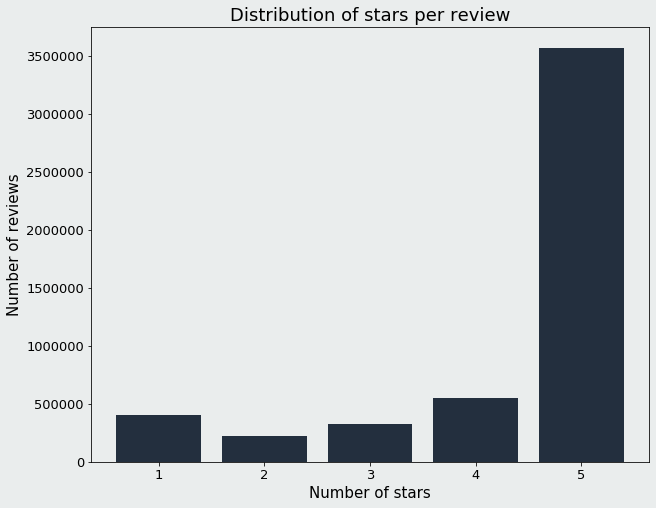

In [207]:
plot_bar_distribution(reviews['stars'],\
                      title="Distribution of stars per review",\
                      xlabel="Number of stars",\
                      ylabel="Number of reviews",\
                      figsize=(10,8),\
                      categorical=True)

As you can see a vast majority of reviews give 5 stars, but there are more 1 star than 2 or 3 stars, which is intersting. We can see that people usually review in the extreme either they think it's good so they give 4 or 5, or they thought it's trash and give 1.

Let's now take a look at `verified`.

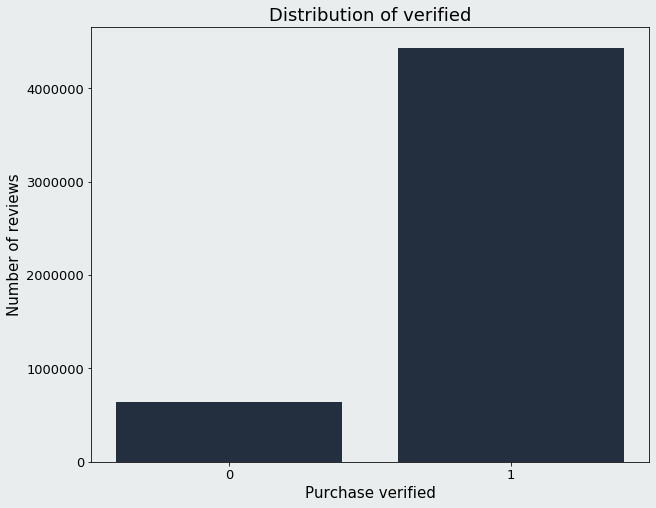

In [208]:
plot_bar_distribution(reviews['verified'],\
                      title="Distribution of verified",\
                      xlabel="Purchase verified",\
                      ylabel="Number of reviews",\
                      figsize=(10,8),\
                      categorical=True)

This is interesting and good news! As we can see most of the reviews are verified, so most of the reviews come from people that actually bought the product.

Let's plot the distribution of upvotes and compare it with the power law.

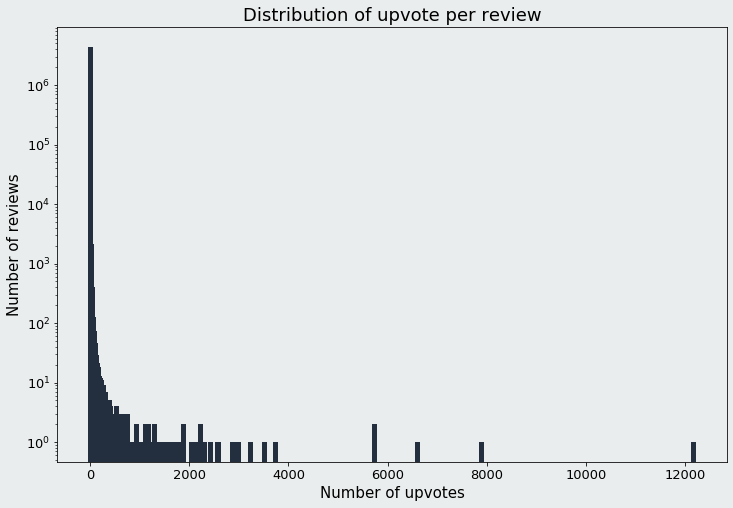

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/lulu/.venv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
/home/lulu/.venv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in true_divide
  (CDF_diff**2) /


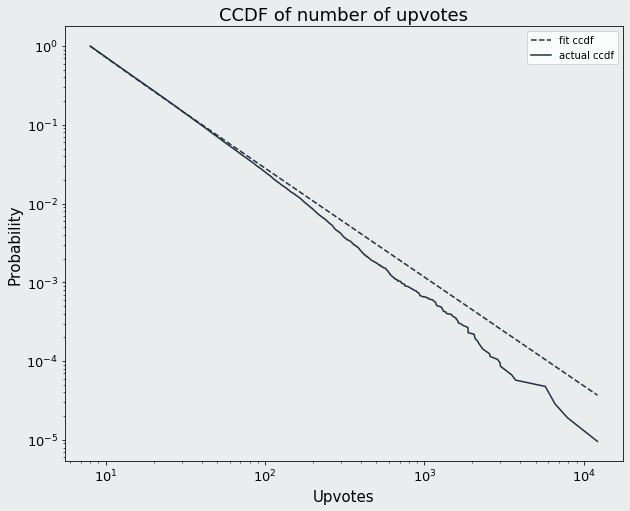

In [209]:
plot_bar_distribution(reviews['upvote'],\
                      title="Distribution of upvote per review",\
                      xlabel="Number of upvotes",\
                      ylabel="Number of reviews",\
                      yscale="log",\
                      width=100)

plot_ccdf_power_law(reviews['upvote'],\
                    title="CCDF of number of upvotes",\
                    xlabel="Upvotes",\
                    ylabel="Probability")

We can see that it indeed follows a power law, most of the reviews have 0 upvotes, but there are some with a high amount of upvotes.

Something to note that'll be able to see later on is that reviews with a huge amount of upvotes probably are jokes or memes. Otherwise it doesn't really make sense for a review to have so many upvotes.

Let's take a look at `reviewText` we can try to plot the distribution of the length of the reviews. It should also follow a power law.

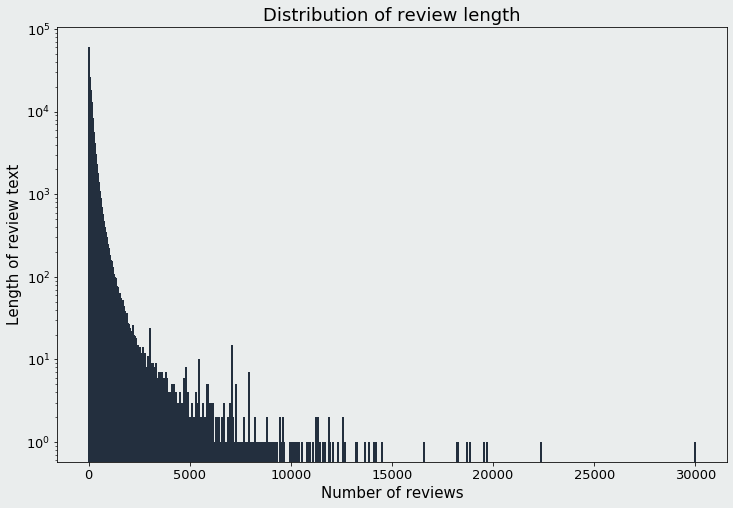

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


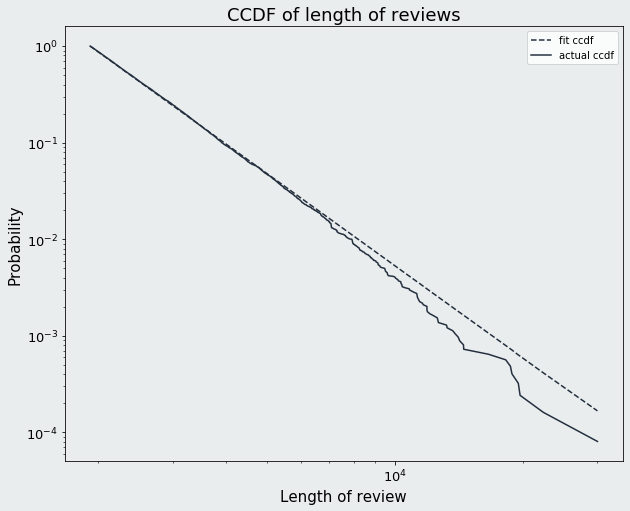

In [210]:
plot_bar_distribution(reviews['reviewText'].str.len(),\
                      title="Distribution of review length",\
                      xlabel="Number of reviews",\
                      ylabel="Length of review text",\
                      yscale="log",\
                      width=100)

plot_ccdf_power_law(reviews['reviewText'].str.len(),\
                    title="CCDF of length of reviews",\
                    xlabel="Length of review",\
                    ylabel="Probability")

Again, it follows a power law, which is to be expected.

Now let's take a look at how many reviews we have over time, using the date. This give us some information about how much reviews we have and if the number of reviews during the year is linear or constant, or on the contrary if it's varying a lot.

In [49]:
def write_plot_html(plot, file_name, open_plot=False):
    file_name = f"{PLOTS_LOCATION}{file_name}.html"
    output_file(file_name)
    
    # Show will open the plot in the browser, whereas save will not
    if open_plot:
        show(plot)
    else:
        save(plot)
        
    return FileLink(file_name)

In [87]:
reviews_per_date = reviews[['reviewTime']].copy()
reviews_per_date = pd.DataFrame(reviews_per_date.groupby('reviewTime').size(), columns=['count'])
reviews_per_date.sort_index(inplace=True)

tools = "pan, wheel_zoom"
source = ColumnDataSource(reviews_per_date)

p = figure(plot_width=1600, plot_height=900, tools=tools, x_axis_type="datetime", title="Review count", x_axis_label="Date", y_axis_label="Number of reviews")
p.line('reviewTime', 'count', source=source, color=LINE_COLOR)

color_style_plot_bokeh(p, legend=False)

write_plot_html(p, "all_reviews")

/home/lulu/EPFL/MA1/Ada/Project/milestone-3-plots/all_reviews.html

If you go to the above link (you may need to click on "Trust HTML", you can enable wheel zoom on the right and move the view by dragging), you can see that the number of reviews varies a lot during the year, but is globally increasing over time. 2015 seemed to have been a the big starting year for Amazon food category, which confirms that picking the updated 2018 dataset was a good idea since it adds a lot of data. We can also see that some dates have a lot of reviews, which we'll look into, for example March 2016. Something interesting is that our dataset ends in 2018 but as you can see it doesn't end abruptly, it decays rapidly, so we have to keep that in mind, we lack a lot of reviews in the 2018 year.

To look into it a bit deeper we can look at the distributions over year and month.

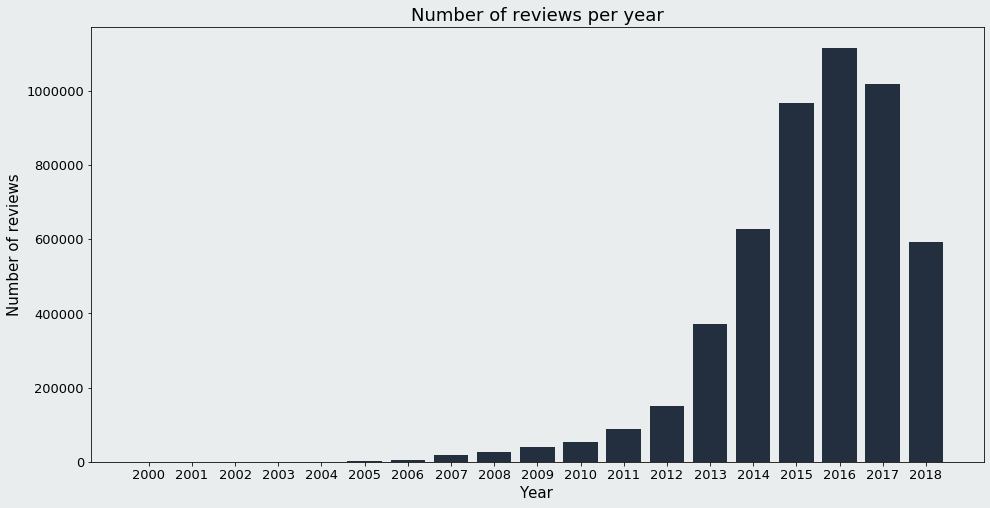

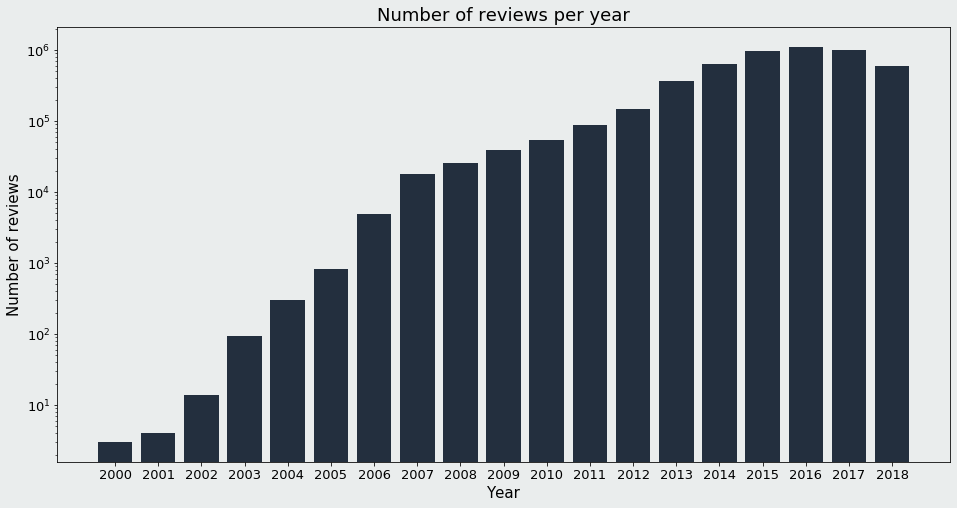

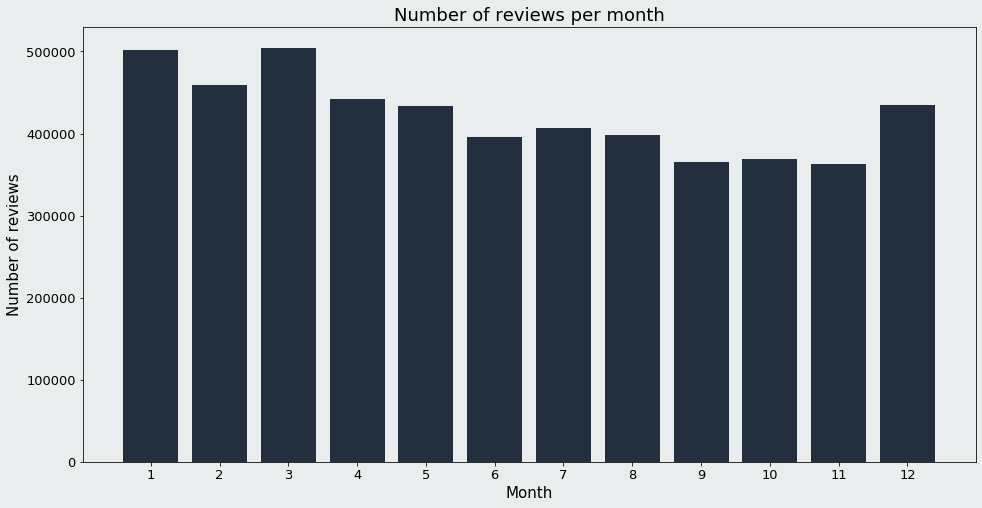

In [213]:
reviews_year = reviews['reviewTime'].map(lambda date: date.year)
args_year = {"data": reviews_year,\
             "title": "Number of reviews per year",\
             "xlabel": "Year",\
             "ylabel": "Number of reviews",\
             "figsize": (16, 8),\
             "categorical": True}

plot_bar_distribution(**args_year)
plot_bar_distribution(**args_year, yscale="log")

reviews_month = reviews['reviewTime'].map(lambda date: date.month)
plot_bar_distribution(reviews_month, title="Number of reviews per month", xlabel="Month", ylabel="Number of reviews", figsize=(16, 8), categorical=True)

As we can see, it indeed increases over the years, except 2018 as we lack reviews.

For the months it's somewhat even, but we can see that Winter is more popular, with Christmas, New Year, Valentine's Day and so on.

## 3. Keywords analysis for topic extraction

In order to dive deeper into the analysis of our dataset we start to analyse how topics are reprensented in products name and description. The approach here is the following :

    1. Choose a topic
    2. Choose keywords that are likely to appear in products' title and description, keywords that describe the topic
    3. Identify associated products
    4. Compute and plot the yearly proportion of reviews that those products represent, which corresponds to the 
    evolution of the topic popularity

To maximize the performance of the topic extraction, we pre-process the text with a standard nlp pipeline. What is important to us is only the words present in the text, we can thus remove the punctuation and the numbers. We remove the stopwords as well, to reduce the variability of what will become our tokens. We will check for the presence of words in the text so the lemmatization is really useful for us, it will reduce the false negative rate when extracting products for one topic.

### NLP pipeline and lemmatization

In [27]:
import string
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams

lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger');

def remove_punctuation(s):
    punct_chars = string.punctuation
    translator_punct = s.maketrans(punct_chars, ' ' * len(punct_chars))
    
    return s.translate(translator_punct)

def remove_numbers(s):
    numbers = '0123456789'
    translator_num = s.maketrans(numbers, ' ' * len(numbers))
    
    return s.translate(translator_num)

def remove_stopwords(s, other_stopwords):
    stopwords_np = np.array(stopwords.words('english'))
    if other_stopwords != None:
        stopwords_np = np.concatenate((stopwords_np, other_stopwords))
    words = np.array(s)
    words_filtered = words[~np.in1d(words, stopwords_np)]
    
    # remove words of length 1 and 2
    if words_filtered.shape[0] > 0:
        get_lengths = np.vectorize(len)
        lengths = get_lengths(words_filtered)
        ret_words = words_filtered[lengths > 2]
        return ' '.join(ret_words)
    else:
        return ' '.join(words_filtered)

def transform_tag(tag):
    """
    Helper function for the lemmatization. This function maps the tag passed 
    as argument to the appropriate tag accepted by the lemmatize function.
    """
    tag_prefix = tag[0].lower()
    if tag_prefix in ['n', 'r', 'v', 'j']:
        return 'a' if tag_prefix == 'j' else tag_prefix
    else:
        return 'n'

def lemmatize(t, return_list=True, other_stopwords = None):
    t = str.lower(t)
    t = remove_numbers(t)
    t = remove_punctuation(t)
    t_token = word_tokenize(t)
    t_tags = pos_tag(t_token)
    t_lemm = [lemmatizer.lemmatize(w, transform_tag(t)) for w, t in t_tags if len(w) > 1]
    t_lemm = remove_stopwords(t_lemm, other_stopwords)
    if return_list:
        return t_lemm.split()
    else:
        return t_lemm

[nltk_data] Downloading package punkt to /home/flo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/flo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/flo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


We now apply this pipeline, we lemmatize all descriptions of products, i.e. the description and the title in the metadata.

In [32]:
%%capture
meta['description'] = meta['description'].parallel_apply(lemmatize)
meta['title'] = meta['title'].parallel_apply(lemmatize)
meta.to_csv('./processed-data/meta_lemm.csv')

In [30]:
lemmatized = pd.read_csv('./processed-data/meta_lemm.csv').fillna("")
lemmatized

,Unnamed: 0,category,description,title,brand,rank,main_cat,price,asin,date
0,0,"Grocery & Gourmet Food||Dairy, Cheese & Eggs||Cheese||Gouda",beemster gouda cheese age month,beemster gouda age month app lb,Ariola Imports,"165,181inGroceryGourmetFood(",Grocery,41.91,0681727810,
1,1,Grocery & Gourmet Food||Cooking & Baking||Sugar Substitutes||Xylitol,ship uk please allow business day arrival ex lib pub apply science publisher ltd,trim healthy mama xylitol,,"315,867inGroceryGourmetFood(",Grocery,,0853347867,
2,2,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers|...",jazz cake sparkle monogram sparkle collection single letter monogram silver plat covered crystal...,letter swarovski crystal monogram wed cake topper letter,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#9,899 in Kitchen & Dining > Bak...",Amazon Home,29.95,1888861118,2010-09-21
3,3,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers|...",large letter height,letter swarovski crystal monogram wed cake topper letter,Other,">#832,581 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#12,883 in Kitchen & Dining > Ba...",Amazon Home,11.45,1888861517,2011-09-11
4,4,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers|...",,letter swarovski crystal monogram wed cake topper letter,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#8,585 in Kitchen & Dining > Bak...",Amazon Home,15,1888861614,2011-09-11
...,...,...,...,...,...,...,...,...,...,...
283507,287204,"Grocery & Gourmet Food||Jams, Jellies & Sweet Spreads||Jams, Jellies & Preserves",caffarel fruit jelly product italy caffarel fruit jelly organic assorted gram bag assort fruit j...,caffarel fruit jelly organic assorted bag,Caffarel,"369,384inGroceryGourmetFood(",Grocery,,B01HJFBN9A,
283508,287205,Grocery & Gourmet Food||Condiments & Salad Dressings||Mayonnaise,hampton creeks mayo truffle make fancy food simple sandwich youre put perfect way take favorite ...,hampton creek spo truffle mayo ounce,Hampton Creek,"113,710inGroceryGourmetFood(",Grocery,10.89,B01HJFC704,
283509,287206,Grocery & Gourmet Food||Condiments & Salad Dressings||Salad Dressings||Ranch,nothing compare classically zesty flavor hampton creeks ranch creamy savory hard resist make dre...,hampton creek ranch dress fluid ounce,Hampton Creek,"21,731inGroceryGourmetFood(",Grocery,10.95,B01HJF6FRA,
283510,287207,"Grocery & Gourmet Food||Herbs, Spices & Seasonings||Single Herbs & Spices||Vanilla Beans",,gourmet pure vanilla bean paste organically grown contains whole vanilla seed hand pick heilala ...,Heilala Vanilla,472inGroceryGourmetFood(,Grocery,14.97,B01HJHSVG6,


### Word2Vec model creation

In [76]:
import gensim.models

descriptions_and_titles = lemmatized[['description', 'title']].apply(lambda row: f"{row[0]} {row[1]}".split(' '), axis=1)
descriptions_and_titles = descriptions_and_titles.tolist()
model = gensim.models.Word2Vec(sentences=descriptions_and_titles, workers=4, min_count=10)

Let's quickly see if our model permit to get results that make sense

**Show that the model make sense with things as below (have to re-run the cell)**

In [77]:
model.wv.most_similar('cheese')

[('mozzarella', 0.712142825126648),
 ('emmental', 0.7112277746200562),
 ('belgioioso', 0.7095264196395874),
 ('provolone', 0.7030577063560486),
 ('romano', 0.6988654732704163),
 ('manchego', 0.682680070400238),
 ('goat', 0.6742475032806396),
 ('cabot', 0.6740319728851318),
 ('parmigiano', 0.6674710512161255),
 ('colby', 0.6663662195205688)]

### Food trends extraction

We can now start to go a bit more in depth with the analysis ! The first subject we wanted to take a look at is whether or not some trends have impacted the reviews dataset and how we can measure it. So we'd want to see if topics such as *'Healthy/natural'*, *'vegan'* and others have increased over the years or not.

To do that we first wanted to label the reviews manually and then use machine learning to label the rest of the reviews and then count how many reviews we have for a given topic. However, this solution had 2 major issues. First, it takes time to label enough reviews manually given the time we have and then feeding all of that to a carefully made machine learning algorithm would have also taken a lot of time. But, analyzing growth of trends is not our major research question, we wanted to spend more time on impacts of events rather than impact of trends. Second, a lot of reviews cannot be classified properly, as we saw most of them are really short. How do you say if a review 'Awesome, love it!' is vegan or not? Impossible, right? If you know on what product it was published you get more information. If you know this was published on a vegan product you can infer that it contributes to the vegan trend.

So we decided that to study a trend it makes sense to take the problem the other way around, classify products instead of reviews. Mark a product as vegan and then all of his reviews will count towards the vegan trend. Of course this is an analysis choice, so it has pros and cons. There probably are vegan reviews that go to non-vegan products and review them poorly, as we know it's fairly common to find hate movements on the internet. But we assume that is this way less frequent than vegan reviews for vegan products.

Now that we know generally how we want to procede how to do it concretely? We still have the issue that doing machine learning would take time but we still tried to give it a shot. We then started to label products manually. However, while doing it we realized that it wouldn't be feasible time-wise and realized that this task can be achieved with reasonable results using a much simpler technique. Indeed, we aren't looking at reviews now but at products; products whose goals are to be sold. This means that there usually are marketing teams behind them, and they usually want to push the qualities of their products forward. So when labelling we realized that simple keywords were in a vast majority of cases enough to label a product correctly. Plus while cleaning the data we removed all the parts that are common to almsot all reviews that would bias this analysis. Now description and titles really contain the description and title of the product, so the bias isn't very big.

So we can now proceed, let's take the keywords we found, classify the products and count the number of reviews.

In [123]:
# Labelling, we had 5 different labels
# 1. healthy/natural, this had a lot of keywords so we'll use them
# 2. vegetarian/vegan, only a few keywords could label with good precision
# 3. local, not common so we won't use it
# 4. sport/productivity, not common so we won't use it
# 5. country, name of countries that were mentioned, if any
labels = pd.read_csv('./to-label/to-label-2.csv', header=None, na_values="None",\
                     names=["asin", "title", "description", "healthy/natural", "vegetarian/vegan", "local", "sport/productivity", "country"])
labels.head()

,asin,title,description,healthy/natural,vegetarian/vegan,local,sport/productivity,country
0,B00122CNFU,"Cajun King Barbecued Shrimp Seasoning Mix, 1-Ounce Packages (Pack of 24)",Be sure to have lots of French Bread around to sop up all the good juices left over after you ea...,NaN,NaN,NaN,NaN,NaN
1,B0046LF9IM,"Roland Curry Powder, Madras, 1 Pound (Pack of 4)",Our mission is to be the leader in importing and marketing superior quality specialty foods unde...,"superior quality, highest standards",NaN,NaN,NaN,"India, Madras"
2,B001E5E3AS,"Erewhon Barley Plus, Organic Hot Cereal, 14-Ounce Boxes (Pack of 6)","A hearty hot cereal made from organically grown barley, oat bran, and brown rice. Erewhon Barley...","100% natural, low fat, good source of fiber, quality, finest, organic",NaN,NaN,NaN,NaN
3,B00KDLMEFA,Simply Right Allergy Multi-symptom Relief: 600 Cool Caplets with Cool Blast Flavor,NaN,NaN,NaN,NaN,NaN,NaN
4,B005R6T6BQ,Delight Expressions™ Peek-a-boo! Halloween Gift Basket - For Kids - For Her - For Him,This candy and chocolate boo-quet is frightfully filled with spook-tacular sweets. Nobody will b...,NaN,NaN,NaN,NaN,NaN


In [66]:
def get_values_for_col(col):
    """
    Get all labelling keywords for a given col
    """
    values = labels[col][labels[col].notnull()].str.\
                split(', ').\
                explode().\
                unique()
    return values

In [56]:
healthy_natural = get_values_for_col("healthy/natural")
healthy_natural

array(['superior quality', 'highest standards', '100% natural', 'low fat',
       'good source of fiber', 'quality', 'finest', 'organic',
       'all natural', 'fat free', 'cholesterol free', 'sodium free',
       'gluten free', 'lactose free', 'Organics', 'natural way',
       'without chemical fertilizers', 'without insecticides',
       'without herbicides', 'healthy', 'natural', 'health', 'well-being',
       'highest-quality', 'healthy living', 'gluten-free', 'dairy-free',
       'thin', 'antioxidants', 'very best', 'with care',
       'quality products', 'ethically'], dtype=object)

In [70]:
# Furthen fine-grained keywords
healthy_natural = ['100% natural', 'low fat', 
                   'good source of fiber', 'organic', 'organically'
                   'all natural', 'fat free', 'cholesterol free', 'sodium free',
                   'all-natural', 'fat-free', 'cholesterol-free', 'sodium-free',
                   'gluten free', 'lactose free', 'Organics',
                   'without chemical fertilizers', 'without insecticides',
                   'without herbicides', 'highest-quality', 'healthy living', 'gluten-free', 'dairy-free',
                   'quality products', 'ethically']

In [36]:
# Replace date with year, to aggregate easily
# We only take into account dates with reasonably high number of reviews (2012-May 2018)
# We don't count the end of 2018 because a lot of reviews are missing and
# we don't know if it's random or if it's specific categories so we don't count it
# since we count the percentages it shouldn't have any impact to not take the full year into account
reviews_year = reviews.copy()
reviews_year = reviews_year[(reviews_year['reviewTime'] >= "2012-01-01") & (reviews_year['reviewTime'] <= "2018-05-01")]
reviews_year['reviewTime'] = reviews_year['reviewTime'].apply(lambda date: date.year)

In [127]:
def plot_proportion_year(keywords, reviews_year, meta_df, title, xlabel="Year", figsize=(12,10), linear_reg=True):
    """
    Plot the proportion of reviews that are for products that contain the given keywords
    """
    # Find products that contain at least one of the keywords
    asins = meta_df["asin"][(meta_df["title"].str.contains('|'.join(keywords))) |\
                         (meta_df["description"].str.contains('|'.join(keywords)))].values
    
    # Count how many review per year there were on these products
    reviews_per_date_interest = reviews_year[['reviewTime', 'asin']].copy()
    reviews_per_date_interest = reviews_per_date_interest[['reviewTime']][reviews_per_date_interest['asin'].isin(asins)]
    reviews_per_date_interest = pd.DataFrame(reviews_per_date_interest.groupby('reviewTime').size(), columns=['count_interest'])
    
    # Count total number of reviews per year
    reviews_per_date = reviews_year[['reviewTime']].copy()
    reviews_per_date = pd.DataFrame(reviews_per_date.groupby('reviewTime').size(), columns=['count_total'])
    
    # Compute percentage of reviews that are about the selected products
    reviews_per_date = reviews_per_date.merge(reviews_per_date_interest, left_index=True, right_index=True)
    reviews_per_date["proportion_interest"] = reviews_per_date["count_interest"].fillna(0) / reviews_per_date["count_total"] # fillna just in case
    
    # Get years and proportions
    reviews_per_date.sort_index(inplace=True)
    years = reviews_per_date.index
    proportions = reviews_per_date["proportion_interest"].values * 100
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.bar(years, proportions, color=LINE_COLOR, width=0.5)
    ax.set_xticks(years)
    
    # Compute linear regression, and do statistical test where H0 is slope==0
    if linear_reg:
        slope, intercept, r_value, p_value, stderr = linregress(years, proportions)
        estimated_values = [slope * i + intercept for i in years]
        print(f"p-value: {p_value}")
        ax.plot(years, estimated_values, color='red', linewidth=2)
    
    # Compute max difference
    max_diff = np.max(proportions) - np.min(proportions)
    print(f"Max difference of popularity (max - min): {max_diff:.2f}%")
    
    # Show value on the middle of bar
    for a,b in zip(years, proportions):
        plt.text(a - .235, b/2, f"{b:.2f}%", fontsize=MATPLOT_TICK_SIZE, fontweight='bold', color='white')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Percent of reviews")
    
    color_style_plot_matplotlib(fig, ax)
    fig.savefig('vegan-trend.png', facecolor=fig.get_facecolor())

Let's see the evolution of the '*healthy/natural*' trend !

p-value: 0.003047909497116813
Max difference of popularity (max - min): 3.81%


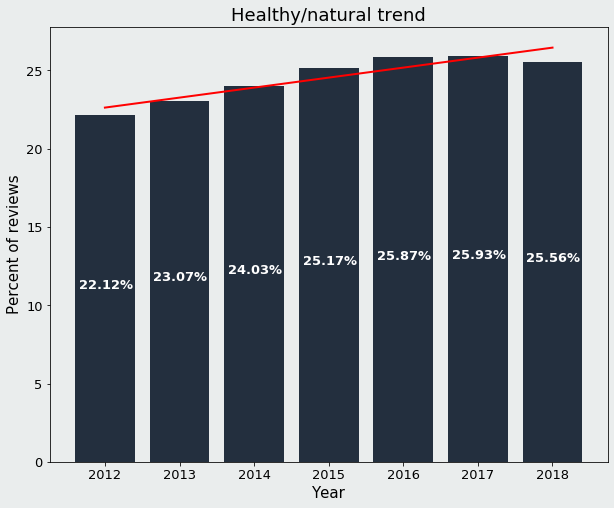

In [71]:
plot_proportion_year(healthy_natural, reviews_year, lemmatized, title="Healthy/natural trend")

As we can see there was a max increase of `3.81%`! And keep in mind that it's number of reviews that are for products that fall within this category, so `3.81%` is quite big number. We can also notice that the p-value is `~0.003` which is very small, we can then soundly conclude that the slope is not a zero. Which means we would indeed have an increase for this topic, as we said one of the downside we have is that since healthy and natural products are trendy maybe the marketing teams put them way too frequently and inside products that don't really fall within this category. However we study the *consumption* of users not the *food* itself. So what matters is what the user thinks he is buying, not what he's actually buying. So we can conclude that users tend to be more and more inclined to products marked as healthy or natural.

We can now take a look at the vegan trend, in order to have good accuracy we decided to only have one keyword: `vegan`. As we don't want to see vegetariansism or whatnot but veganism; precise topic requires precise keywords.

p-value: 0.00014606833249303458
Max difference of popularity (max - min): 1.83%


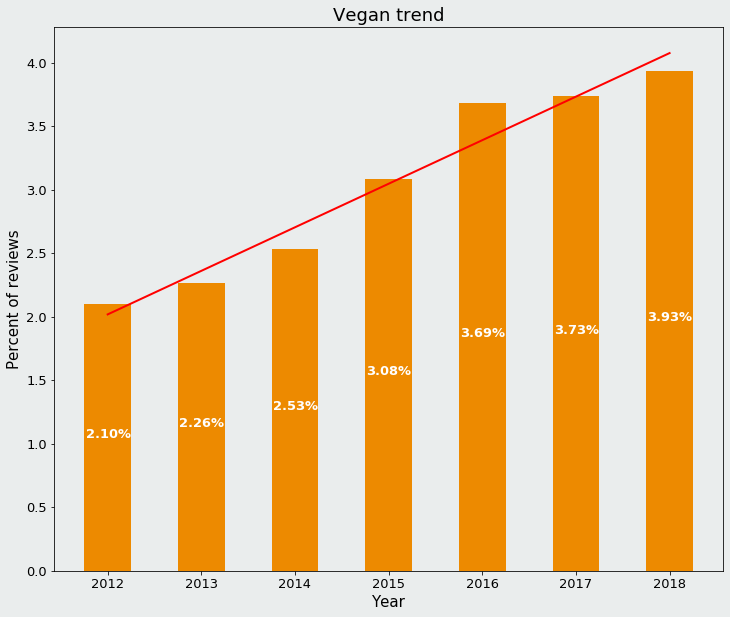

In [72]:
plot_proportion_year(["vegan"], reviews_year, lemmatized, title="Vegan trend")

We can see that this topic really has seen a big boost over they years, net increase of `1.83%` and almost doubled since 2012. Plus, the p-value is really tiny once again.

Something interesting we noticed while labeling is that there were some reviews about specific diet, and we had the impression that diets really have become more popoular over the years. So we decided to take a look at it. We started with the paleo diet and used our word to vec to get more diets !

In [83]:
model.wv.most_similar('paleo')

[('keto', 0.7668061256408691),
 ('vegan', 0.632681667804718),
 ('gf', 0.5527564287185669),
 ('primal', 0.5511264204978943),
 ('glutenfree', 0.5437076687812805),
 ('diabetic', 0.5409843921661377),
 ('caveman', 0.540922224521637),
 ('sophie', 0.520267903804779),
 ('paleokrunch', 0.5166264772415161),
 ('slims', 0.5084096193313599)]

The first word is `keto`, which is also a diet! Also called 'ketogenic', and there is another diet called 'atkins' which is pretty similar to keto, so we added it aswell. Let's see what we get.

p-value: 1.8822724218356313e-05
Max difference of popularity (max - min): 2.08%


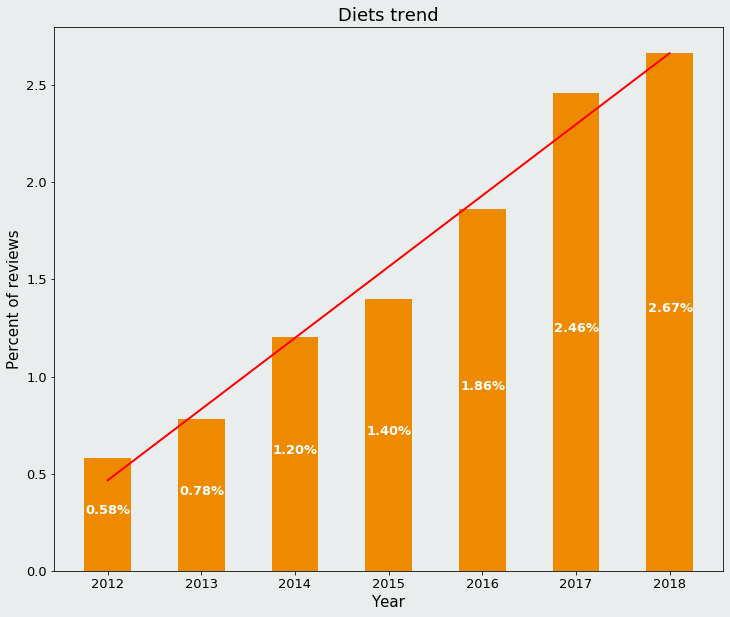

In [84]:
plot_proportion_year(["paleo", "keto", "ketogenic", "atkins"], reviews_year, lemmatized, title="Diets trend")

Ah ha, what a beautiful slope, the p-value is so tiny Jupyter decided to use scientific notation ! This is a remarkable increase, the proportion of reviews for these products has been multiplied by 5, and has seen a net increase of 2.08%. Something to note is that these diets promote eating 'cavemen-like' food, (which is why caveman is so similar to paleo in w2v, and where its name comes from). So they promote eating a lot of protein mostly from animals, eggs, meat, fish, butter, cheese, while eating a low amount of glucide. Does that it ring a bell? Well at least it rung mine, a few years ago I remember how 'fat' was getting 'trashtalked' espcially animal-fat; that it increases heart diseases, blocks your arteries, has bad cholesterol and so on. So maybe fat hasn't such a bad image now and isn't promoted as much in products, let's see if that looks to be true or not.

In [89]:
# Most similar words to 'fat'
model.wv.most_similar('fat')

[('cholesterol', 0.6848185062408447),
 ('sodium', 0.5963536500930786),
 ('ldl', 0.5888922810554504),
 ('lactose', 0.5789650082588196),
 ('calorie', 0.5549061894416809),
 ('fats', 0.547609806060791),
 ('gorduras', 0.5448648929595947),
 ('fibra', 0.5423295497894287),
 ('methoxyl', 0.5406451225280762),
 ('caloric', 0.531798243522644)]

p-value: 0.0005384677012842251
Max difference of popularity (max - min): 6.46%


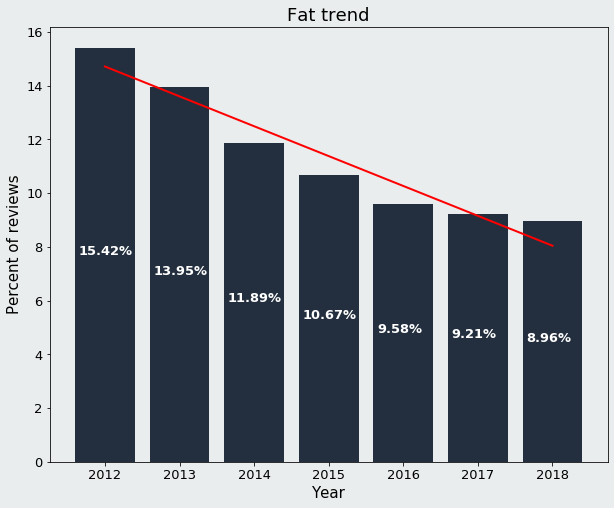

In [90]:
# Plot 'fat' trend evolution
plot_proportion_year(["fat", "fats", "cholesterol"], reviews_year, lemmatized, title="Fat trend")

We can see that the 'fat trend' has indeed strongly decreased over the years on Amazon, it looks like it indeed isn't as much of a concern nowadays.

Now, for fun, we can try to see the evolution of 'tea/coffee' trend because these products are really popular on Amazon! We can try to see if there was some evolution over the years or not.

p-value: 0.6657011549614333
Max difference of popularity (max - min): 1.11%


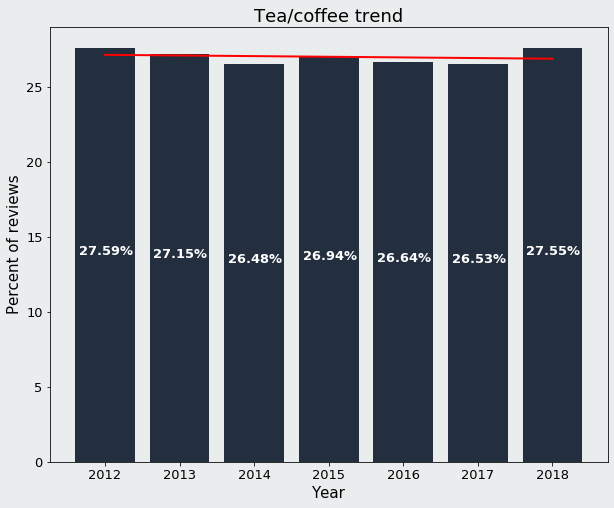

In [91]:
# Plot 'tea/coffee' trend
plot_proportion_year(['tea', 'coffee'], reviews_year, lemmatized, title="Tea/coffee trend")

We can notice that the estimated curve has basically a slope of 0, looks like Amazon users have always been really fond of tea/coffee. We can see that the p-value is now really big. It's still funny that a quarter of reviews are for products that mention tea or coffee.

In the end, we haven't used the word2vec all that much. However, this is due to a design choice; had we decided to use machine learning, we'd have used it extensively. However, since we used a different, simpler approach it turns out it wasn't very suited for the job. But training it wasn't a big overhead and it turns out it still came in handy to find words that are related to a topic.

### A Country tour of the amazon food dataset

We now can do something similar but to study the relation to countries instead of the evolution over the years. We can select a different topic, with a keyword, for example `tea`, and see how many times tea-products mention a given country. That way we can have an idea of what countries some products are associated to. Especially since we saw that Amazon clients are so fond of coffee and tea, we had an idea that Italy and China would be referenced multiple times.

In [127]:
# See what kind of countries we had
labels[labels["country"].notnull()].head()

,asin,title,description,healthy/natural,vegetarian/vegan,local,sport/productivity,country
1,B0046LF9IM,"Roland Curry Powder, Madras, 1 Pound (Pack of 4)",Our mission is to be the leader in importing and marketing superior quality specialty foods unde...,"superior quality, highest standards",NaN,NaN,NaN,"India, Madras"
6,B001FA1KN0,NaN,"All natural. Fat free, cholesterol free, and sodium free. Product of France. Chestnuts.","all natural, fat free, cholesterol free, sodium free",NaN,NaN,NaN,France
11,B001979YRI,"Oskri Date Fruit Bar, Gluten Free, 1.5-Ounce Bars (Pack of 20)",Gluten free. Lactose free. Oskri Organics is committed to offering the best products that are gr...,"gluten free, lactose free, Organics, natural way, without chemical fertilizers, without insectic...",NaN,Made in the USA,NaN,USA
14,B001EQ543M,NaN,Asia/Pacific: Coffees from Asia/Pacific are full-flavored with characteristics that range from t...,NaN,NaN,NaN,NaN,"Asia, Pacific"
20,B00B8BQ3ZG,Hormel Compleats Cafe Creations Three Cheese Chicken Pasta 9 oz,Inspected for wholesomeness by U.S. Department of Agriculture. Infused with unique seasonings & ...,NaN,NaN,NaN,NaN,"Swiss, American"


In [128]:
# List of countries and adjectives, don't include USA as too many products will reference USA
# despite the product not being related to USA, since we have an American data set.
countries = ["france|french",\
             "italy|italian",\
             "japan|japanese",\
             "china|chinese",\
             "england|english|british",\
             "india|indian",\
             "switzerland|swiss"]

In [143]:
def check_country_interest(keywords, meta_df, countries):
    """
    Plot the number of reviews that mention each of the countries for each of the given keywords
    """
    # Create figure, 2 columns, needed number of rows
    nrows = ceil(len(keywords)/2)
    ncols = 2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches((10*ncols,8*nrows))
    
    for i, keyword in enumerate(keywords):
        # Get products that are about the keyword
        products = meta_df[['title', 'description']][(meta_df["title"].str.contains(keyword)) |\
                                                     (meta_df["description"].str.contains(keyword))]
        # Compute counts for each country
        counts = [
            len(products[(products['title'].str.contains(country)) |\
                        (products['description'].str.contains(country))].index)
            for country in countries
        ]
        
        row = i//2
        col = i % 2
        ax = axs[row,col]
        
        # Name of countries
        countries_name = [country.split('|')[0].capitalize() for country in countries]
        
        # Bar plot + title, ticks and labels
        ax.bar(countries_name, counts, width=0.35, color=LINE_COLOR)
        ax.set_title(f"Country count for {keyword}", fontsize=15)
        ax.set_xticklabels(countries_name, rotation=30, fontsize=13)
        ax.set_ylabel("Count", fontsize=13)
        
        # Color style
        color_style_plot_matplotlib(fig, ax)
    
    plt.show()

In [89]:
def check_country_interest(keywords, meta_df, countries):
    """
    Plot the number of reviews that mention each of the countries for each of the given keywords
    """
    
    for i, keyword in enumerate(keywords):
        # Get products that are about the keyword
        products = meta_df[['title', 'description']][(meta_df["title"].str.contains(keyword)) |\
                                                     (meta_df["description"].str.contains(keyword))]
        # Compute counts for each country
        counts = [
            len(products[(products['title'].str.contains(country)) |\
                        (products['description'].str.contains(country))].index)
            for country in countries
        ]
        
        # Name of countries
        countries_name = [country.split('|')[0].capitalize() for country in countries]
        
        # Bar plot + title, ticks and labels
        fig = plt.figure(figsize=(10,8))
        plt.bar(countries_name, counts, width=0.35, color=LINE_COLOR)
        plt.title(f"Country count for {keyword}", fontsize=15)
        plt.xticks(countries_name, rotation=30, fontsize=13)
        plt.ylabel("Count", fontsize=13)
        
        # Color style
        color_style_plot_matplotlib(fig, plt.gca())
        plt.show()
        _ = fig.savefig(f"{keyword}.png", facecolor=fig.get_facecolor())

Now we can see what countries are popular for some products ! We chose a few topics that are quite popular and might have interested results.
- `coffee`, `tea`, `cheese`, `curry`, `espresso`, `wine`

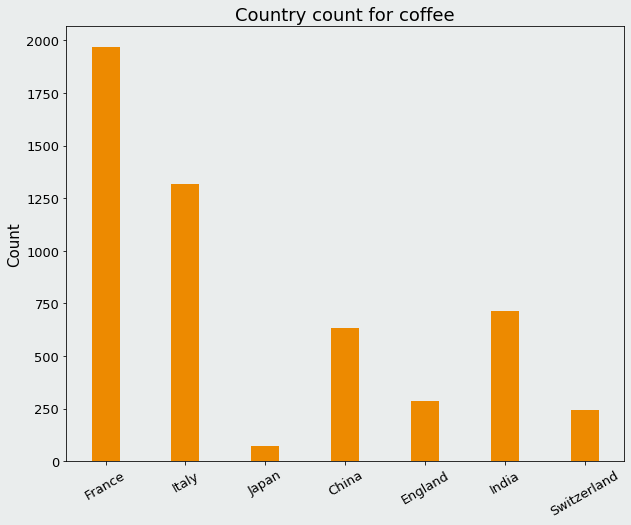

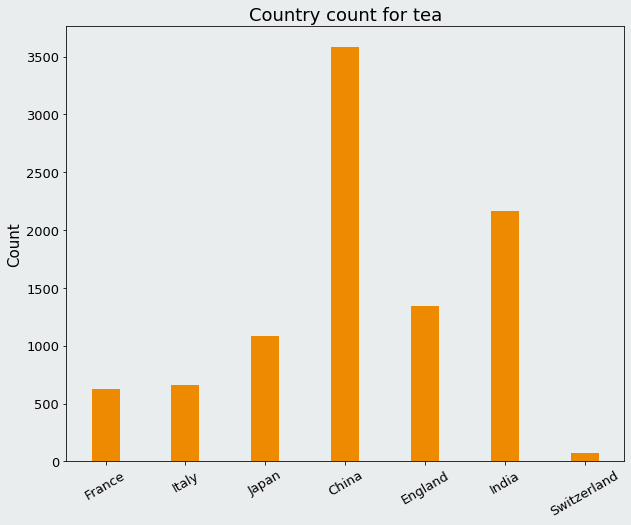

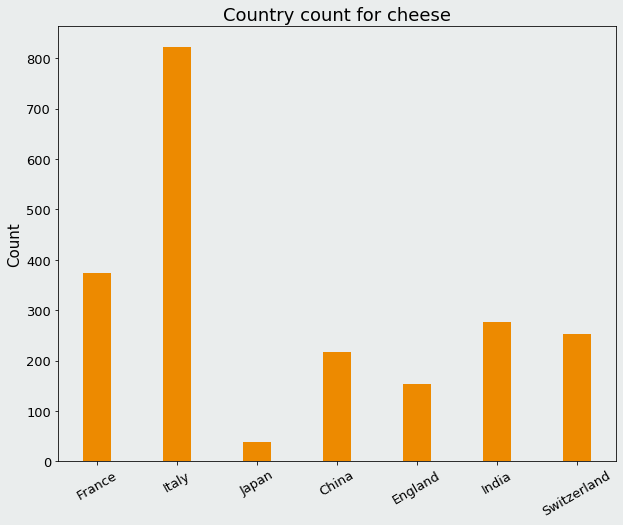

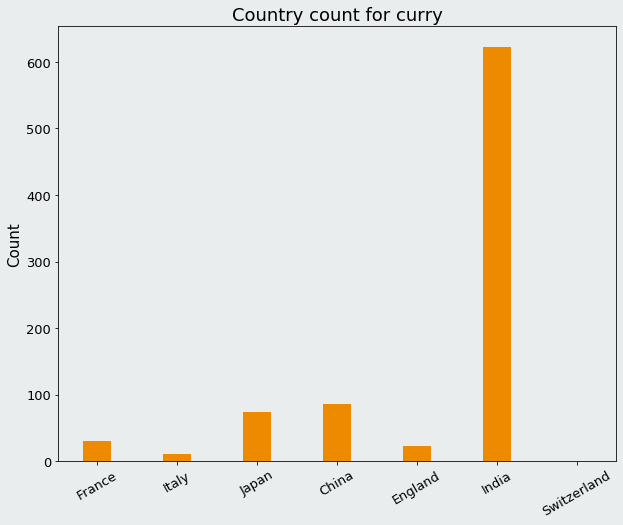

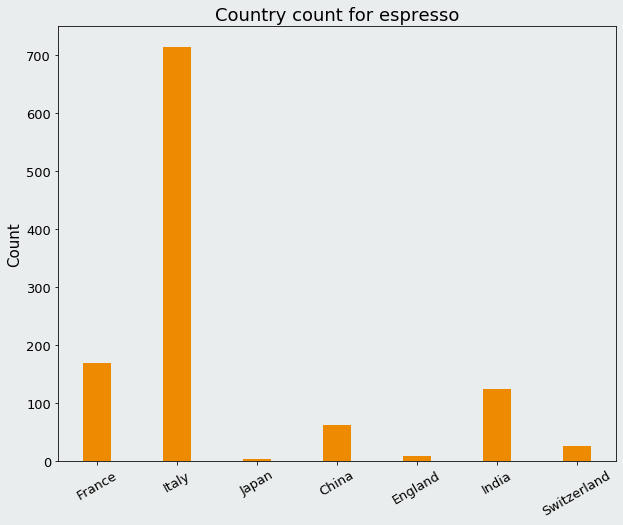

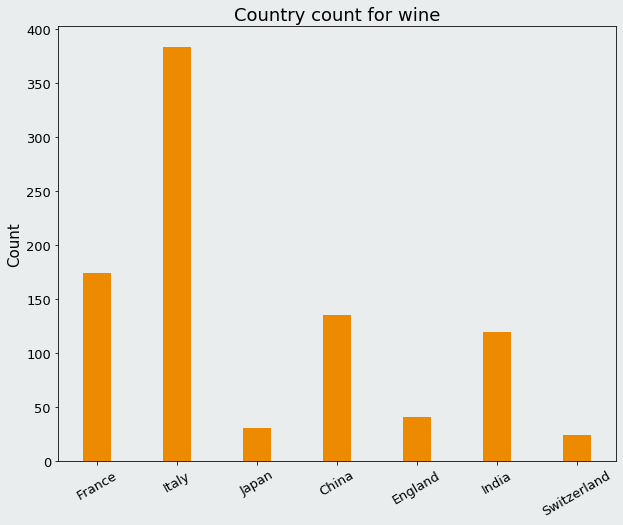

In [90]:
# Plot interest for each of these topics
check_country_interest(["coffee", "tea", "cheese", "curry", "espresso", "wine"], lemmatized, countries)

From these graphs we can support the a priori ideas we had on what they should look like. We can see the following assosciations:
- `coffee`: Italy, France
- `tea`: China, India
- `cheese`: France, Italy (and maybe Switzerland! it's a really small country so it'd be weird to notice very high values)
- `curry`: India
- `espresso`: Italy
- `wine`: Italy and France. It's also interesting to see that China and India are catching up, the wine consumption has drastically increased in China since the 1980s. Wine consumption in India has also increased quite a lot during the same periods.

It's always funny to see how products are assosciated to different countries and cultures. Now that we have studied trends we can go a bit further and study the effect of events and the rise of popularity of products using time series!

## 4 Analysis of the products' popularity evolution, how much is it affected by real world's events?

In this section, we focus on analysing the evolution of the number of reviews for a given products and their word frequencies. In other words, we first select products whose evolution in terms of the number of reviews is surprising. Then, with those products we try to investigate why this is the case and where it comes from. Indeed, the hearth of this section is to find effects of events that happened in the real world in our dataset. Thus, to achieve such a goal we use the the reviews, since it is our main source of information.

We begin presenting some funny and interesting punctual effects that we found during the analysis. These effects are important to keep in mind for all our analysis, since they are constantly present in the dataset at different scales. We show here an example (cf. Mad Max below) when it is extreme and we explain further those unsual effects in the next section (cf. Arty water and Kasandrinos oil). We start the next section by trying to visualize the events by plotting their words frequencies. This allows us to see what characterises an event, what topic is present in it, and how impactful they are. To complete the analysis of this events, we pick products corresponding to them and predict what their popularity would have been without the presence of the event using bayesian structural time series in order to give a statistical argument that those products are indeed affected by the presence of the event. It shows the impact of the event on a pool of products and thus that the word frequencies of the latters is correlated with the event.

So let's begin by visualizing the first products' popularity distribution, to this end we create a dataframe containing the number of reviews per product and per week:

In [24]:
def compute_reviews_per_week(reviews, minimum_review):
    """
    Create dataframe with number of reviews per product per week, based on the {reviews} dataframe, keep only 
    the ones that have at least {minimum_review} during a week
    """ 
    reviews_per_week = pd.DataFrame(reviews[['asin', 'reviewTime']].groupby(['asin', pd.Grouper(key='reviewTime', freq='W')]).size(), columns=['reviewCount'])
    # Filter out products whose maximum number of reviews for a week is less than 7
    reviews_per_week = reviews_per_week.groupby(['asin']).filter(lambda row: row.to_numpy().max() > minimum_review)
    reviews_per_week.reset_index(inplace=True)
    return reviews_per_week

In [25]:
reviews_per_week = compute_reviews_per_week(reviews, 7)

In [88]:
def plot_time_series(ids, plot_filename, title, open_plot=False):
    """
    Create an interactive plot that show the evolution of the number of reviews for the 
    given products
    
    :param ids: an iterable with the ids (asin) that will be in the plot
    :param plot_filename: the filename of the produced plot
    :return: the path to the plot
    """
    tools = "pan, wheel_zoom"
    p = figure(plot_width=1600, plot_height=900, tools=tools, x_axis_type="datetime", title=title, x_axis_label="Date", y_axis_label="Review count")
    num_colors = np.clip(len(ids), 3, 20)
    colors = d3['Category20'][num_colors]
    
    for i, asin in enumerate(ids):
        reviews_asin = reviews_per_week.loc[reviews_per_week['asin'] == asin, ['reviewTime', 'reviewCount']]
        reviews_asin.set_index('reviewTime', inplace=True)
        reviews_asin.sort_index(inplace=True)

        source = ColumnDataSource(reviews_asin)

        # If only one id give, use LINE_COLOR
        color = colors[i%20] if len(ids) > 1 else LINE_COLOR
        p.line('reviewTime', 'reviewCount', source=source, legend_label=str(asin), color=color, line_width=2, alpha=0.8)
    
    p.legend.click_policy = "hide"
    color_style_plot_bokeh(p)
    
    return write_plot_html(p, plot_filename, open_plot)

In [90]:
print('Distribution of the first seven product in the dataset:')
plot_time_series(reviews_per_week['asin'].unique()[:7], "time_series_first_7_products", "Review count for products that got popular")

Distribution of the first seven product in the dataset:


/home/jules/documents/epfl/ma1/ada/project/milestone-2-plots/time_series_first_7_products.html

As before, this is an interactive plot for which you may have to "trust" to see.  
Just with this small sample we can already see that two products (red and orange) seems interesting, let's look at them a little bit closer.

In [97]:
id_spray = "B0000CFH7B"
id_cookie = "B0000D916Y"
print('Product 1:\n ', meta["title"][meta["asin"] == id1].values[0])
print('Product 2:\n ', meta["title"][meta["asin"] == id2].values[0])

print('\nReviews of the first product:')
reviews_spray = reviews[["reviewTime", "reviewerID", "reviewText", "summary", "upvote", "stars", 'verified']]\
                        [(reviews["asin"] == id_spray) &\
                         (reviews["reviewTime"] >= pd.to_datetime("2015-05-22")) &\
                         (reviews["reviewTime"] <= pd.to_datetime("2015-06-15"))]

display(reviews_spray.head(5))
date_with_max_reviews = reviews_spray.groupby("reviewTime").agg("size").idxmax()
print(f"Date with max number of reviews: {date_with_max_reviews.date()}")

Product 1:
  Wilton 710-5506 Color Mist Spray 1.5oz, Black
Product 2:
  David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Corporate Food Tin - Idea For Men & Women - Certified Kosher - 2 lb.

Reviews of the first product:


,reviewTime,reviewerID,reviewText,summary,upvote,stars,verified
4197,2015-06-15,A1Q6MV8HRC58KK,If you go back to the beginning of the reviews there are about 13 pages of nonsense about baking...,Best Shine in the Wasteland,66,5,False
4198,2015-06-13,ABD1G0MCG2QHT,"My cupcakes are all shiny and chrome. I eat, I poop, I eat again.",Five Stars,47,5,False
4199,2015-06-12,A3OX7K7TZ1A6IG,I BUY! I RETURN! I BUY AGAIN!!,Five Stars,123,5,False
4200,2015-06-12,A3N37GJGVFUDJB,Mitch has witnessed me!!!,Five Stars,11,5,False
4201,2015-06-11,ABZC6GUF3EZR9,IT BURNS OH IT BURNS WONDERFULLY\nTHE PATH TO VALHALLA IS NOT A PAINLESS ONE,SHINY AND CHROME,77,5,True


Date with max number of reviews: 2015-05-27


This is quite funny, we managed to find approximately the release date of the famous movie [Mad Max: Fury Road](https://en.wikipedia.org/wiki/Mad_Max:_Fury_Road), which released in 15th May 2015 in USA. But how does a spray relate to this movie, you may wonder, if you haven't seen the movie. In fact the chrome spray became kind of a meme because of popular quotes, otherwise known as the "[Witness me !](https://knowyourmeme.com/memes/witness-me)" meme. In fact most of the reviews quote the movie or change a little bit a quote for comedic effect. Here is a gif of the famous spray inside of the movie:

<img src="https://media.giphy.com/media/vHIz00fcNbseQ/giphy.gif">

The popular quotes include:
> <em>&ldquo;You will ride eternal, shiny and chrome.&rdquo;</em>

> <em>&ldquo;Return my treasures to me, and I myself will carry you through the gates of Valhalla. You shall ride eternal. Shiny, and chrome!&rdquo;</em>

> <em>&ldquo;I live, I die, I live again!&rdquo;</em>

> <em>&ldquo;Witness me.&rdquo;</em>

Of course, the dates that are popular in the reviews are not exactly at the release date but a couple days later and lasted ~3 weeks for this product. The delay can be explained by the fact that the meme wasn't born instantly, people made joke about it, it became popular and ultimately invaded some of the reviews. We can see that most of the reviews have many upvotes. In fact reviews with many upvotes are almost always memes or jokes, so we have to take that into account. If we see many reviews with little upvotes it's probably a product that got popular, but if they have many upvotes it is most likely due to a meme or a group effect.

We can expect other sprays to have similar trends, because the "Witness Me!" meme effect may have affected other sprays on Amazon.

To illustrate that, let's see what does the second product tells us. We begin by showing the reviews of the product during the peak, along with when the trend take place.

In [98]:
reviews_cookie = reviews[["reviewTime", "reviewerID", "reviewText", "summary", "upvote", "stars", "verified"]]\
                        [(reviews["asin"] == id_cookie) &\
                         (reviews["reviewTime"] >= pd.to_datetime("2017-12-08")) &\
                         (reviews["reviewTime"] <= pd.to_datetime("2018-01-22"))]

display(reviews_cookie.head(10))
date_with_max_reviews = reviews_cookie.groupby("reviewTime").agg("size").idxmax()
print(f"Date with max number of reviews: {date_with_max_reviews.date()}")

,reviewTime,reviewerID,reviewText,summary,upvote,stars,verified
7934,2018-01-22,A1VLIWG4U2V54G,"I'm not a huge cookie guy. These were wonderful. Very fresh, very delicious.",These were wonderful. Very fresh,0,5,True
7935,2018-01-22,A129TBMOQD79CZ,Someone sent us a tin of Davids Cookies over the holidays and they were DELICIOUS. These are now...,Not your average tin of cookies!,0,5,False
7936,2018-01-21,A3TYIIZND9LAI4,"These cookies are delicious. They are fresh, soft, flavorful, and the best oatmeal raisin cookie...",Best cookie ever,0,5,True
7937,2018-01-16,AEE3R04IH4T43,"The best cookies ever so chewy, sweet and tasty!",Very good cookies,0,5,True
7938,2018-01-15,AEHEL2XO4RMRF,put in oven before eating,Four Stars,0,4,True
7949,2018-01-15,A2I88LLDJ5UHSA,"Good deal,gift well received",Five Stars,0,5,True
7950,2018-01-15,AX37FB41O04J2,Was sent as a gift. Found a hair baked into a cookie. Good until that point,Good until that,0,2,True
7951,2018-01-15,ARDJ0F5J1V8VV,"They were good and tasty, a very delicious cookie. Fresh baked flavor! The cookie looks and tast...",Tastes and looks full of homemade goodness,0,5,False
7952,2018-01-12,A1OD4XDOWM8S6E,Would be 5 stars if the raisin cookies didn't take over the flavor of every other cookie. They d...,"Theyre good, just get the package without raisins...",0,4,True
7953,2018-01-11,AJO8G0GEMPAAU,"Got them as a Birthday treat for my dad, he said they were delicious!",Four Stars,0,4,False


Date with max number of reviews: 2017-12-15


One way to compare the two product is to see the proportion of people that have actually bought them. If the popularity of one of them comes from the fun in the comments and not from the product itself, we can suppose that the proportion of people that bought the product is quite low. However, in the other situation where the popularity depends on the quality, this proportion should be much higher.

In [ ]:
print("Proportion of 'verified' reviews, that is review from people that have confirmed buying the product:")
verif_proportion_spray = reviews_spray['verified'].sum() / reviews_spray['verified'].size
verif_proportion_cookie = reviews_cookie['verified'].sum() / reviews_cookie['verified'].size
print("Spray product: %.1f%%" % (verif_proportion_spray*100))
print("Cookie product: %.1f%%" % (verif_proportion_cookie*100))

We can see how different they are in this measure, this confirms our intuition that reviews from the spray are simply memes. So, coming from people that didn't buy the product, but just posted a review as a joke.

Another thing is that, unlike the first product, all reviews tend to have 0 upvote for the cookie product. This confirms that the popularity comes from people that actually wanted to buy cookies and thought they were good. Not from people that are joking. Also, the peak of interest here is an effect of christmas festivities, the product's goal is to be a gift so it is no wonder that the day which got the most interest is just before christmas day, we'll analyse those kind of relation in depth later in the section.

### Measuring impact of events through word frequencies

In section 3, our approach is to define a topic, i.e. a trend, with its keywords and then grasp the evolution of such a trend over time. Here, the approach is slightly different. We, as well, choose a topic, but we consider here events that appear punctually, in a given time window. Such events can be holidays, feasts or even presidential elections. Moreover, here we start by defining a time window and then try to link it with the aformentionned event by extracting its keywords and visualize the difference of frequency of them during or outside of the event. For the keywords we take all words and bi-grams, using up to 2-grams is reasonable in term of complexity but can add a lot since we'll compare proportion of keyword frequencies and not frequencies themselves. This is very useful to get a bit more insight from the context in which the word appear. We describe our method(s) below and after comes all the function definitions.

First, the reader should keep in mind that we have to define the event and that we define it with a date and a duration. This definition needs to be taken with caution and is not obvious to do. In our approach we differentiate the time contained in the event window to the rest. This is needed in order to make our comparison but in reality those periods of time are arbitrary and should be carefully chosen and analysed.

The second point to which we have to pay attention is that we use the number of reviews instead of the number of sales because we do not have access to the latter. This is not a problem for the analysis in essence because we want to measure popularity and both are a good measure of that, they just don't measure it the same way. However it makes it more difficult to track time. For example if we had access to the sales and wanted to extract products offered at an event, we would simply check the sales rate just before the event, e.g whether or not people tend to buy chocolates and flowers just before Valentine's day. Thus if you compared, the two weeks that precedes the event with the rest of the year you could be quite sure that if there was an effect we would see it. This is still somewhat true with the reviews, fortunately, but with a lot more variability. Someone could review it before the event as he or she will already have bought it, but it could also be two weeks after when the person that received it finally use it. For our analysis, we want to have that this time window contains the majority of the effects of the events while still being rather small. 

Thirdly, we choose to analyse reviews' text instead of products titles and descritptions. The intuition behind is that it captures more what the time window is about. Indeed, the description of the product only capture what the content is, it contains precise information about it but that is not really what we're looking for. We're looking for the content but also insights regarding the context. Reviews contain precisely that, informations like why has that product been purchased for example. People tend to talk about the product itself in the review they write so we get information about the product itself, what people think about it and for what usage they buy it.

The naive way to achieve our purpose would be to simply choose a period of time and then compare the word frequencies between and outside the time window. We show below, that this has two major drawbacks. It is very slow and it does not reveal much information, the information we are interested is hidden by the amount of unrelated content. The models we use are empirical and they contain parameters to be able to adapt them, we'll explain that and present it below. This means that we need to be able to make some trials before getting to know our dataset and thus being able to capture what the period is really about. Thus, having an efficient is of great interest for us. Therefore, at the beginning of the algorithm we sample the products, we filter and keep only the ones that get a minimum popular during the event. This makes the comparison of frequency more representative of what we want to obtain: word characterising the period and thus the event itself. This also makes the algorithm faster, which as explained will help us obtain better results. 

As a note about the dataset, we already showed that biases are unavoidable and that it is pretty much impossible to clean the data such that it only has the relevant content for us as we do not know precisely what have to be taken into account. But in addition to that, we must say that the dataset does not seem to well reflect what is actually present on Amazon. When comparing, we often bumped into significant differences between the two, differences such as representativity of categories, for example with the vegan category that is kind of absent in our dataset but contains a great amount of product on Amazon. These discrepancy could turn rather small effects into significant ones.

Consequently, in order to clarify things, we describe here the second approach step by step:

    1) Choose a time window: manually chosen and hard coded
    2) Extract popular products during that time window: see function `compute_period_activity`
    3) Extract the reviews from popular products during the time window and outside the time window as algorithm: see function `extract_reviews_for_event`
    4) Apply NLP pipeline to those reviews: see subsection _NLP pipeline and lemmatization_ in section 3 and function `create_bigram_list` below
    5) Count appearance of words in the two review sets and compute frequency: see function `word_freq_and_plot`
    
Note that this approach has two variants (namely `word_freq_and_plot` and `word_freq_and_plot_median`) that we describe and nuance later in the notebook.

Besides, on a more technichal note, we previously defined a dataframe called `reviews_per_week` that contains the number of reviews of a given product for a given week. It allowed us to define time series that capture how a product evolve with time. However, the implementation to compute it (using pd.Grouper) does not take into account the week during which a product does not have any review. Such a dataset will strongly bias our results since in order to know what products is popular during a given event we compare the mean of the reviews during that event with the median over the rest of the year. Therefore, we complete the `reviews_per_week` dataset with weeks that contains zero reviews (so that every week is represented).  
Additionnaly, we only consider reviews starting from 2010**A vérifier**since there are a lot of missing data before and we would thus add an enourmous quantity of zeros in our dataset. Finally, given that some of the reviews are duplicated we start by deleting them in order to eliminate any bias of this kind.  
Those two dataframes will be the basis for all the rest of the notebook, we name them `unique_reviews`and `reviews_per_week_filled`.

*Note: The functions shown below are still here for research purposes. They could be more modular, but they illustrate well how our analysis evolved and we thought it was insightful to keep them as it is, namely independent.*

In [27]:
# CHRISTMAS CONSTANTS
CHRISTMAS_DATE = pd.datetime(2014, 12, 10) # Year corresponds to starting year, i.e every year from 2010
CHRISTMAS_DURATION = pd.Timedelta('21 days')
CHRISTMAS_COLUMNS = ['during_christmas', 'not_in_christmas']

# VALENTINE CONSTANTS
VALENTINE_DATE = pd.datetime(2014, 2, 6)
VALENTINE_DURATION = pd.Timedelta('21 days')
VALENTINE_COLUMNS = ['during_valentines', 'not_in_valentine']

# EASTER CONSTANTS
EASTER_DATE = pd.datetime(2014, 4, 8)
EASTER_DURATION = pd.Timedelta('21 days')
EASTER_COLUMNS = ['during_easter', 'not_in_easter']

# GENERAL CONSTANTS
NUM_TOP_WORDS = 40 # Defines how many words will appear in the word frequencies for a given time window plot

In [27]:
unique_reviews = reviews.drop_duplicates(subset=['asin','reviewerName','reviewText']).copy()
unique_reviews_per_week = compute_reviews_per_week(unique_reviews, 7)

years_and_weeks = pd.DataFrame(pd.date_range(start='2010-01-01', end="2018-05-01", freq='W'), columns=['reviewTime']).assign(merge=1)
asins = pd.DataFrame(unique_reviews_per_week['asin'].unique(), columns=['asin']).assign(merge=1)
reviews_per_week_filled = years_and_weeks.merge(asins, on='merge')\
                                     .merge(unique_reviews_per_week, on=['asin', 'reviewTime'], how='left')\
                                     .drop(columns=['merge'])
reviews_per_week_filled['reviewCount'] = reviews_per_week_filled['reviewCount'].fillna(0)

In [60]:
def pretty_print(l):
    """
    pretty_print takes an array of strings and print them 
    nicely
    """
    for r in l:
        pprint.pprint(r)
        print()

In [61]:
def fill_list(l, size):
    """
    fill_list takes an list of integers l and appends 0 to l
    as long as the length of l is less than size
    """
    length = len(l)
    if length < size:
        return l + [0]*(size - length)
    else:
        return l

In [62]:
def create_bigrams_list(t):
    """
    create_bigrams_list takes a list of consecutive words and returns all possible 
    bigrams
    """
    return [bigr[0] + ' ' + bigr[1] for bigr in bigrams(t)]

In [63]:
def compute_period_activity(reviews_per_week, start_date, time_delta):
    """
    compute_period_activity takes a dataframe reviews_per_week which contains the number of
    reviews for a given product for a given week and compute two measures :
    
    deltasub : the difference between the mean of the number of reviews for a given product
                starting from start_date until start_date + time_delta and the median for the rest
                of the year
    
    deltaratio : the same as deltasub but with a ratio
    """
    period_mask = (reviews_per_week['reviewTime'] >= start_date) & (reviews_per_week['reviewTime'] < start_date+time_delta)
    
    year_mask = (reviews_per_week['reviewTime'] >= pd.datetime(start_date.year, 1, 1)) & (reviews_per_week['reviewTime'] < pd.datetime(start_date.year, 12, 31))
    
    product_median_in_year = pd.DataFrame(reviews_per_week.loc[year_mask, :].groupby('asin')['reviewCount'].median())
    product_median_in_year.columns = ['median in year']
    
    period_mean = pd.DataFrame(reviews_per_week.loc[period_mask, :].groupby('asin')['reviewCount'].mean())
    period_mean.columns = ['mean in period']
    
    median_and_mean = product_median_in_year.join(period_mean)
    median_and_mean = median_and_mean.loc[(~median_and_mean['median in year'].isnull()) & (~median_and_mean['mean in period'].isnull()), :]
    median_and_mean['deltasub'] = median_and_mean['mean in period'] - median_and_mean['median in year']
    median_and_mean['median in year'] = median_and_mean['median in year'].apply(lambda r: 1 if r == 0 else r)
    median_and_mean['deltaratio'] = median_and_mean['mean in period'] / median_and_mean['median in year']
    median_and_mean.reset_index(inplace=True)
    
    return median_and_mean

In [64]:
def extract_activity_for_event(reviews_week_df, event_start_date, event_duration_days, delta, end_year):
    """
    extract_activity_for_event takes a dataframe containing the sum of the reviews for a given week and product
    and returns all the products that have a high reviewing activity during the event time
    """
    #Create a dataframe containing the most popular product for the given period
    activity = pd.DataFrame()
    for year in range(event_start_date.year, end_year + 1):
        event_start_date = pd.datetime(year, event_start_date.month, event_start_date.day)
        year_activity = compute_period_activity(reviews_week_df, event_start_date, event_duration_days)
        year_activity = year_activity.loc[(year_activity.deltaratio > delta[1]) | (year_activity.deltasub > delta[0])]
        year_activity['event_start_date'] = event_start_date
        activity = pd.concat([activity, year_activity])
    return activity

In [65]:
def extract_reviews_for_event(activity, reviews, event_duration_days, during_event=True):
    """
    extract_reviews_for_event takes a dataframe containing the products that have a high
    activity during a particular event and return all the reviews corresponding to the latters 
    during the event period or during the rest of the year
    """
    reviews = reviews[['reviewTime', 'asin', 'reviewText', 'summary']]
    activity = activity[['asin', 'event_start_date']]
    activity_and_reviews = activity.merge(reviews, on='asin')
    filtered_reviews = pd.DataFrame()
    if during_event:
        filtered_reviews = activity_and_reviews.loc[((activity_and_reviews.event_start_date < activity_and_reviews.reviewTime)\
                                                    & (activity_and_reviews.reviewTime < activity_and_reviews.event_start_date + event_duration_days))]
    else:
        filtered_reviews = activity_and_reviews.loc[(~(activity_and_reviews.event_start_date < activity_and_reviews.reviewTime)\
                                                    & (activity_and_reviews.reviewTime < activity_and_reviews.event_start_date + event_duration_days))\
                                                    & (activity_and_reviews.reviewTime.dt.year == activity_and_reviews.event_start_date.dt.year)]
    return filtered_reviews[['asin', 'reviewTime', 'reviewText', 'summary']].copy()

In [66]:
def lemmatize_and_count(event_reviews):
    """
    lemmatize_and_count takes a dataframe containing reviews and summaries
    and lemmatizes the latters. It returns a dataframe with the number of times
    a given word appears sorted descendingly
    """
    
    # concatenate reviewsText and summary
    event_texts = pd.DataFrame(event_reviews['reviewText'] + ' ' + event_reviews['summary'], columns=['text'])
    
    # lemmatize concatenated texts and count bigrams and words and then merge both
    lemmatized_event_texts = pd.DataFrame()
    
    # if dataframe has less rows than the # of cpu cores pandarallel's workers are idle until timeout
    if event_texts.shape[0] >= multiprocessing.cpu_count():
        lemmatized_event_texts = pd.DataFrame(event_texts['text'].parallel_apply(lemmatize))
    else:
        lemmatized_event_texts = pd.DataFrame(event_texts['text'].apply(lemmatize))
    bigrams_from_texts = pd.DataFrame(lemmatized_event_texts['text'].apply(create_bigrams_list))
    exploded_bigrams = pd.DataFrame(bigrams_from_texts.explode('text').groupby('text').size(), columns=['count'])
    lemmatized_event_words_count = pd.DataFrame(lemmatized_event_texts.explode('text').groupby('text').size(), columns=['count'])
    merged_words_and_bigrams = pd.concat([exploded_bigrams, lemmatized_event_words_count])
    return merged_words_and_bigrams.sort_values(by='count', ascending=False)

In [67]:
def compute_freq(word_count_1, word_count_2):
    """
    compute_freq compute the frequencies of the word among two dataframe having the words
    and how many times they appear
    """
    nb_word_1 = word_count_1['count'].values.sum()
    word_count_1['count'] = word_count_1['count'] / nb_word_1
    nb_word_2 = word_count_2['count'].values.sum()
    word_count_2['count'] = word_count_2['count'] / nb_word_2
    return word_count_1, word_count_2

In [106]:
def compute_and_compare_freq(event_word_count, non_event_word_count, columns, nb_years,\
                             min_count_year, ratio=True):
    """
    compute_and_compare_freq compute either the ratio or the frequency between words that appear in event_word_count
    and those in non_event_word_count. Words having a very low frequency are discarded since there are considered as
    garbage
    """
    # Compute min frequency
    min_freq = (min_count_year * nb_years) / event_word_count.sum().iloc[0]
    
    # We compute ratio between really small numbers. If you have 0.01 / 0.001 it yields 10.
    # If you have 0.01 and NaN (because word is not at all present in the rest of the year)
    # You intuitively want to replace the NaN with a very small value, hence we add 1 to each
    # word count during the rest of the year so that the merge won't produce any NaN
    all_words = pd.DataFrame(pd.concat([event_word_count.reset_index()['text'],\
                                        non_event_word_count.reset_index()['text']]).rename('text')).assign(ones=1)
    all_words = all_words.drop_duplicates(subset='text')
    non_event_wc_filled = non_event_word_count.merge(all_words, on='text', how='outer')
    non_event_wc_filled = non_event_wc_filled.fillna(value={'count':0})
    non_event_wc_filled['count'] = non_event_wc_filled['count'] + non_event_wc_filled['ones']
    non_event_wc_filled = non_event_wc_filled[['text', 'count']].set_index('text')
    
    # Compute frequencies
    event_word_count_n, non_event_word_count_n = compute_freq(event_word_count, non_event_wc_filled)
    word_frequencies = event_word_count_n.merge(non_event_word_count_n, how='left', on='text')
    word_frequencies.columns = columns
    if ratio:
        word_frequencies['ratio'] = word_frequencies[columns[0]] / word_frequencies[columns[1]]
    else:
        word_frequencies = word_frequencies.fillna(0)
        word_frequencies['difference'] = word_frequencies[columns[0]] - word_frequencies[columns[1]]
    word_frequencies = word_frequencies.loc[word_frequencies[columns[0]] > min_freq]
    return word_frequencies.sort_values(by=word_frequencies.columns[-1], ascending=False)

In [107]:
def plot_freq(num_top_words, event_columns, freq_and_ratio, figsize):
    """
    plot_freq uses
    """
    ax = freq_and_ratio.head(num_top_words).sort_values(by='ratio')[event_columns].plot.barh(rot=0, figsize=figsize, width=0.7)
    ax.set_ylabel('Words', fontsize=16)
    ax.set_xlabel('Frequency', fontsize=16)
    ax.tick_params(labelsize=14)
    _ = ax.set_title(f'Word frequency filtered with median {event_columns[0]} sorted by the most ratio', fontsize=18)
    plt.show()

In [108]:
def naive_word_freq_and_plot(reviews, event_date, event_duration, event_columns, num_top_words, min_count_year=15,\
                             figsize=(20,18)):
    """
    word_freq_and_plot takes two dataframes, one with the reviews and one that has the number of reviews
    for a given week for a given product and specificities concerning the event.
    
    The function extract the most popular words for a time window from the event_date year until end_year.
    It extracts the most popular products for the time window for the chosen years and then extracts words
    among the reviews of those products. Finally, it computes the word frequency
    """

    # extract event and non event reviews
    event_reviews = reviews[(reviews['reviewTime'] > event_date) & (reviews['reviewTime'] < event_date + event_duration)]
    non_event_reviews = reviews[~((reviews['reviewTime'] > event_date) & (reviews['reviewTime'] < event_date + event_duration))\
                               & (reviews['reviewTime'].dt.year == event_date.year)]
    
    # nltk pipeline and word count
    event_word_count = lemmatize_and_count(event_reviews)
    non_event_word_count = lemmatize_and_count(non_event_reviews)
    freq_and_ratio = compute_and_compare_freq(event_word_count, non_event_word_count, columns=event_columns, nb_years=1,\
                                              min_count_year=min_count_year)
                    

    # plot
    plot_freq(num_top_words, event_columns, freq_and_ratio, figsize)


In [109]:
def word_freq_and_plot(reviews, reviews_per_week, event_date, event_duration, event_columns, num_top_words,\
                         end_year=2017, figsize=(20,18), delta=(10,5), min_count_year=20):
    """
    word_freq_and_plot takes two dataframes, one with the reviews and one that has the number of reviews
    for a given week for a given product and specificities concerning the event.
    
    The function extract the most popular words for a time window from the event_date year until end_year.
    It extracts the most popular products for the time window for the chosen years and then extracts words
    among the reviews of those products. Finally, it computes the word frequency
    """

    # compute activity and extract reviews
    event_activity = extract_activity_for_event(reviews_per_week, event_date, event_duration, delta, end_year)
    event_reviews = extract_reviews_for_event(event_activity, reviews, event_duration)
    nb_years = end_year - event_date.year + 1
    
    # nltk pipeline and word count
    event_word_count = lemmatize_and_count(event_reviews)
    non_event_reviews = extract_reviews_for_event(event_activity, reviews, event_duration, during_event=False)
    non_event_word_count = lemmatize_and_count(non_event_reviews)
    freq_and_ratio = compute_and_compare_freq(event_word_count, non_event_word_count, columns=event_columns, nb_years=nb_years,\
                                              min_count_year=min_count_year)

    # plot
    plot_freq(num_top_words, event_columns, freq_and_ratio, figsize)
    
    return event_activity, event_reviews

In [110]:
def word_freq_and_plot_median(reviews, reviews_per_week, event_date, event_duration, event_columns, num_top_words,\
                       end_year=2017, figsize=(20,18), delta=(10,5), min_median_wc=5, min_count_year=10):
    """
    word_freq_and_plot takes two dataframes, one with the reviews and one that has the number of reviews
    for a given week for a given product and specificities concerning the event.
    
    The function extract the most popular words for a time window from the event_date year until end_year.
    It extracts the most popular products for the time window for the chosen years and then extracts words
    among the reviews of those products. Finally, it computes the word frequency
    """

    # compute activity and extract reviews
    event_activity = extract_activity_for_event(reviews_per_week, event_date, event_duration, delta, end_year)
    event_reviews = extract_reviews_for_event(event_activity, reviews, event_duration)
    
    # dataframes to which word count will be appended
    event_word_count = pd.DataFrame(columns=['text', 'count'])
    non_event_word_count = pd.DataFrame()
    nb_years = end_year - event_date.year + 1
    
    # for each year compute word count and append it
    for year in range(event_date.year, event_date.year + nb_years, 1):
        # filter for current year
        event_reviews_year = event_reviews[event_reviews['reviewTime'].dt.year == year]
        event_activity_year = event_activity[event_activity['event_start_date'].dt.year == year]
       
        # wc for event
        event_word_count_year = lemmatize_and_count(event_reviews_year)
        event_word_count = pd.concat([event_word_count, event_word_count_year.reset_index()])
            
        # wc for rest of the year
        non_event_reviews_year = extract_reviews_for_event(event_activity_year, reviews, event_duration, during_event=False)
        non_event_word_count_year = lemmatize_and_count(non_event_reviews_year)
        non_event_word_count = pd.concat([non_event_word_count, non_event_word_count_year])
        
    # group word counts for words in a list (one element per year) and fill it with 0 if needed
    # discard words for which the median is less than min_median_wc
    # take the sum of the list as the total wc
    event_word_count = event_word_count.groupby(by='text')['count'].apply(list)
    event_word_count = pd.DataFrame(event_word_count.parallel_apply(lambda l: fill_list(l, nb_years)))
    event_word_count['median'] = event_word_count['count'].apply(np.median)
    event_word_count = event_word_count[event_word_count['median'] > min_median_wc]
    event_word_count = pd.DataFrame(event_word_count['count'].parallel_apply(np.sum))
    
    # group and sum for total wc
    non_event_word_count = pd.DataFrame(non_event_word_count.groupby(by='text')['count'].sum())
        
    # compute frequencies and ratios between event_word_count and non_event_word_count
    freq_and_ratio = compute_and_compare_freq(event_word_count, non_event_word_count, columns=event_columns, nb_years=nb_years,\
                                              min_count_year=min_count_year)

    # plot
    plot_freq(num_top_words, event_columns, freq_and_ratio, figsize)
    
    return event_activity, event_reviews

#### Valentine's day

We mentionned that our model has many parameters that we tweak depending on the event**à vérifier**. Namely the function that is the essence of this part, `word_freq_and_plot` along with its variations, has 3 parameters that permits to adapt the computation of the word frequencies. They are:
- `delta`: a tuple containing the minimum difference and ratio needed for a product to be kept
- `min_count_year`: the minimum number of appearance per year of a word
- `min_median_wc`: the minimum median required for the number of occurences of a word

The `delta` allow us to be more or less rigid concerning the products that we allow to appear, the higher the delta the more selective it will be. Then, `min_count_year` controls the minimum frequency that we allow. Given that the goal is to plot the words frequencies ratio we do not want words with too low frequencies. We show more of this in the next two plots. Finally, `min_median_wc` filters out words that occur a lot during one year only. The events we want to analyse are the same every year, hence a word that seems representative of the event only in one year should not be taken into account, it will most likely be not related to our analysis.

We begin the Valentine's day analysis by showing the naive way in which we take all the products into account:

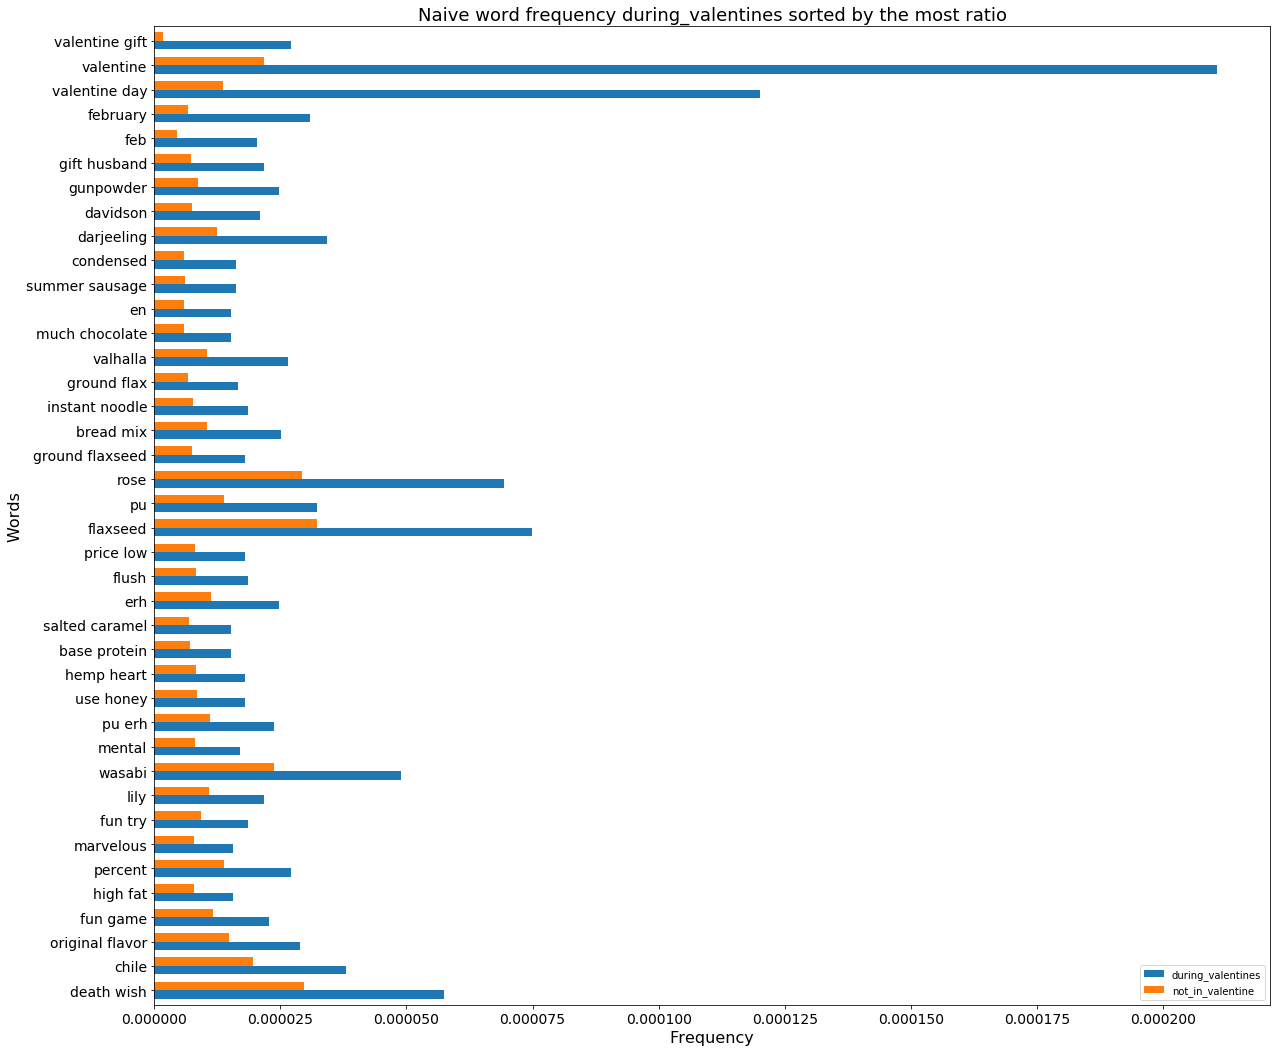

In [85]:
VALENTINE_DATE_2016 = pd.datetime(2016, VALENTINE_DATE.month, VALENTINE_DATE.day)
t1_v = time.time()
naive_word_freq_and_plot(unique_reviews, VALENTINE_DATE_2016, VALENTINE_DURATION, VALENTINE_COLUMNS, NUM_TOP_WORDS, min_count_year=30)
t2_v = time.time()

We can see the downsides of using the naive techinque. This computation has taken twenty minutes to finish on 4 cores, this can seem very small for big data analysis but it is slower than the next approach we will present by a factor of more than 40; this is quite significant. Additionnally as explained above, we really benefit from a faster execution because the process is to loop between computation and analysis to extract the best parameters. Now concerning the result, we can see that there are 4 words (n-grams to be precise) in the top 6 that are highly related to Valentine. This is promising but the proportion of unrelated content is high. For example for the rest of this top 6 we have _feb_ and _february_, this is because we have a naive approach, that does not at all filter the products before comparing the frequencies. Of course that if a word such as february appears in some reviews it will most likely be during that month, but it is the kind of effect we are looking for. This effect is too general. Indeed, "February" is not a trend. Also, except for _much chocolate_, _rose_ or _lily_ for example, all the rest of the words are not meaningful at all. We should manage to increase well enough the relevance ratio so as to not have those kind of term in the top. To achieve this, we will only keep the  products popular in this time window. What we want to avoid are to general effects such as February and to precise ones such as Valhalla given that we want to know if somethings affects those 20 days during the month of february periodically (every year).


Because the new technique is faster, we can also take more than one year into account easily. So what we do is to gather words from all the years in two different sets (one belonging to the time window and one outside the time window; both across the years) and compute the word frequencies from that. A different approach and possibly more robust approach would be to compute the frequencies separately for every year and the aggregate them. However, summing the count across the years gives fairly good results so we stick to it.

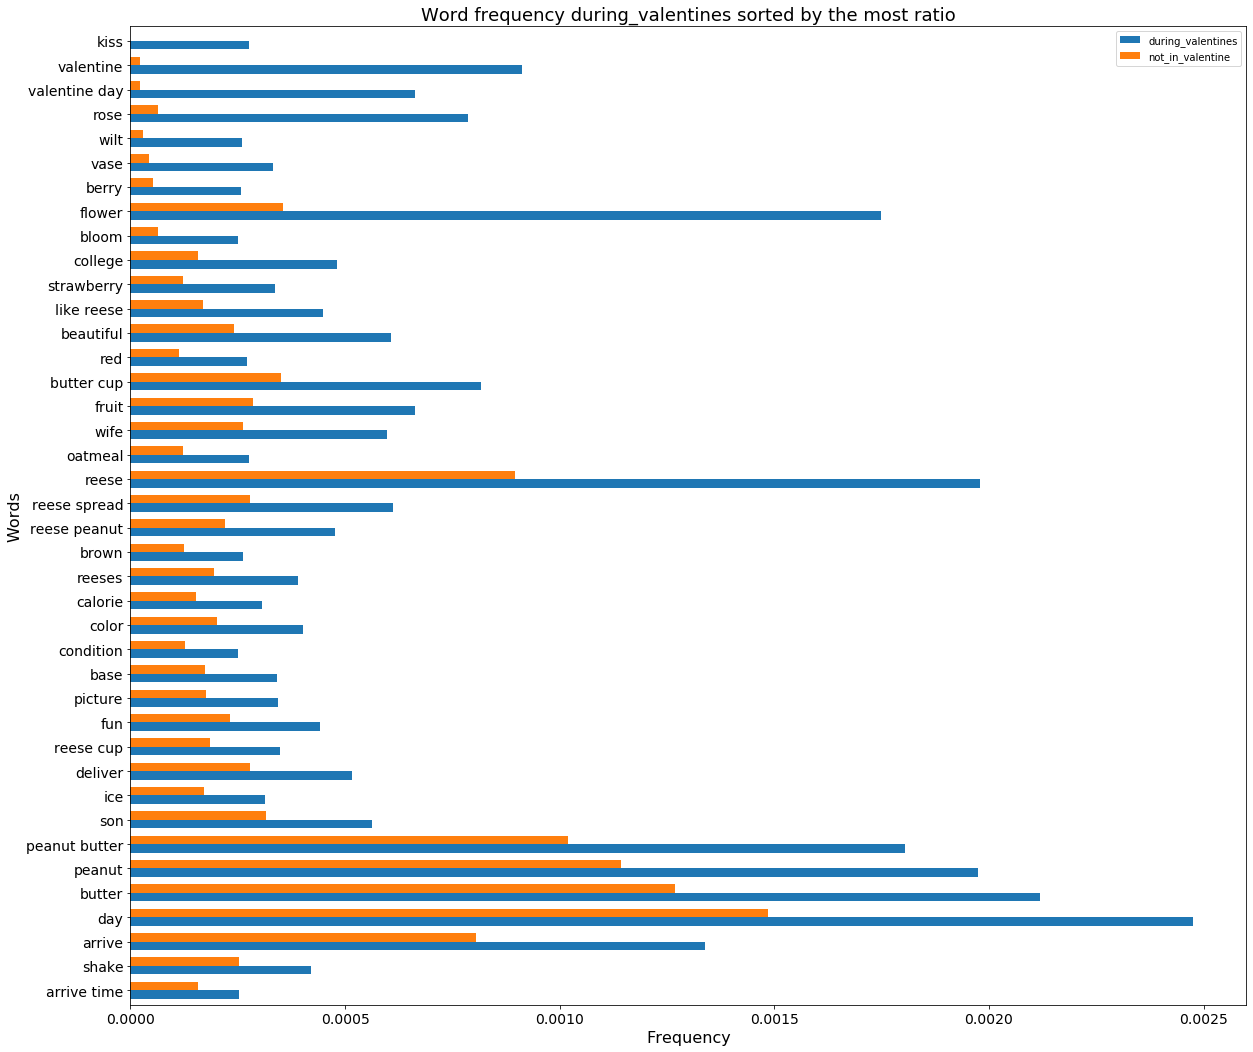

In [110]:
t3_v = time.time()
valentine_activity, valentine_reviews = word_freq_and_plot(unique_reviews, reviews_per_week_filled,\
                                                           VALENTINE_DATE, VALENTINE_DURATION, VALENTINE_COLUMNS, NUM_TOP_WORDS,\
                                                           min_count_year=10)
t4_v = time.time()

In [43]:
print(f'Computed in {str(datetime.timedelta(seconds=(t4_v - t3_v)))}')

Computed in 0:00:21.003768


In [66]:
val = valentine_activity[['asin']].merge(meta, on='asin')
val[val['title'].str.lower().str.contains('reese')]

,asin,category,description,title,brand,rank,also_view,main_cat,price,also_buy,date,feature
34,B00998PV7Q,"Grocery & Gourmet Food||Jams, Jellies & Sweet Spreads||Chocolate & Hazelnut Spreads",REESE'S Peanut Butter Chocolate Spread with SNACKSTERS Graham Dippers are the perfect snack for ...,"REESE'S Spreads, Peanut Butter Chocolate with SNACKSTERS Graham Dippers, 1.8 Ounce Package (Pack...",Reese's,"334,356inGroceryGourmetFood(",B00P8AR0VE||B00S0ABRNQ||B005CUM8FI||B0004MXX6W||B001UUEWIA||B06XFSP8NS||B00I3303L2,Grocery,NaN,,NaT,
58,B00S0ABRNQ,"Grocery & Gourmet Food||Jams, Jellies & Sweet Spreads||Nut & Seed Butters||Peanut Butter",This peanut butter chocolate spread is the perfect addition to breakfast or any snack Reese's Sp...,"Reese's Spreads Peanut Butter Chocolate Jar, 13oz",Reese's,"78,905inGroceryGourmetFood(",B00P8AR0VE||B00Q0CHDH0||B00I3303L2||B00LWZZKP2||B005CUM8FI||B00E8LMAVY||B0004MXX6W||B0768M5KHQ||...,Grocery,NaN,B00E8LMAVY||B00P8AR0VE||B00IC4R0Z4||B01GVH8NXG||B0004MXX6W||B00D5VL5QE||B06XFSP8NS||B001UUEWIA||...,NaT,


Many words are related to Reese, which does make sense since Reese is a huge seller during these events:

> *&ldquo;Additionally, the Reese's brand accounts for over 47% of all seasonal sales within the U.S. convenience store channel, including the top two items in the largest four commercial seasons: Valentine's, Easter, Halloween, & Christmas. As a comparison, the next largest brand accounts for only 10% of seasonal sales.&rdquo;* [(source)](https://en.wikipedia.org/wiki/Reese%27s_Peanut_Butter_Cups)

However it's a little weird that peanut butter is so high, butter cups are very popular during Valentine's but we wouldn't think of peanut butter to be so high. Let's try to understand what's going on by finding the `asin` of the peanut butter product and plotting its time series.

In [44]:
pd.DataFrame(valentine_reviews[valentine_reviews['reviewText'].str.contains('peanut butter')].groupby('asin').size()).T

asin,B0000D9169,B0000D916Y,B0029JFZP0,B004JM3VF6,B00998PV7Q,B00FPNVTUW,B00LLILH98,B00QFR9X8W,B00S0ABRNQ,B00SBRGG84
0,2,2,1,2,7,18,2,2,260,10


The peanut butter phenomena is strongly assosciated to the product _B00S0ABRNQ_ let's see what it is

In [57]:
meta[['description', 'title']][meta['asin'] == "B00S0ABRNQ"]

,description,title
229708,This peanut butter chocolate spread is the perfect addition to breakfast or any snack Reese's Sp...,"Reese's Spreads Peanut Butter Chocolate Jar, 13oz"


Ah! It's a Reese product, so it isn't unreasonable that it's popular during Valentine's but we can still try to go a little deeper and really see what's going on. It's still strange that peanut butter is so high.

In [59]:
plot_time_series(["B00S0ABRNQ"], "reese-time-series", "Reese peanut butter")

/home/lulu/EPFL/MA1/Ada/Project/milestone-3-plots/reese-time-series.html

As you can see it has two big peaks, one of which is during valentine, which strongly impacts our word frequency. However it isn't popular every year, only in 2015 and not only during Valentine's. Why is that?

After looking at the reviews, it turns out that Reese did a commercial operation at that time.

In [72]:
valentine_reviews[valentine_reviews['reviewText'].str.contains('@influenster')]

,asin,reviewTime,reviewText,summary
71842,B00998PV7Q,2015-02-10,I received #ReesesSpreads for FREE from @influenster and I am SO excited to have tried this prod...,Spreading the love!
109691,B00S0ABRNQ,2015-02-23,"As a family that uses Nutella frequently, this jar of Reese's Spreads went extremely fast. A fa...","Just like the candy, only easier to combine with other foods!"
109736,B00S0ABRNQ,2015-02-20,"I had the opportunity to try a jar of Reese's Spread Peanut Butter Chocolate spread for free, an...",So Delicious!!
109790,B00S0ABRNQ,2015-02-19,I got #ReesesSpreads in the mail for FREE thanks to @influenster! This opinion is mine. I really...,I really enjoyed this spread and I think it tastes just like ...
109893,B00S0ABRNQ,2015-02-18,I received a free jar of Reese's Spread from Influenster and it was actually better than I expec...,Loved the Reese's Spreads Peanut Butter Chocolate!
109968,B00S0ABRNQ,2015-02-17,So Good I can't resist it!\n #ReesesSpreads #Reeses @influenster,Five Stars
110058,B00S0ABRNQ,2015-02-17,I recieved this complementary from @influenster and might I say YUMMY!! This exactly what is say...,I would definitely recommend this for any Reese's lover
110177,B00S0ABRNQ,2015-02-17,I had the oportunity to review this great product complimentary of the influenster team. My chil...,Reese's Spread is Amazing!!


Indeed some of these people got Reese products for free from Influenster, for fun we can also notice that many people did unboxings on youtube: https://www.youtube.com/results?search_query=influenster+reese+voxbox. This product could be considered as legit and not an outlier, however our analysis isn't very robust if it suffers so much from a one-time commercial operation. So we added an additional criteria to penalize this factor. We want that the products we look at are somewhat popular during all Valentine's to do that we require that the median over all years is higher than a threshold. Let's see what we get then!

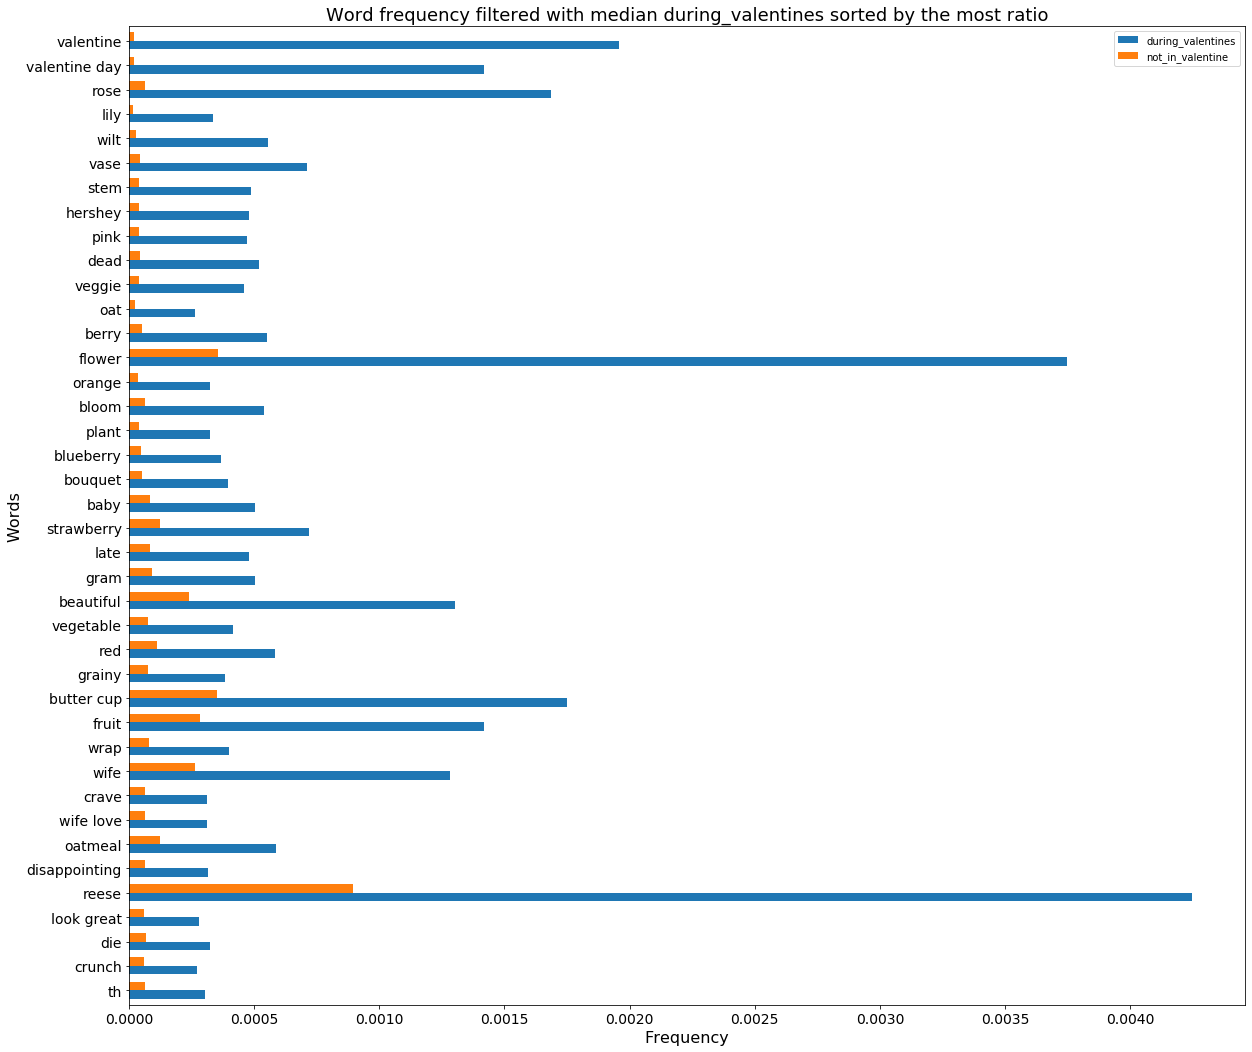

In [46]:
t5_v = time.time()
valentine_activity, valentine_reviews = word_freq_and_plot_median(unique_reviews, reviews_per_week_filled,\
                                                           VALENTINE_DATE, VALENTINE_DURATION, VALENTINE_COLUMNS, NUM_TOP_WORDS,\
                                                           min_median_wc=5, min_count_year=10)
t6_v = time.time()

Now that we have the final word extraction scheme, we can dive into the theme analysis of this particular event and thus see what influence it has on the user. We can extract the main themes attached to Valentine, let's begin by the following words: rose, lily, wilt, vase, stem, pink, flower, orange, red, bloom, plant, bouquet. This corresponds to a theme of flowers and plants. Flowers names along with their color, especially roses and lilies. We can gain more insights from the species of flowers, the fact that the majority of flowers are those is not a coincidence:

- Themes linked to lily:
 - Royalty and regal bearing
 - Motherhood and fertility
 - Purity and the beauty of youth
 - Passion and drive
 - Renewal and rebirth
- Themes linked to roses:
 - Love
 - Beauty
 - Passion
 - Devotion
 - Sensuality
 - Timelessness
 
_Taken from https://www.flowermeaning.com/_

As we can see, this theme is much more than flowers and plants, it represents romance, passion, commitment, in other words true love. This is really close to the idea one would have of Valentine's day. However, when you think about Valentine you may also think about less 'pure and timless' topics such as chocolate and other kind of sweets. We can see that this topic is also represented here; we have reese as before, butter cup, which may be strongly related to reese and hershey, another famous brand of chocolate. Another surprising group sticks out: berry, blueberry, fruit, strawberry. That has nothing to do with Valentine from our perpective but after researching a bit on internet, this is apparently a thing to give fruit basket to your companion so it may appear because of that.  
There's a last category we want to point out: disappointing, die and dead. Not that we think those words are, in their definition, related to Valentine but in reality they appear because of the first theme. We can see that by reading reviews that contains them:

**Fausse bob:**
Before starting to inquire about the two main events we are interested in, i.e Christmas and Valentine day. We first make a little detour with some other "events" that we discovered by chance using the functions described above. The idea is to loop over every 14 days during a year and plot the word frequencies for that time window. 

In other words, we try to grasp how an event is present and thus plot the comparison of the word frequencies during the event and during the rest of the year. Values appear in the bar plot in the in decreasing order according to their biggest ratio.

In [60]:
mask_disap = (valentine_reviews['reviewText']+valentine_reviews['summary']).str.contains('disappointing')
mask_dead  = (valentine_reviews['reviewText']+valentine_reviews['summary']).str.contains('dead')
valentine_reviews[(mask_disap) | (mask_dead)][['reviewText', 'summary']].head(11)

,reviewText,summary
527,"It was a warm, sunny Florida morning at our used car dealership. Me and my partner Terry Bruce (...",INTERNAL ARMAGEDDON
11733,For the first time very disappointed. All was melted together and had to be eaten with a teaspoo...,disappointing Lindt chocolate.
12836,I ordered these in February for my mother's birthday in New York. The delivery person never rang...,Not What I Expected
12844,"Worst flowers I've ever seen, i had to get replacements from the grocery store and of course tho...","WORST AMAZON PURCHASE EVER, might as well just throw your cash in the fire"
12845,Sent this arrangement to a family member and they arrived 3 days ago wilted and turning brown. ...,"Arrived wilted, fully dead in 3 days!"
12846,"my wife was on a business trip I sent her the flowers, as soon as she opened them she noticed th...",not happy at all
12847,I would not recomend,Most were dead
12850,"When they arrived at my mothers place, there were only 9 rose stems and 1 of them looked dead to...",Only 9 roses shipped.
14449,Very poor quality. They were delivered the Friday before Valentine's Day and were dead by Sunday,One Star
15046,"The roses turned out great, wife loved them. The lilies were the only problem. Only one bloome...","The roses turned out great, wife loved them"


It's indeed true for the majority of the reviews, flower is thus a predominant theme of this period and that corresponds to the reality.  
We can see that using this technique on the dataset, we can find all themes related to Valentine and grasp insights about what happens at that moment, we will continue this analysis with two other events: Christmas and Easter. From now on we will only use the more complete approaches where we filter the products at first.

#### Christmas

Here, we choose our windows to be approximately the last three weeks of december from the year of 2014 until and included 2017.

Taking the ratio between the frequencies bring conclusive results. The goal was to take a period during the year and try to see if a particular event influences the former. Here, we take the month a december and try to show how Christmas is present during it. We can try to manually extract topics from the plot:

- Christmas : "Christmas", "Christmas gift", "Holiday", "Present", "Gift", "Great gift", "Package", "Pleased", "Thank", "Recieve"

- Relatives : "Family", "Son", "Everyone", "Friend"

- Cooking and baking : "Waffle", "Mix", "Pancake", "Cooky"

- Food gift : "Basket", "Nut", "Mix", "Tray"


**delta=(15,6)**

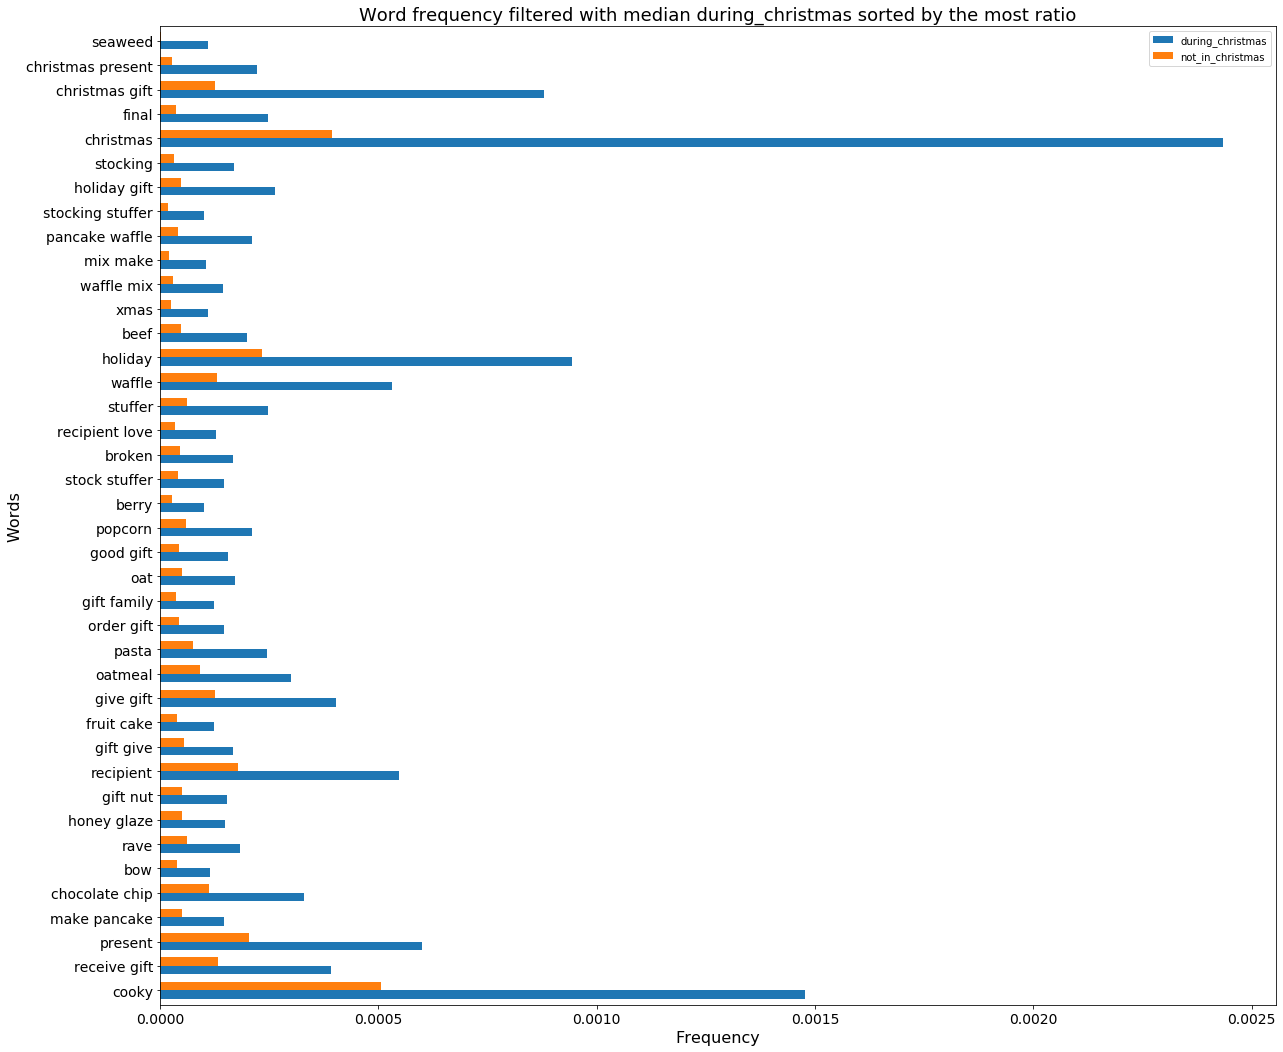

In [112]:
christmas_activity, christmas_reviews = word_freq_and_plot(unique_reviews, reviews_per_week_filled,\
                                                           CHRISTMAS_DATE, CHRISTMAS_DURATION, CHRISTMAS_COLUMNS, NUM_TOP_WORDS,\
                                                           min_count_year=10)

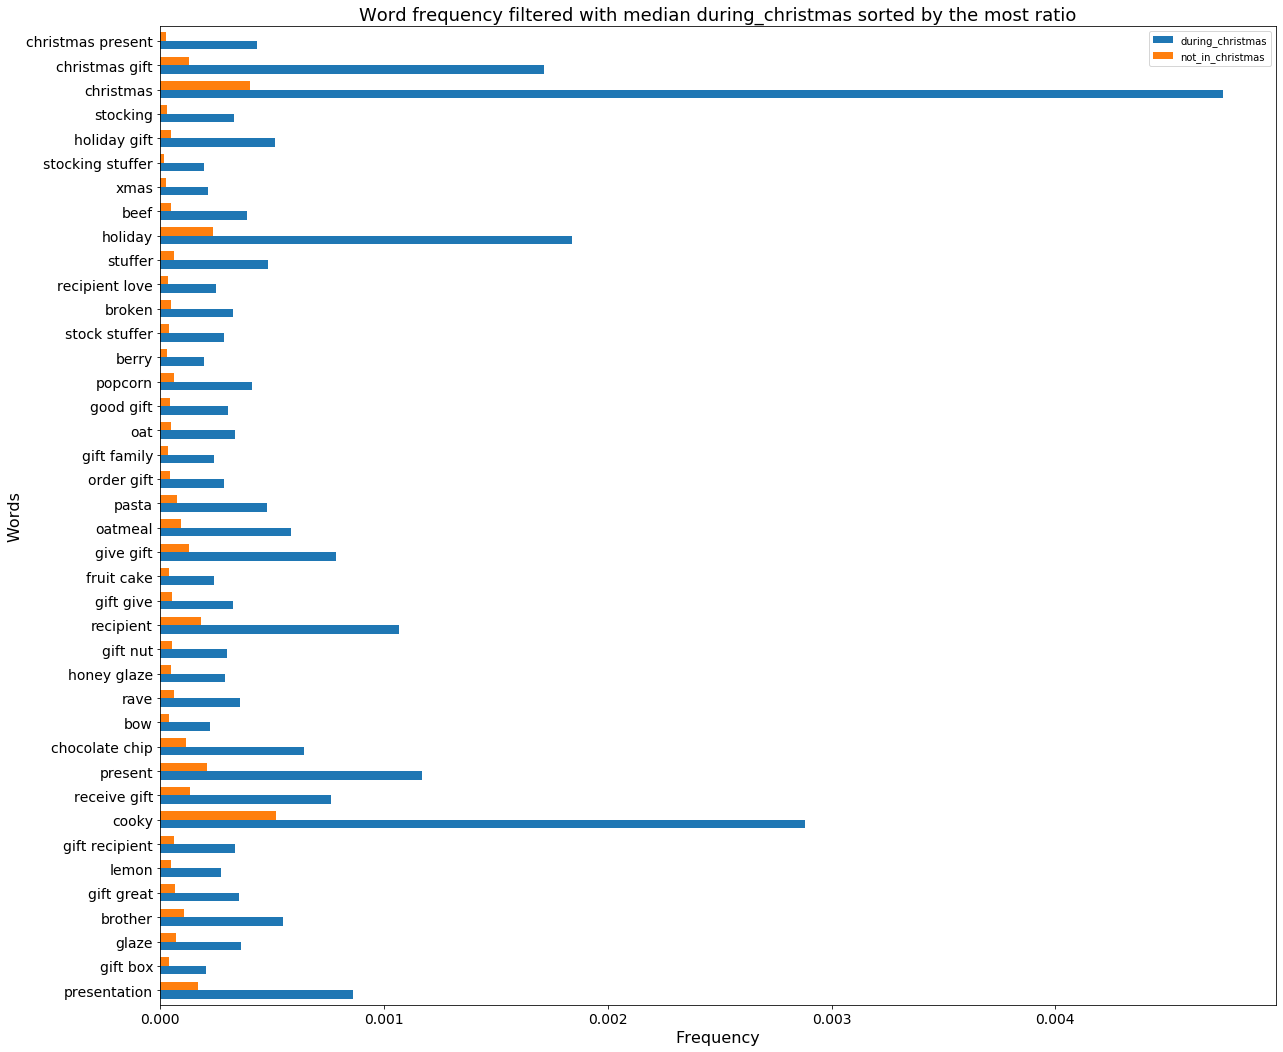

In [113]:
christmas_activity, christmas_reviews = word_freq_and_plot_median(unique_reviews, reviews_per_week_filled,\
                                                           CHRISTMAS_DATE, CHRISTMAS_DURATION, CHRISTMAS_COLUMNS, NUM_TOP_WORDS,\
                                                            min_median_wc=5, min_count_year=10)

The four main topics extracted here are all strongly related to Christmas. However, one should be careful about the conclusions regarding those topics since the one about cooking and baking is also related to winter. On top of that, we can see that some words might have more that one meaning. For example, "mix" can relate to mixing, i.e butter, flour, and eggs concerning baking, or to a mix of nuts as a gift. In that case, we're lucky since both meanings concern Christmas, but it might not be the case and in this situation we may interpret the word towards the direction of the event and then include a bias, whereas, in fact, it relates to something else.

Recall that the word count frequency from the plot above is made from the reviews from the most popular products in the event. Therefore, we also print the title of some of the most popular products in order to see if they relate to Christmas.

In [51]:
christmas_asins = christmas_activity.sort_values(by='deltasub', ascending=False).head(12)['asin'].tolist()
christmas_prod = meta[meta['asin'].isin(christmas_asins)]
christmas_prod_title = christmas_prod['title'].tolist()
pretty_print(christmas_prod_title)

("David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - "
 'Christmas, Holiday & Corporate Food Tin - Idea For Men & Women - Certified '
 'Kosher - 2 lb.')

("David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - "
 'Christmas, Holiday & Corporate Food Tin - Idea For Men & Women - Certified '
 'Kosher - 2lb')

('San Francisco Bay OneCup, French Roast, 80 Count- Single Serve Coffee, '
 'Compatible with Keurig K-cup Brewers')

('Holiday Nuts Gift Basket - Gourmet Food Gifts Prime Delivery - Christmas, '
 'Mothers & Fathers Day Fruit Nut Gift Box, Assortment Tray - Birthday, '
 'Sympathy, Get Well, Woman & Families- Hula Delights')

('30-count Top Brand Coffee, Tea, Cider, Hot Cocoa and Cappuccino Variety '
 'Sampler Pack, Single-Serve Cups for Keurig-Compatible Brewers')

'Surge Citrus Flavored Soda 16fl oz. 12 cans'

('Six Grain Cinnamon Pancake and Waffle Mix by Birch Benders, Made with '
 'Organic Ingredients, Whole Grain, Non-GMO, 16oz')

('Organic

We can see that it indeed makes sense, since it is mostly about gift baskets, assortment trays and pancake mix. However, we are prone to non-related events products. Indeed, as we can see there is coffee and soda (one could argue that people tend to offer coffee for Christmas, indeed there is a "10 Amazing Blends cups package"). The point here is that our model try to capture words from popular products during a time window during a year. Therefore, as seen before with the Arty water and Kasandrinos oil cases, product launches or marketing boost might unexpectedly affect the results we get. 

The next question we should ask ourselves is how much more present those products are during the event than during the rest of the year ? Therefore, we might as well investigate about the increase, in the number of reviews, of those products during the event :

In [54]:
christmas_activity.sort_values(by='deltasub', ascending=False)

,asin,median in year,mean in period,deltasub,deltaratio,event_start_date
1981,B00M2OGS08,1.0,211.333333,211.333333,211.333333,2014-12-10
1882,B00KCCKV8W,15.5,226.333333,210.833333,14.602151,2016-12-10
1882,B00KCCKV8W,4.0,112.333333,108.333333,28.083333,2015-12-10
2633,B015G9SH6I,1.0,66.333333,66.333333,66.333333,2015-12-10
2554,B0131A6FJA,1.0,54.000000,54.000000,54.000000,2016-12-10
...,...,...,...,...,...,...
1536,B00F2GW4J2,1.0,10.666667,9.666667,10.666667,2014-12-10
1874,B00K8AHSQG,0.5,9.000000,8.500000,18.000000,2014-12-10
1875,B00K8APSMC,0.5,7.666667,7.166667,15.333333,2014-12-10
3021,B01E89YPDQ,0.5,6.000000,5.500000,12.000000,2016-12-10


In the table sorted descendingly by the difference between the mean of the number of review for a product for the given year and the median for the rest of the year, we are interested in two measures 'deltasub' and 'deltaratio'. 'deltasub is simply the difference between the mean of the number of reviews for a given product for a given year during the event and the median during the rest of the year and the 'deltaratio' is the ratio.

The idea is to gather products either if they have a big difference or a big ratio. Thus, top products will generally have both, but bottom ones that have a really small median and a rather small mean but a big ratio will still appear. Hence, we try to be as fair as we can concerning the products we allow to be in the list.

In order to have a more robust approach, we use below bayesian structural time series to provide more evidence about whether a product was affected or not by an event and thus whether or not the word frequency from which we infer the topics caracterise our time window, hence if our event really affects the latter.

#### Easter

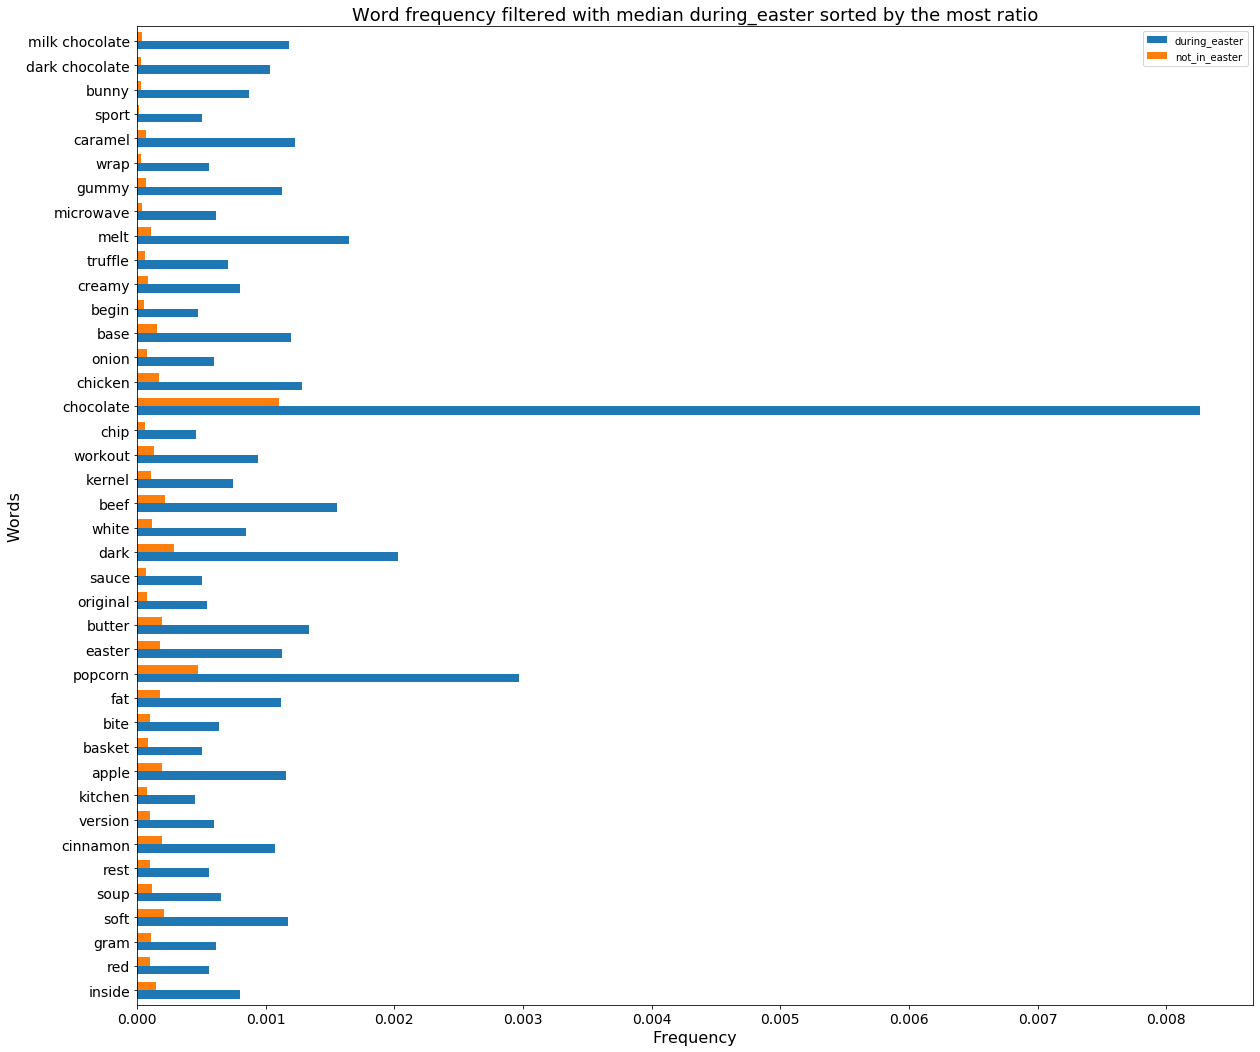

In [140]:
easter_activity, easter_reviews = word_freq_and_plot_median(unique_reviews, reviews_per_week_filled,\
                                                           EASTER_DATE, EASTER_DURATION, EASTER_COLUMNS, NUM_TOP_WORDS,\
                                                           min_median_wc=3, min_count_year=8)

#### First anomaly : Arty water

We first found small anomaly, during June 2014 some weird words became suddenly popular, did a big product came out ?! Let's see what these words are.

,asin,median in year,mean in period,deltasub,deltaratio,event_start_date
745,B00474D0HK,1.0,7.0,6.0,7.000000,2014-06-04
1241,B00AQIT90S,1.0,5.5,5.5,5.500000,2014-06-04
1271,B00B93M30M,1.0,11.0,10.0,11.000000,2014-06-04
1362,B00CIVY3G6,1.0,6.0,5.0,6.000000,2014-06-04
1613,B00FZZPTPG,1.0,8.0,8.0,8.000000,2014-06-04
1655,B00GW3KSPQ,7.0,71.5,64.5,10.214286,2014-06-04
1657,B00GX2VBKW,1.0,7.5,6.5,7.500000,2014-06-04
1659,B00GZJMR9W,1.0,5.5,4.5,5.500000,2014-06-04
1662,B00H29LREA,1.0,7.5,6.5,7.500000,2014-06-04
1841,B00JW3G3ZC,1.0,12.5,12.5,12.500000,2014-06-04


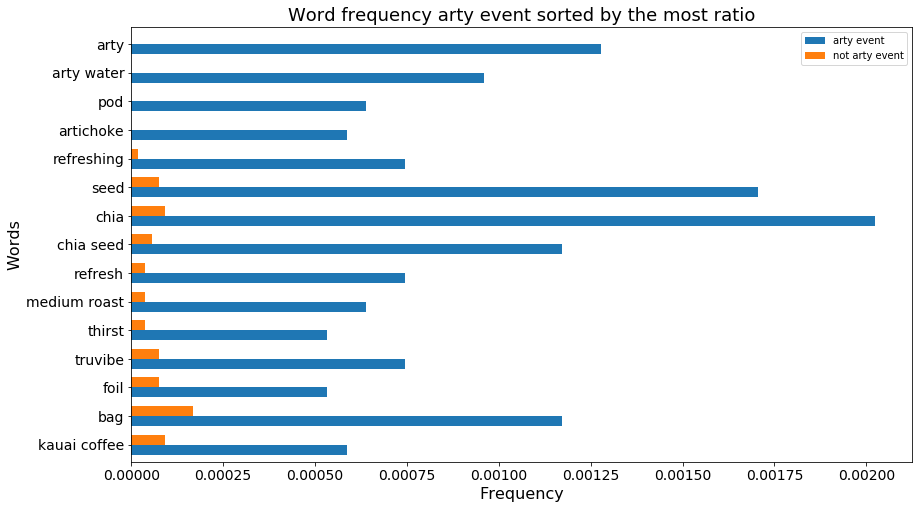

In [61]:
EVENT_DATE = pd.datetime(2014,6,4)
EVENT_DURATION = pd.Timedelta('14 days')
EVENT_COLUMNS = ['arty event', 'not arty event'] 
_, event_reviews = word_freq_and_plot(unique_reviews, reviews_per_week_filled, EVENT_DATE, EVENT_DURATION, EVENT_COLUMNS, 15, end_year=2014, figsize=(14,8))

The real outliers are *arty, refresh, arty water, artichoke, thirst* the frequency isn't that big but these words were basically never used outside of this period so it's still interesting to take a look at what this is about. Looks they are all about some water from the brand Arty, let's see what they say:

In [66]:
event_reviews[event_reviews["reviewText"].str.contains("Arty\W")]

,asin,reviewTime,reviewText,summary
4492,B00JW3G3ZC,2014-06-11,Arty Water has such a great taste and it's so refreshing during the day when I need a pick me up!,Great Taste!
4493,B00JW3G3ZC,2014-06-11,"Arty water settled my stomach when I had the stomach flu. It has also helped with my heartburn,...",Amazing - just like having an artichoke
4557,B00JW3G3ZC,2014-06-17,"I Met a young, professional gentleman by the name of Anthony Fabio. He presented the concept be...",TWO THUMBS UP!
4558,B00JW3G3ZC,2014-06-17,The minute I heard about Arty water I had to try it! I love everything about this water includin...,LONG LIVE ARTY
4560,B00JW3G3ZC,2014-06-17,"Arty Water is a great way to get your green smoothie ""fix"" if you're in a rush and can't make yo...",For green smoothie enthusiaants
4561,B00JW3G3ZC,2014-06-16,My first taste of Arty completely took me by surprise! Not being a huge fan of artichokes (exce...,Arty Will Surprise You!
4562,B00JW3G3ZC,2014-06-16,Arty water is refreshing drink with a mildly sweet and tangy flavor. It is perfect to drink alo...,Wonderful with breakfast
4563,B00JW3G3ZC,2014-06-15,My friend told me about Arty Water and I am so glad she did. I am always looking for something t...,So glad!
4566,B00JW3G3ZC,2014-06-14,"Love Arty water, refreshing and full of nutrients. This will definitely be a staple in our hous...","Refeshing and natural, full of benefits."
4570,B00JW3G3ZC,2014-06-13,After reading that Arty Water was a finalist by the Natural Product Awards as the Best New Produ...,Tasty and refreshing!


This is quite strange they are all about the same product as you can see with the `asin`. Let's see what the product is and what is its time series to see what all the fuss is about.

In [67]:
meta[meta["asin"]=="B00JW3G3ZC"] # Indeed Arty water, namely 'pure natural artichoke water'

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,date,feature
193649,Grocery & Gourmet Food||Beverages,"ARTY water is the first vegetable beverage with a great fruit taste. Taking fresh artichokes, a ...","Arty Pure Natural Artichoke Water, 8oz (Pack of 4)",Arty Water,"352,460inGroceryGourmetFood(",,Grocery,NaN,B00JW3G3ZC,,NaT,


In [72]:
plot_time_series(["B00JW3G3ZC"], "test-arty", "Arty water time series") # Its time series

/home/flo/EPFL/Ada/Los-Moussaka-ADA/milestone-2-plots/test-arty.html

Very weird indeed, this product wasn't even on Amazon prior to this event and when it came out it got a lot of reviews and then basically no one talked about it. Now could these be fake reviews?! Seems conveniant to pay a few bucks to have a good start on the website and move on from there, since first reviews are very important as we saw in class. Let's take all the reviews that are during the peak.

In [73]:
reviews_arty = reviews[(reviews["asin"]=="B00JW3G3ZC") & (reviews["reviewTime"] <= "2014-06-29")]
reviews_arty

,stars,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,upvote
2910361,5,True,2014-06-11,A2QURM8T7H4HEY,B00JW3G3ZC,Lisa Kleypas,Arty Water has such a great taste and it's so refreshing during the day when I need a pick me up!,Great Taste!,0
2910362,5,False,2014-06-11,AGRXDY6384YPY,B00JW3G3ZC,Ilda Dabda,"Arty water settled my stomach when I had the stomach flu. It has also helped with my heartburn,...",Amazing - just like having an artichoke,6
2910363,5,False,2014-06-11,AGQVWUBE2US9J,B00JW3G3ZC,Anonymous,Amazing taste of both fruit and artichoke and lightly sweetened. Used for pre or post workout hy...,Love it!,12
2910396,5,True,2014-06-29,ALY33M4Q7R1NK,B00JW3G3ZC,son hoang nguyen,"After a week of drinking this refreshments drink, I am hooked. Been switching out coconut water ...",The next big thing!,0
2910397,5,False,2014-06-29,AMHCYSIAIUW0L,B00JW3G3ZC,Stephanie Azran,I was able to try Arty when it debuted in California and I was floored by how fresh and unique t...,Suprisingly refreshing,0
...,...,...,...,...,...,...,...,...,...
2910449,5,False,2014-06-11,A1P6RZYQ8T25O2,B00JW3G3ZC,Carol,"Refreshing, hydrating, healthy and simply delicious! Perfect to start and end my day, and an ""in...",Simply Delicious!,0
2910450,5,False,2014-06-11,A2OL9HP4FWREHA,B00JW3G3ZC,Lumpee L,I was curious about how an artichoke drink would taste and I was no disappointed. The taste is s...,Refreshing!,0
2910451,5,True,2014-06-11,A2IFE7M5QCP7G6,B00JW3G3ZC,jeanmarie m davis,"Arty water is a delicious way to quench thirst, hydrate and energize anytime. Getting enough hyd...",My go-to-water,7
2910452,5,True,2014-06-11,A2J6YKE7DFG6QT,B00JW3G3ZC,Polly Lail,Great tasting product. I will make this a staple in my home. My grandkids love the product and...,Refreshing and Natural,0


In [74]:
reviews_arty.groupby('stars').size() # Almost ALL the reviews are 5 stars

stars
4     3
5    58
dtype: int64

In [75]:
count = reviews_arty['reviewText'].str.contains('Arty').sum()
count/len(reviews_arty.index) # Half of them mention 'Arty'

0.47540983606557374

This is quite fishy most of them explicitly mention the brand's name which is in itself a bit weird and we can for example compare to the cookies from before. In the cookies reviews they almost never mentioned the brand's name. We can easily check that:

In [76]:
# Cookies that were popular's brand
meta['brand'][meta['asin'] == id_cookie].values[0]

NameError: name 'id_cookie' is not defined

In [ ]:
count = reviews_cookie['reviewText'].str.contains('David').sum()
count/len(reviews_cookie.index)

We can also see that they almost only give 5 stars but this isn't conclusive evidence since most of the rating are 5 stars anyway. But we read the reviews and selected 2 that are worth showing and give a good insight about them being fake.

In [77]:
review_1 = reviews_arty['reviewText'][reviews_arty['reviewText'].str.contains("!!!!!!!!!")].values[0]
review_2 = reviews_arty['reviewText'][reviews_arty['reviewText'].str.contains("Arty is crisp and not only perfect to quench your thirst")].values[0]

pprint.pprint(review_1)
print()
pprint.pprint(review_2)

('This water is wonderful!  I rather have this instead of the other drinks '
 "I've had in the past.  It is refreshing and unlike anything I ever tried "
 'before.  I am so glad to be introduced to this product.  Way to go Arty '
 'Water Company!!!!!!!!!!!!!!  I will tell my friends about this '
 'product!!!!!!!!!!!!!!!!!!!!!')

('My first taste of Arty completely took me by surprise!  Not being a huge fan '
 "of artichokes (except for when combined with cheese and butter), I wasn't "
 'sure what to expect, but I love the refreshing, light taste.  Other fruit '
 'and vegetable based waters can have a lingering aftertaste but Arty is crisp '
 'and not only perfect to quench your thirst after a killer workout, but also '
 'to give your body so many important vitamins and minerals.  I have tried it '
 'both cold and warm/room temp and I really loved it both ways - even after a '
 'sweat session, the room temp was delish (I cannot say the same for other '
 'waters, ahem - coconut water).  

These reviews are really over the top they represent everything a fake review would be from a basic marketing point of view.
1. They mention other waters that weren't as good while being extra careful at never mentioning other brands.
2. Never talk about other brands but they mention Arty water (and not forgetting to capitalize the first letter)
3. They said they weren't convinced at first but as soon as they tried it the gates of Valhalla opened to them! :D
4. The first one says he will tell about it to all of his friends, while the second is now a transcended human being he does 'KILLER workouts' and has all the vitamins and minerals he could ever wish for.

These are all basic points a fake review would have. They are supposed to represent the buyer not being sure about whether he should buy it or not, he looks at reviews and relates to the reviewers and give it a shot.

#### Second anomaly : Kasandrinos olive oil

Let's try with the second one. If we choose as our time window two weeks at the beginning of november we get interesting results. 

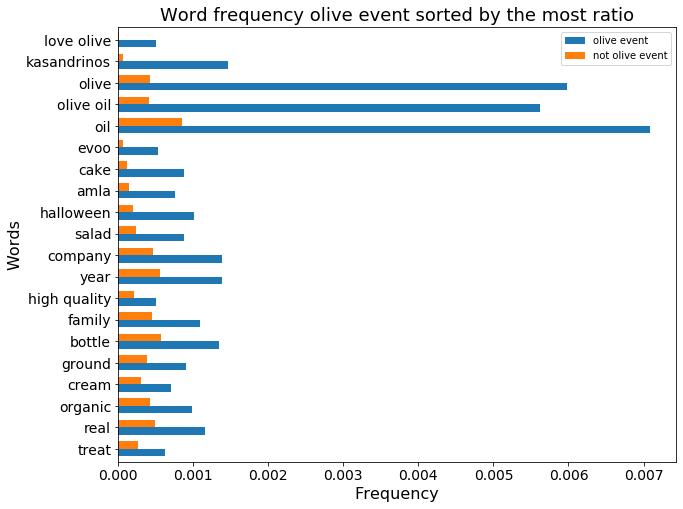

In [78]:
EVENT_DATE = pd.datetime(2017, 11, 5)
EVENT_DURATION = pd.Timedelta('14 days')
EVENT_COLUMNS = ['olive event', 'not olive event'] 
_, event_reviews_olive = word_freq_and_plot(unique_reviews, reviews_per_week_filled, EVENT_DATE, EVENT_DURATION, EVENT_COLUMNS, 20, figsize=(10,8), end_year=2017)

Apparently, people are fond of olive oil, which seems a bit peculiar since it is in november (one could have argued that if it was in summer maybe that could be easily explained). So let's choose the same time window but a year before.

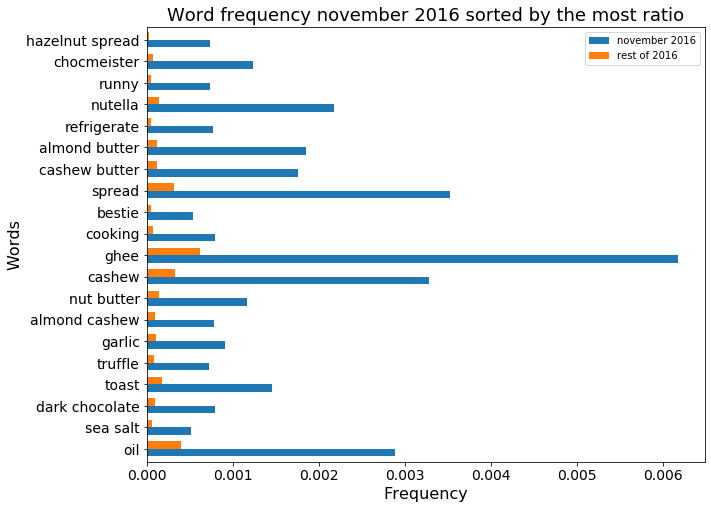

In [79]:
EVENT_DATE = pd.datetime(2016, 11, 5)
EVENT_DURATION = pd.Timedelta('14 days')
EVENT_COLUMNS = ['november 2016', 'rest of 2016'] 
_, _ = word_freq_and_plot(unique_reviews, reviews_per_week_filled, EVENT_DATE, EVENT_DURATION, EVENT_COLUMNS, 20, figsize=(10,8), end_year=2016)

Indeed, as expected olive is not as popular as it is in 2017 and it seems to concern a brand of olive oil whose name is "kasandrinos" and if we display the reviews we directly get that it basically only concerns one products whose asin is 'B01GIW8STI'. So let's plot its number of reviews over time :

In [82]:
plot_time_series(['B01GIW8STI'], 'kasandrinos_olive', 'kasandrinos_olive')

/home/flo/EPFL/Ada/Los-Moussaka-ADA/milestone-2-plots/kasandrinos_olive.html

There seems to be a huge spike in the lifetime of this product and if we look closer at the reviews we can see that some people are talking about a podcast whose name is balanced bites and whose coauthor is Diane Sanfillippo. We suspect that the Kasandrinos house paid several podcasts and websites (maybe including amazon) to advertise their product. Indeed, we notice that not only balanced bites is mentioned in the reviews, but there's also Dr. Michael Greger with Nutritionfacts.org and biophysicist Sarah Ballantyne a.k.a 'The Paleo Mom' and so forth. Moreover, 'coincidentally' the kasandrinos olive oil is on the Balanced Bites online shop. Below we show two comments concerning Balanced Bites :

In [83]:
podcast_reviews = event_reviews_olive[event_reviews_olive['reviewText'].str.contains('oil|olive|oil', case=False)\
                                     & event_reviews_olive['reviewText'].str.contains('balanced bites', case=False)].loc[:,'reviewText'].to_numpy()

for r in podcast_reviews:
    pprint.pprint(r)
    print()

('Love, love, LOVE this olive oil! Such a delicious flavor and great to cook '
 'with or add as a topping. I heard of Kasandrinos after listening to the '
 'Balanced Bites podcast and was immediately interested because of their '
 'family business and sustainability. So happy I found them... I will be a '
 'customer for life!')

('I have been listening to the Balanced Bites Podcast and following Diane San '
 'Filippo for years and never actually tried the Kasandrinos Olive Oil which '
 'she refers to, raves about and recommends as the only olive oil to use. '
 '(because its amazing) I was at a friends house last weekend and she had a '
 'bottle and I got to try it and I was in olive heaven. I tasted a teaspoon '
 'and went back for a tablespoon.  Its smooth, creamy, lemony, and rich and '
 'has the pure olive taste that Mediterranean food is known for. I cannot wait '
 'to purchase my own and give it away as Christmas gifts this holiday season, '
 'because who doesnt LOVE a good gift?'

Comments are quite funny since reviewers seem to be really in love with that olive oil. Indeed when quoting from the reviews above **"I was at a friends house last weekend and she had a bottle and I got to try it and I was in olive heaven. I tasted a teaspoon and went back for a tablespoon."**

<figure style="display: block;
  margin-left: auto;
  margin-right: auto;
  width: 50%;">
    <img src="https://media.giphy.com/media/33E7VIA7GWuwxLpuNu/giphy.gif">
    <figcaption><em style="font-size: 20px;">We later found unseen footage of this person drinking liters of olive oil from the neck, this is what we found<br>Source: <a href="https://www.youtube.com/watch?v=DSRSgMp5X1w">Christina Aguilera - Accelerate</a></em></figcaption>
</figure> 

In [ ]:
#### Thanksgiving

0.00032116991494350085


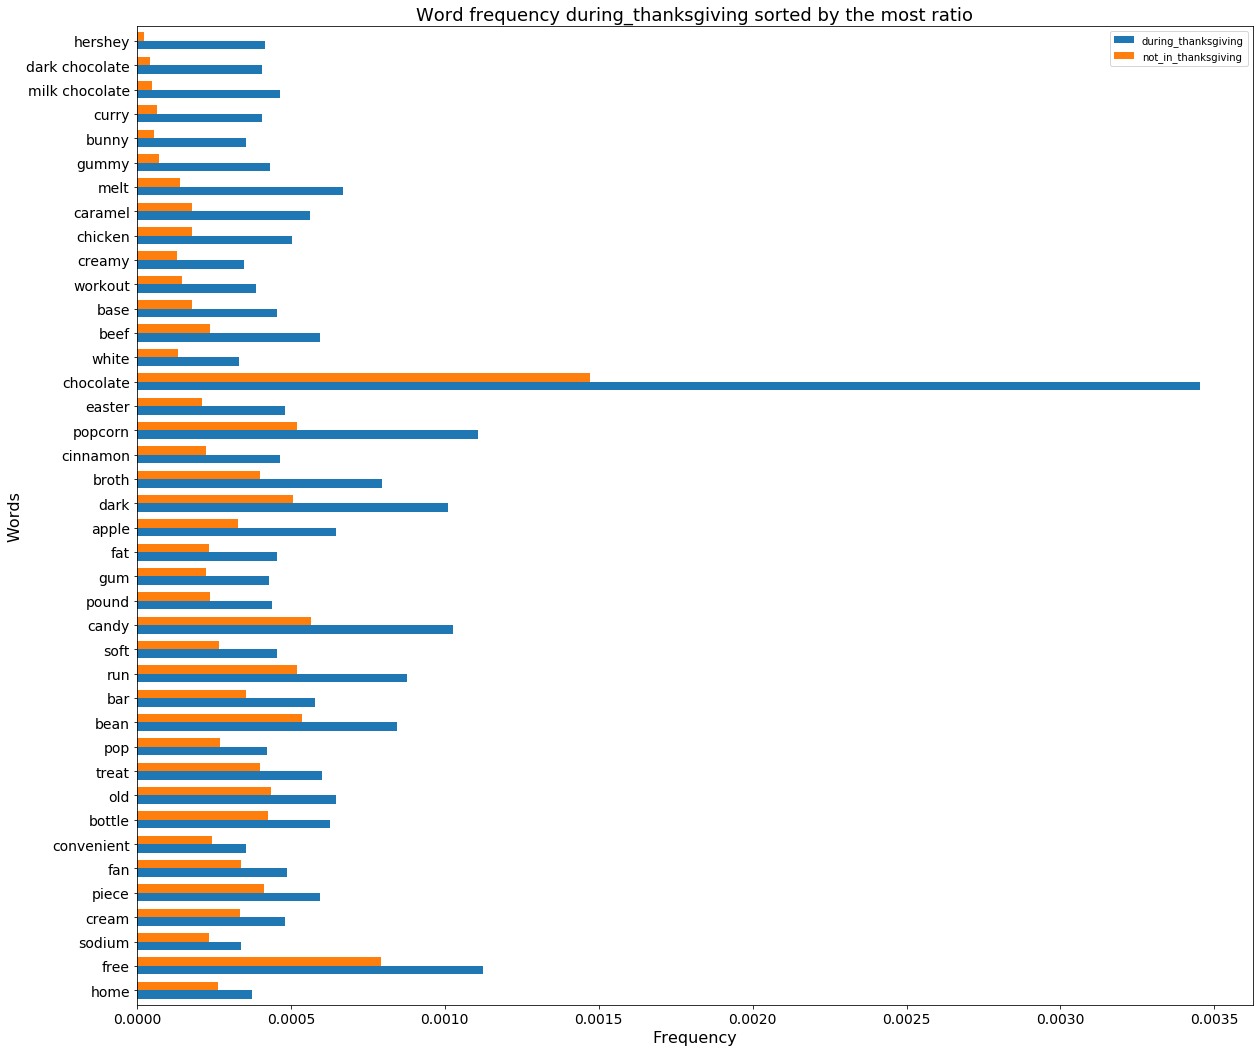

In [66]:
thanksgiving_activity, thanksgiving_reviews = word_freq_and_plot(unique_reviews, reviews_per_week_filled,\
                                                           THANKSGIVING_DATE, THANKSGIVING_DURATION, THANKSGIVING_COLUMNS, NUM_TOP_WORDS)

In [ ]:
kabloom_asins = meta[meta['brand'] == 'KaBloom'].loc[:,'asin'].to_numpy()
kabloom_asins_activity = pd.DataFrame(reviews[reviews['asin'].isin(kabloom_asins)].groupby(by='asin')['asin'].count().rename('count'))
kabloom_asins_activity.sort_values(by='count', ascending=False).head(30)

In [41]:
valentine_products = valentine_activity.merge(meta, on='asin')
sorted_valentine_products = valentine_products.sort_values(by='delta', ascending=False)#.head(50)

In [49]:
sorted_valentine_products[sorted_valentine_products['brand'] == "KaBloom"]

,asin,median in year,mean in period,delta,event_start_date,category,description,title,brand,rank,main_cat,price,date
15,B00J5H346Q,1.0,48.0,47.0,2017-02-05,Grocery & Gourmet Food||Fresh Flowers & Live Indoor Plants||Fresh Cut Flowers||Roses,"A timeless, romantic classic, this bouquet of fresh cut red roses is sure to melt the heart of w...","Kabloom The Romantic Classic Bouquet of 12 Fresh Red Roses (Farm-Fresh, Long-Stem) with Vase",KaBloom,"104,902inGroceryGourmetFood(",Grocery,44.99,NaT
40,B01AMT15PW,2.0,36.0,34.0,2018-02-05,Grocery & Gourmet Food||Fresh Flowers & Live Indoor Plants||Fresh Cut Flowers||Roses,"A timeless, romantic classic, this bouquet of fresh cut red roses is sure to melt the heart of w...","Kabloom The Romantic Classic Bouquet of 12 Fresh Red Roses (Farm-Fresh, Long-Stem) with Vase",KaBloom,"120,409inGroceryGourmetFood(",Grocery,NaN,NaT
16,B00J5HD588,6.5,19.0,12.5,2017-02-05,Grocery & Gourmet Food||Fresh Flowers & Live Indoor Plants||Fresh Cut Flowers||Orchids,"A best seller, these unique long-lasting, sapphire blue-tinted fresh cut dendrobium orchids are ...",Kabloom Exotic Sapphire Orchid Bouquet of Blue Orchids from Thailand with Vase,KaBloom,"6,268inGroceryGourmetFood(",Grocery,36.30,NaT
41,B01AMT193U,2.0,14.0,12.0,2018-02-05,Grocery & Gourmet Food||Fresh Flowers & Live Indoor Plants||Fresh Cut Flowers||Roses,"Send a sweet surprise with this beautiful bouquet full of charming, fragrant pink roses that are...","Kabloom Bouquet of 12 Fresh Pink Roses (Farm-Fresh, Long-Stem) with Vase",KaBloom,"45,099inGroceryGourmetFood(",Grocery,39.99,NaT


In [109]:
meta[meta['asin'] == 'B01AMT1IY0']

,category,description,title,brand,rank,main_cat,price,asin,date
270506,Grocery & Gourmet Food||Fresh Flowers & Live Indoor Plants||Fresh Cut Flowers||Orchids,"A best seller, these unique long-lasting, Blue and White dendrobium orchids remind us of those s...",Kabloom Starry Night in the Tropics Bouquet of Blue and White Orchids from Thailand with Vase,KaBloom,"2,656inGroceryGourmetFood(",Grocery,NaN,B01AMT1IY0,NaT


In [40]:
valentine_products['brand']

0            David's Cookies
1            David's Cookies
2            David's Cookies
3            David's Cookies
4                      Bragg
5            Prince Of Peace
6                We Got Nuts
7         Golden State Fruit
8         Golden State Fruit
9                     Kisses
10     Death Wish Coffee Co.
11                King David
12          Carrington Farms
13             Viva Naturals
14               We Got Nuts
15                   KaBloom
16                   KaBloom
17             Hula Delights
18          BetterBody Foods
19                  Oh! Nuts
20          Jade Leaf Matcha
21              Organic Wise
22                   nutpods
23                   nutpods
24             Viva Naturals
25             Mission Meats
26           Fusionroaster75
27           Custom Varietea
28          Jade Leaf Matcha
29    Five Star Gift Baskets
30         Greenbow Gift Box
31        Golden State Fruit
32             CANOPY SNACKS
33                   nutpods
34            

#### Most popular event

In [53]:
# Only take period of time with a reasonably high number of reviews
reviews_month = reviews.copy()
reviews_month = reviews_month[(reviews_month['reviewTime'] >= "2012-01-01") & (reviews_month['reviewTime'] <= "2018-05-01")]
reviews_month['reviewTime'] = reviews_month['reviewTime'].apply(lambda date: date.month)

In [54]:
model.wv.most_similar('christmas')

[('holiday', 0.8396698832511902),
 ('snowman', 0.7268508672714233),
 ('xmas', 0.7007287740707397),
 ('ornament', 0.6959933638572693),
 ('festive', 0.6505944132804871),
 ('hanukkah', 0.6385931968688965),
 ('festivity', 0.6327131390571594),
 ('stocking', 0.6306955218315125),
 ('festively', 0.6299879550933838),
 ('easter', 0.6295179724693298)]

Max difference of popularity (max - min): 1.69%


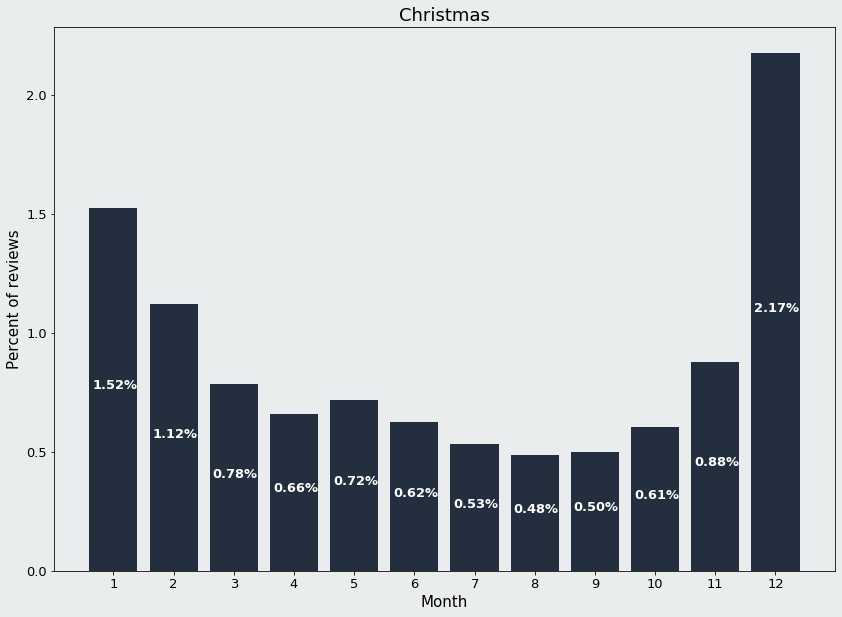

In [55]:
plot_proportion_year(['christmas', 'snowman', 'xmas'],\
                     reviews_month,\
                     lemmatized,\
                     title="Christmas",\
                     xlabel="Month",\
                     figsize=(14,10),\
                     linear_reg=False)

In [56]:
model.wv.most_similar('valentine')

[('hanukkah', 0.6876174211502075),
 ('sweetheart', 0.6657618880271912),
 ('halloween', 0.652550220489502),
 ('snowman', 0.6492404341697693),
 ('greeting', 0.6434973478317261),
 ('patrick', 0.6426348090171814),
 ('easter', 0.6422131061553955),
 ('kiss', 0.6382970809936523),
 ('ornament', 0.6327383518218994),
 ('christmas', 0.6255073547363281)]

Max difference of popularity (max - min): 0.54%


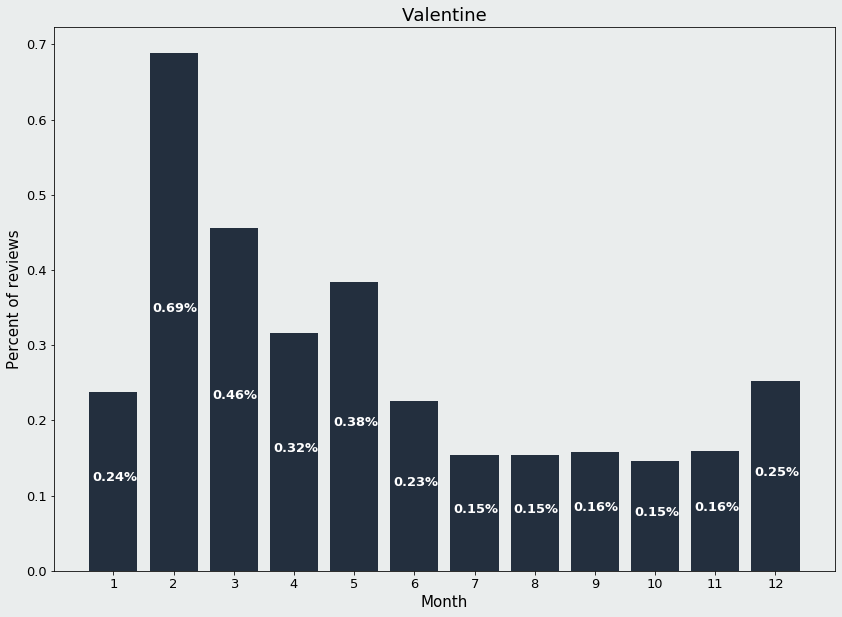

In [101]:
plot_proportion_year(['valentine'],\
                     reviews_month,\
                     lemmatized,\
                     title="Valentine",\
                     xlabel="Month",\
                     figsize=(14,10),\
                     linear_reg=False)

In [56]:
model.wv.most_similar('easter')

[('bunny', 0.7258546352386475),
 ('stocking', 0.6975997090339661),
 ('springtime', 0.6967744827270508),
 ('halloween', 0.6609281301498413),
 ('festive', 0.6337339878082275),
 ('hanukkah', 0.6308696269989014),
 ('christmas', 0.6295179128646851),
 ('greeting', 0.6181579828262329),
 ('adorable', 0.6161286234855652),
 ('dinosaur', 0.6136686205863953)]

Max difference of popularity (max - min): 0.80%


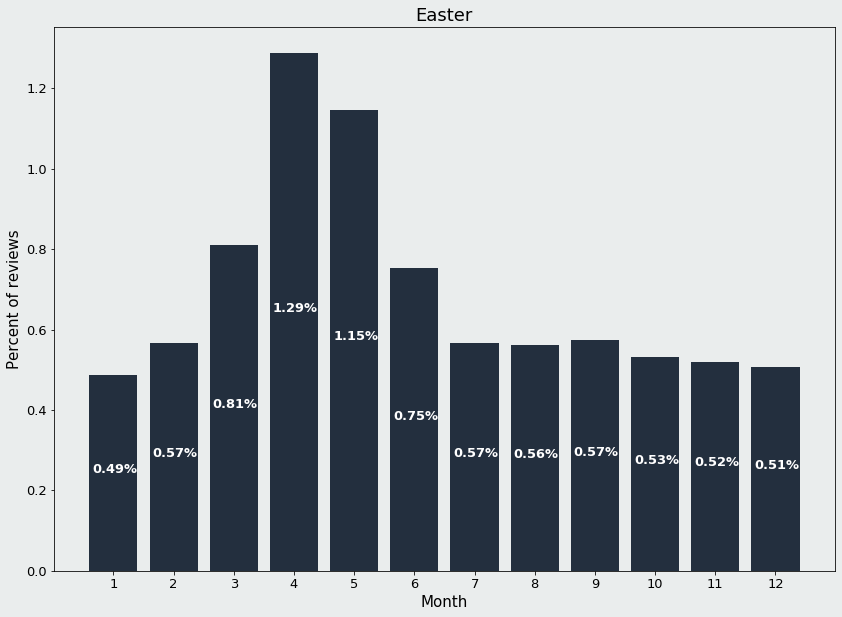

In [103]:
plot_proportion_year(['easter', 'bunny'],\
                     reviews_month,\
                     lemmatized,\
                     title="Easter",\
                     xlabel="Month",\
                     figsize=(14, 10),\
                     linear_reg=False)

### Measuring impact of events through bayesian structural time series

So far, in this section, we extracted popular products in a given time window and then extracted most popular words in the reviews of those products and compared them with the same words in the reviews of the same products but in the rest of the year. Then, we manually grouped those words into topics and concluded whether or not a given event affects the time window we chose.

Here the approach is different, instead of extracting topics we compare time series. In other words, we again consider products that are popular in the time window that we choose, the same way we did in last part, but we compare the time serie of one of the popular product of the time window with products that are considered not particularly popular in order to predict what the former would have been if the event wouldn't have affected it

In [131]:
def create_time_series(reviews_weeks_df, asins_to_sample):
    """
    Randomly sample nb_products_to_sample products in reviews_weeks_df for a given year
    """
    # iterate to create a dataframe with each column containing the time series of a product
    asins_time_series = pd.DataFrame()
    for a in asins_to_sample: 
        product = reviews_weeks_df.loc[(reviews_weeks_df.asin == a)]
        asins_time_series[a] = product['reviewCount'].to_numpy()
    return asins_time_series

In [136]:
def plot_causal_impact(event_product_asin, non_event_product_asins, reviews_per_week, event_start_date, event_duration, end_event_last_year, debug=False, verbose=True):
    # Filter reviews_per_week for concerned period i.e a whole year starting from the end of the year
    # from last year and the end of the event for the current year
    period_1 = end_event_last_year
    period_2 = event_start_date - pd.Timedelta('7d')
    period_3 = event_start_date
    period_4 = period_1 + pd.Timedelta('1y')
    reviews_per_week_year = reviews_per_week[(reviews_per_week['reviewTime'] >= period_1) & (reviews_per_week['reviewTime'] <= period_4)]
    
    # Extract time series of concerned asins
    time_series = create_time_series(reviews_per_week_year, event_product_asin + non_event_product_asins)
    time_series.set_index(pd.date_range(start=period_1, end=period_4, freq='W'), inplace=True)
    time_series.index = time_series.index.map(lambda date: pd.Timestamp(date.date()))
    time_series = time_series[event_product_asin + non_event_product_asins]
    if debug:
        display(time_series)
        print(period_1, period_2, period_3, period_4)
    
    # Predict and plot causalimpact
    period_4 = time_series.index[-1]
    pre_period = [pd.Timestamp(period_1.date()), pd.Timestamp(period_2.date())]
    post_period = [pd.Timestamp(period_3.date()), pd.Timestamp(period_4.date())]
    ci = CausalImpact(time_series, pre_period, post_period)
    ci.plot(panels=['original'], figsize=(15,7))
    if verbose:
        print(ci.trained_model.params)
        print(ci.summary())


In [133]:
VALENTINE_DATE_CI = pd.datetime(2017, 2, 12)
VALENTINE_END_LAST_YEAR = pd.datetime(2016, 2, 21)
VALENTINE_DURATION_CI = pd.Timedelta('14 days')
NOT_INFLUENCED_ASINS_V = ["B003IMMQZE", "B01AMT1IY0", "B01AT1XLBY", "B00E3IXLJW"]
INFLUENCED_ASIN_V = ['B00J5H346Q']

We start here with Valentine's day and for simplicity choose only one year starting from the end of february 2017. Our choice falls upons a product "Kabloom The Romantic Classic Bouquet of 12 Fresh Red Roses (Farm-Fresh, Long-Stem) with Vase" that appear among the top products of Valentine in terms of the number of reviews. The choice is of course arbitrary. So what's left is to take products that are related but that are not affected by the event in order to show what would have happened to our lovely Kabloom flowers if Valentine did not affect it. So we again manually selected the products in the cell below.

In [135]:
pretty_print(meta[meta['asin'].isin(NOT_INFLUENCED_ASINS_V)]['title'])

'Purple Dendrobium Orchids (10 stems Orchid with Rhinestone Mesh Ribbon Vase)'

'Benchmark Bouquets Assorted Peruvian Lilies, With Vase (Fresh Cut Flowers)'

('Kabloom Starry Night in the Tropics Bouquet of Blue and White Orchids from '
 'Thailand with Vase')

'Benchmark Bouquets Multi-Colored Tulips, With Vase (Fresh Cut Flowers)'



The idea is to take products that are similar to the one we're analysing but are not affected by the event. That way, a big difference in the two will be strongly correlated with the product being affected by the time window and hence the event. Thus, we chose bouquets of flowers (orchids, lilies, and tulips), one of them being of the same brand to increase the similarities with the target product. Let's now plot what our product would have been and then analyse what happened:

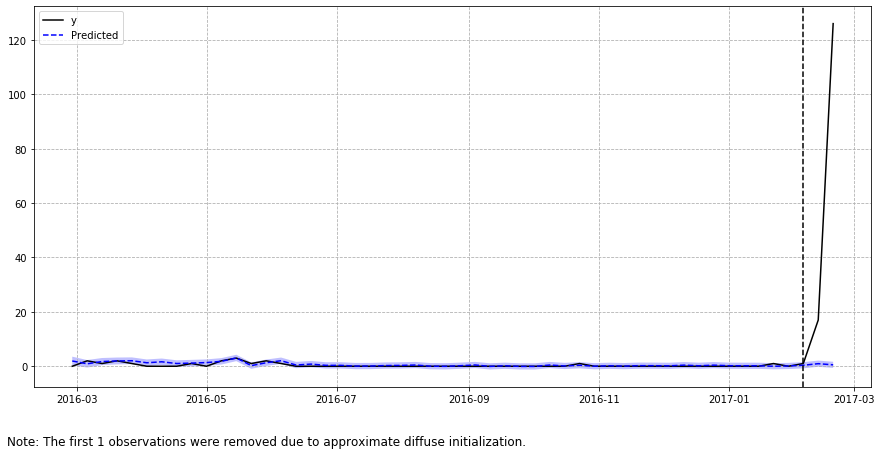

sigma2.irregular    0.517565
sigma2.level        0.000144
beta.B003IMMQZE     0.050706
beta.B01AMT1IY0     0.112241
beta.B01AT1XLBY     0.024830
beta.B00E3IXLJW     0.661074
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    71.5               143.0
Prediction (s.d.)         0.73 (0.41)        1.47 (0.82)
95% CI                    [-0.12, 1.5]       [-0.23, 3.0]

Absolute effect (s.d.)    70.77 (0.41)       141.53 (0.82)
95% CI                    [70.0, 71.62]      [140.0, 143.23]

Relative effect (s.d.)    9646.18% (56.13%)  9646.18% (56.13%)
95% CI                    [9541.91%, 9761.93%][9541.91%, 9761.93%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%



In [165]:
plot_causal_impact(INFLUENCED_ASIN_V, NOT_INFLUENCED_ASINS_V, reviews_per_week_filled, VALENTINE_DATE_CI,\
                   VALENTINE_DURATION_CI, VALENTINE_END_LAST_YEAR)

The plot shows the original time serie of the product we're interested in (Kabloom romantic bouquet) as a black line and uses bayesian structural time series (see https://github.com/dafiti/causalimpact for more informations) with the other products that we cautiously chose in order to forcast what the time serie would have been without the intervention of the event.

There are a few things to note. First of all, results seem really conclusive since our product is basically a flat line without the effect of Valentine. Therefore, we can see that the absence of the event drastically changes the Kabloom romantic bouquet's behaviour. Secondly, if we take a closer look at the `beta` parameters that are used to fit the new line, we can see that the other related bouquets are used more than the gaussian random noise `sigma2.irregular`, which is good news! Indeed it means that the model predicted a time serie based on those bouquets and did not create a random walker. Moreover, the 95% confidence interval of the average number of reviews during the period we're intersted in, without the effect of Valentine's day, is [-0.06, 1.54] which is really low compared to the average of the original time series of the Kabloom flowers that is 71.5. Indeed, it yield a relative increase of 9646.18% with a 95% CI of [9536.68%, 9754.18%]. Additionally, under the hypothesis that the predicted signal in the period of the event is the same as the original signal we get a 0 p-value which basically tells us that the probability of having a causal effect is 1. Finally, note that the model automatically normalized data, hence it allows us to take products that do not have the same popularity.

Results seem to be statistically conclusive, however we have to be careful about their interpretation. Indeed, we arbitrarily chose other bouquets that were not affected by Valentine's time window in order to show what effect the event can have on the Kabloom romantic bouquet. Consequently, the correlation between the products is crucial. We could have taken other products, such as potatoes, that have a flat time series and could have got the same statistical results, but in that case the interpretation would not make sense. 

On a final note, the purpose here is to show what effect the time window has on a product in order to reinforce the conclusions we made during the last part regarding the word frequencies. Thus, bayesian structural inference shows that the time window affected the product and the word frequency detects what event this is about.

We again choose a product among the top ones during Christmas whose title starts with "Holiday Nuts Gift Basket - Gourmet Food Gifts Prime" that was strongly affected during Christmas 2016 and then other related products (peanuts and nuts) that we show below:

In [168]:
CHRISTMAS_DATE_CI = pd.datetime(2016, 12, 4)
CHRISTMAS_END_LAST_YEAR = pd.datetime(2016, 1, 3)
CHRISTMAS_DURATION_CI = pd.Timedelta('30 days')
NOT_INFLUENCED_ASINS_C = ["B00KSN9TME", "B000U0OUP6", "B000E1FZHS", "B0010SEVWO", "B00K5R4ZWM"]
INFLUENCED_ASIN_C = ['B00KCCKV8W']

In [171]:
pretty_print(meta[meta['asin'].isin(NOT_INFLUENCED_ASINS_C)]['title'])

('Planters Dry Roasted Peanuts, Dry Roasted, Lightly Salted, 16 Ounce (Pack of '
 '12)')

'Planters Peanuts, Honey Roasted & Salted, 52 Ounce Canister (Pack of 2)'

'Brazil Nuts by Food to Live — 1 Pounds'

'Sincerely Nuts Whole Blue Poppy Seeds 2lb Bag (United Kingdom)'

('KIND Bars, Dark Chocolate Nuts & Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 '
 'Count')



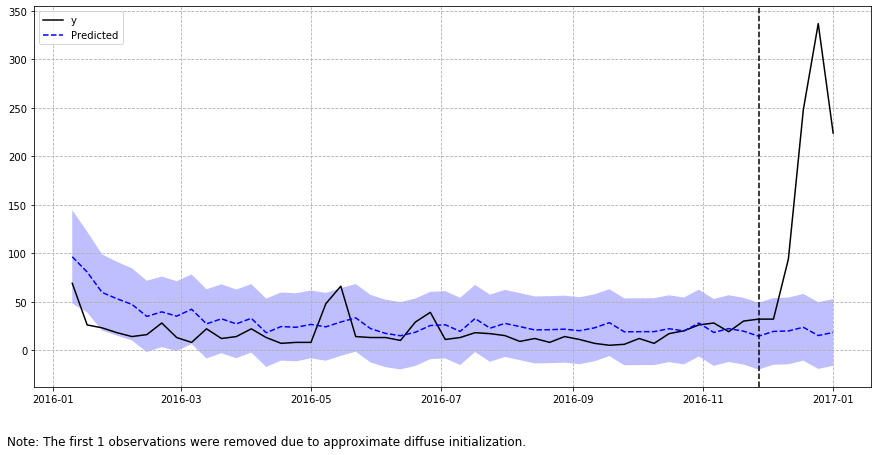

sigma2.irregular    0.957702
sigma2.level        0.000144
beta.B00KSN9TME     0.136893
beta.B000U0OUP6    -0.153263
beta.B000E1FZHS     0.262309
beta.B0010SEVWO     0.022350
beta.B00K5R4ZWM    -0.180395
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    187.0              935.0
Prediction (s.d.)         19.19 (8.66)       95.96 (43.29)
95% CI                    [2.1, 36.03]       [10.49, 180.17]

Absolute effect (s.d.)    167.81 (8.66)      839.04 (43.29)
95% CI                    [150.97, 184.9]    [754.83, 924.51]

Relative effect (s.d.)    874.38% (45.11%)   874.38% (45.11%)
95% CI                    [786.62%, 963.45%] [786.62%, 963.45%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%



In [169]:
plot_causal_impact(INFLUENCED_ASIN_C, NOT_INFLUENCED_ASINS_C, reviews_per_week_filled, CHRISTMAS_DATE_CI, CHRISTMAS_DURATION_CI, CHRISTMAS_END_LAST_YEAR)

Again, we get a 0 p-value and thus the probability that the time window we chose for Christmas affected the nuts gift basket by chance is 0. However, the confidence intervals are wider. Indeed, the average predicted number of reviews of the nuts gift basket during the time window of Christmas is 19.19 with a confidence interval of [2.1, 36.03]. This model seems to be less sure about how much more it affected the nuts gift basket, but still 100% sure that a given effect has occured. Furthermore, if we compare the `beta` parameters with the `sigma2.irregular` we can see that the model uses more the noise for this case. It might be the case that signals were more irregular than during the previous example. 